# Comparación de las variables entre los diferentes grupos.

En esta libreta se realiza una comparación de las variables de interés entre los diferentes grupos mediante análisis de varianza, Kruskal-Wallis y pruebas Post Hoc (Tukey HSD)

## Dependencias

In [187]:
import pandas as pd
import os
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
from statsmodels.stats.multicomp import pairwise_tukeyhsd

## Lectura de los datos 

In [188]:
evi_ndvi = pd.read_csv('EVI_NDVI.zip')
evi_ndvi.fecha = pd.to_datetime(evi_ndvi.fecha)
evi_ndvi.head()

X            Y      fecha  especie localizacion metrica   valor
0  675860.246  3265951.634 2000-02-18  ENCINAR       DENTRO     EVI  1715.0
1  676300.806  3265951.634 2000-02-18  ENCINAR       DENTRO     EVI  1547.0
2  676521.087  3262427.148 2000-02-18  ENCINAR       DENTRO     EVI  1543.0
3  675419.685  3260444.625 2000-02-18  ENCINAR       DENTRO     EVI  1517.0
4  675639.965  3260444.625 2000-02-18  ENCINAR       DENTRO     EVI  1531.0

In [189]:
root = 'Material Sara Dennis/TIMESAT'
metricas = ['EVI', 'NDVI']


In [190]:
datasets = []
for metrica in metricas:
    path = f'{root}/{metrica}'
    for f in os.listdir(path):
        datasets.append(f'{path}/{f}')
datasets

['Material Sara Dennis/TIMESAT/EVI/VAR_FEN_EVI_D&F.xlsx',
 'Material Sara Dennis/TIMESAT/NDVI/VAR_FEN_NDVI_D&F.xlsx']

In [191]:
columnas_importantes = [0,3,4,6,7,8]
ts_evi = pd.read_excel(datasets[0], usecols=columnas_importantes)
ts_ndvi = pd.read_excel(datasets[1], usecols=columnas_importantes)

In [192]:
def obtener_localizacion(string):
    return 'DENTRO' if string[-1] == 'D' else 'FUERA'

def preparar_dataframe(df):
    df.columns = [c.strip() for c in df.columns]
    df['LOCALIZACION'] = df.CLASE_VEG.apply(obtener_localizacion)
    df.CLASE_VEG = df.CLASE_VEG.apply(lambda c: c[:-2])
    return df   

ts_evi = preparar_dataframe(ts_evi)
ts_ndvi = preparar_dataframe(ts_ndvi)


In [193]:
print('TIMESAT EVI')
ts_evi

TIMESAT EVI


CLASE_VEG  INICIO  AMPLITUD  DURACION  INTMAY  INTMEN LOCALIZACION
0     ENCINAR  172.96      1987   167.360   32030   13410       DENTRO
1     ENCINAR  172.96      1972   148.272   30020   12640       DENTRO
2     ENCINAR  192.16      1782   133.152   24720   10770       DENTRO
3     ENCINAR  207.36      2162   258.880   41990   16480       DENTRO
4     ENCINAR  203.20      1629   268.640   40850   14580       DENTRO
..        ...     ...       ...       ...     ...     ...          ...
275   VEGARRO  193.60      3439   115.088   33670   18730        FUERA
276   VEGARRO  187.20      3195   122.432   35060   18230        FUERA
277   VEGARRO  193.60      3336   106.720   28380   16540        FUERA
278   VEGARRO  184.00      2984   115.392   28930   16090        FUERA
279   VEGARRO  174.40      2812   169.280   42750   21930        FUERA

[280 rows x 7 columns]

In [194]:
print('TIMESAT NDVI')
ts_ndvi

TIMESAT NDVI


CLASE_VEG  INICIO  AMPLITUD  DURACION  INTMAY  INTMEN LOCALIZACION
0     ENCINAR  177.44      3145    230.56   70050   33880       DENTRO
1     ENCINAR  177.44      3019    302.40   89970   42230       DENTRO
2     ENCINAR  187.04      2814    286.08   79660   33570       DENTRO
3     ENCINAR  206.40      3614    277.76   83110   39800       DENTRO
4     ENCINAR  201.60      2878    292.16   81110   36720       DENTRO
..        ...     ...       ...       ...     ...     ...          ...
275   VEGARRO  192.00      4714    290.40  112600   48580        FUERA
276   VEGARRO  187.20      4493    223.36   92640   40570        FUERA
277   VEGARRO  187.20      4721    270.24  100500   45700        FUERA
278   VEGARRO  185.60      4817    229.92   84990   40530        FUERA
279   VEGARRO  174.40      4185    306.72  124300   57870        FUERA

[280 rows x 7 columns]

## Búsqueda de diferencias

Se pretende realizar un análisis de varianza para cada variable de interés. En este caso, las tuplas (especie, localización) serán los diferentes grupos. Supondremos que los datos son independientes pero necesitamos comprobar:

1. Que la variable de interés se encuentra normalmente distribuida dentro de cada grupo
2. Que las varianzas de los grupos respecto a la variable de interés sean homogéneas

### EVI

#### Obtención de los datos de la última temporada húmeda
Primero, se obtienen los datos del EVI en la temporada húmeda del 2020

In [195]:
# EVI
temp_hum_evi = evi_ndvi[
    (evi_ndvi.fecha >=  '2020-07-27') &
    (evi_ndvi.fecha <= '2020-10-15') &
    (evi_ndvi.metrica == 'EVI')
].copy().reset_index(drop=True)

# Se crea la columna grupo y outlier
temp_hum_evi['grupo'] = temp_hum_evi.especie + ' ' + temp_hum_evi.localizacion
temp_hum_evi.head()

X            Y      fecha  especie localizacion metrica   valor  \
0  675860.246  3265951.634 2020-07-27  ENCINAR       DENTRO     EVI  3462.0   
1  676300.806  3265951.634 2020-07-27  ENCINAR       DENTRO     EVI  3287.0   
2  676521.087  3262427.148 2020-07-27  ENCINAR       DENTRO     EVI  3120.0   
3  675419.685  3260444.625 2020-07-27  ENCINAR       DENTRO     EVI  3751.0   
4  675639.965  3260444.625 2020-07-27  ENCINAR       DENTRO     EVI  3159.0   

            grupo  
0  ENCINAR DENTRO  
1  ENCINAR DENTRO  
2  ENCINAR DENTRO  
3  ENCINAR DENTRO  
4  ENCINAR DENTRO

#### Localización de datos atípicos

Revisamos si existen datos atípicos

In [196]:
def boxplots_variable_intergrupos(df, title, x, y, hue):
    fig , ax = plt.subplots(1,1,figsize=(15,10))
    ax.set_title(title, fontsize=25)
    sns.boxplot(x=x, y=y, hue=hue, data = df, ax=ax)
    plt.show()

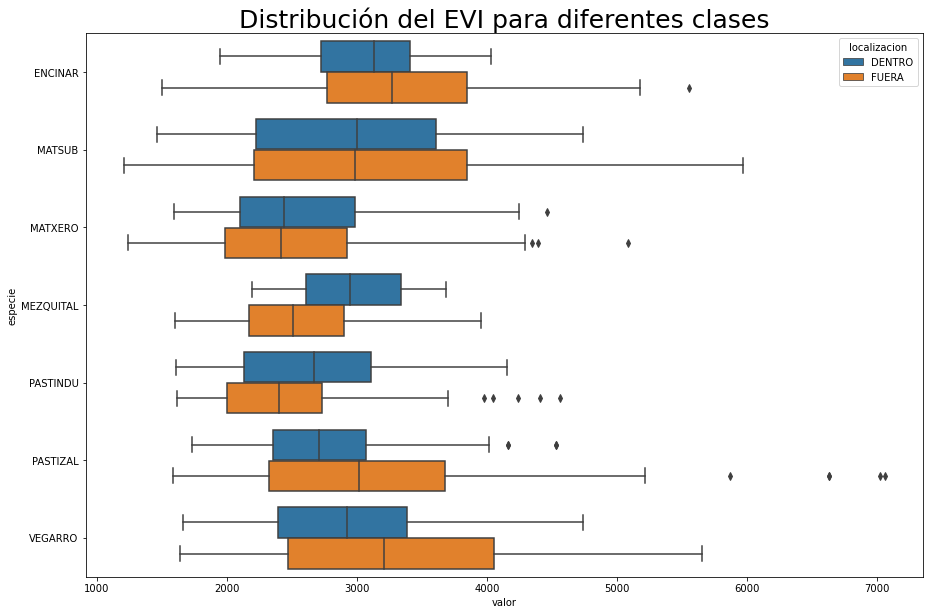

In [197]:

boxplots_variable_intergrupos(temp_hum_evi, 'Distribución del EVI para diferentes clases', 'valor', 'especie', 'localizacion')

Podemos notar que sí existen algunos valores anómalos. Vamos a eliminarlos utilizando el rango intercuartílico como referencia

In [198]:
def identificacion_outliers(df, col_grupos, col_variable, idx_col_outliers, col_especie, col_localizacion):
    a = 0
    for grupo in df[col_grupos].unique():
        g = df[df[col_grupos] == grupo]
        q3, q1 = np.percentile(g[col_variable], [75 ,25])
        iqr = q3 - q1

        for i in g.index:
            if df.iloc[i, :][col_variable] < q1-1.5*iqr or df.iloc[i, :][col_variable] > q3+1.5*iqr:
                a += 1
                df.iloc[i, idx_col_outliers] = 1    


    fig , axs = plt.subplots(2,1,figsize=(15,10))

    print('# de outliers identificados:', a)
    axs[0].set_title('Con outliers')
    sns.boxplot(x=col_variable, y=col_especie, hue=col_localizacion, data = df, ax=axs[0])

    axs[1].set_title('Sin outliers')
    sns.boxplot(x=col_variable, y=col_especie, hue=col_localizacion, data = df[df[df.columns[idx_col_outliers]] == 0], ax=axs[1])

# de outliers identificados: 19


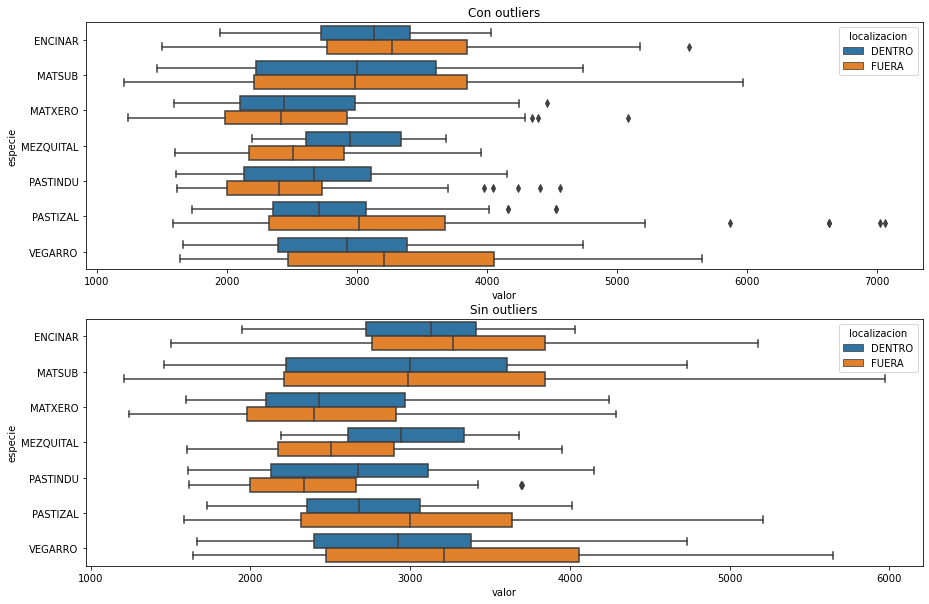

In [199]:
temp_hum_evi['outlier'] = 0
idx_col_outliers = temp_hum_evi.columns.to_list().index('outlier')

identificacion_outliers(
    temp_hum_evi,
    'grupo',
    'valor',
    idx_col_outliers,
    'especie',
    'localizacion'
)

#### Conteo del número de observaciones por grupo
Ahora, checamos cuántos sujetos tenemos en cada grupo

In [200]:
def revisar_num_muestras_por_grupo(df, col_grupos, idx_col_outliers):
    fig , axs = plt.subplots(2,1,figsize=(30,10))
    plt.subplots_adjust(hspace = 0.5 )

    axs[0].set_title('Número de observaciones por grupo (con outliers)', fontsize=25)
    sns.barplot(x=col_grupos, y=0, data=df.groupby(col_grupos).size().reset_index(), ax=axs[0])
    try:
        axs[0].bar_label(axs[0].containers[0], fontsize=18)
    except:
        pass
    axs[0].spines['top'].set_visible(False)
    axs[0].spines['right'].set_visible(False)

    axs[1].set_title('Número de observaciones por grupo (sin outliers)', fontsize=25)
    sns.barplot(x=col_grupos, y=0, data=df[df[df.columns[idx_col_outliers]] == 0].groupby(col_grupos).size().reset_index(), ax=axs[1])
    try:
        axs[1].bar_label(axs[1].containers[0], fontsize=18)
    except:
        pass
    axs[1].spines['top'].set_visible(False)
    axs[1].spines['right'].set_visible(False)

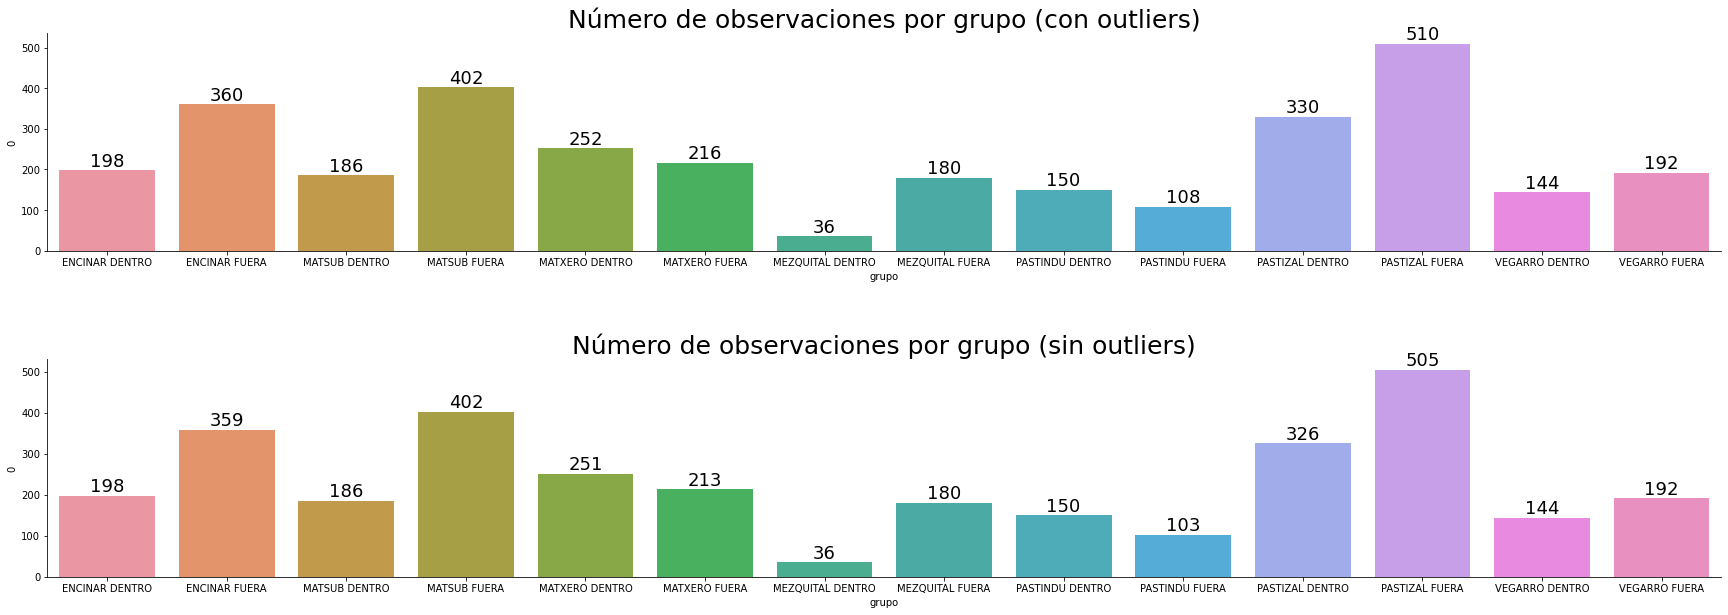

In [201]:
revisar_num_muestras_por_grupo(temp_hum_evi, 'grupo', idx_col_outliers)

#### Revisión del supuesto de normalidad

Ahora, se revisará el supuesto de normalidad. A partir de aquí trabajaremos sin datos atípicos

In [202]:
def histogramas_por_clase(df, col_grupos, col_variable):
    fig , axs = plt.subplots(2,7,figsize=(30,10))
    for grupo, ax in zip(df[col_grupos].unique(), axs.ravel()):
        ax.set_title(grupo)
        sns.histplot(x=col_variable, data=df[df[col_grupos] == grupo], ax=ax)

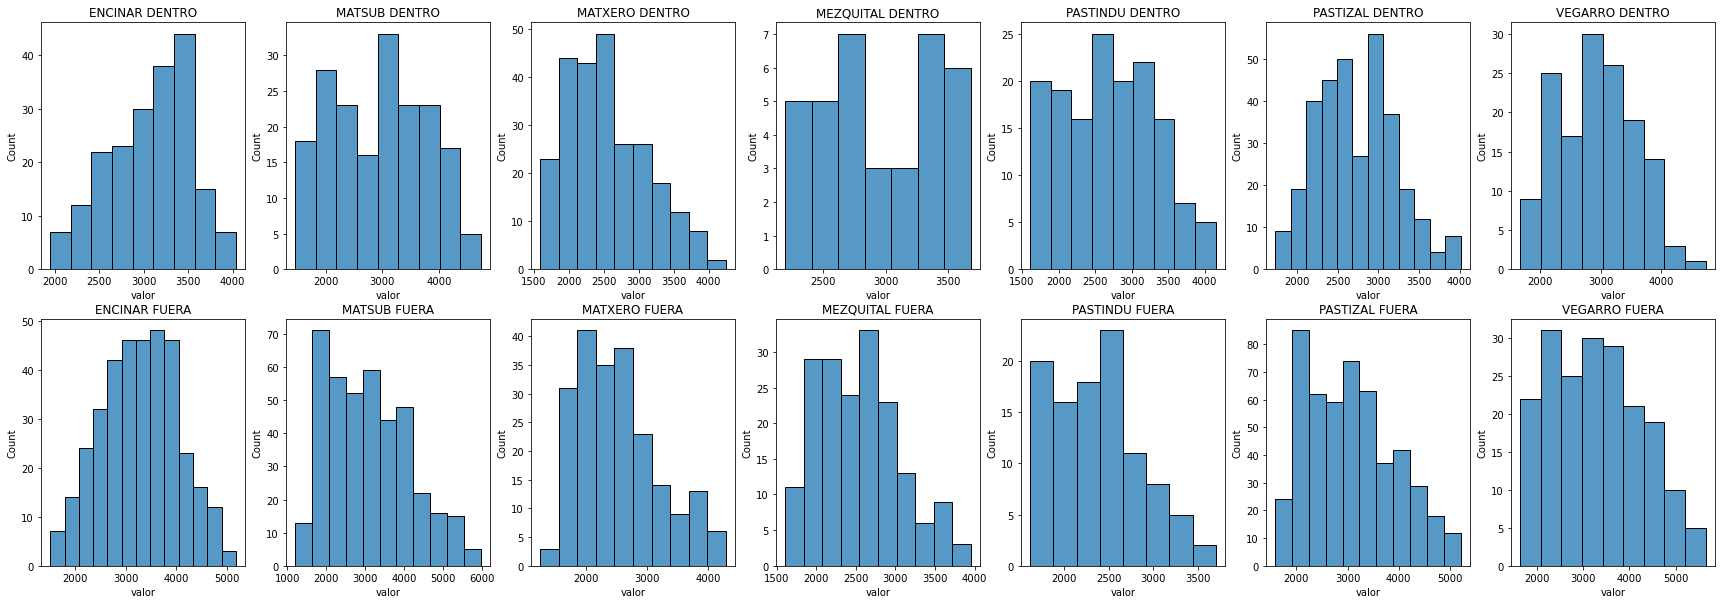

In [203]:
temp_hum_evi = temp_hum_evi[temp_hum_evi.outlier == 0].copy()
histogramas_por_clase(temp_hum_evi, 'grupo', 'valor')

In [204]:
def pruebas_normalidad_shapiro(df, col_grupos, col_variable):
    datos = {'grupo': [], 'W': [], 'pvalor':[]}
    for grupo in df[col_grupos].unique():
        shapiro_test = stats.shapiro(df[(df[col_grupos]==grupo)][col_variable])
        datos['grupo'].append(grupo)
        datos['W'].append(shapiro_test.statistic)
        datos['pvalor'].append(shapiro_test.pvalue)
    return pd.DataFrame(datos)

In [205]:
resultados_test_norm = pruebas_normalidad_shapiro(temp_hum_evi, 'grupo', 'valor')
resultados_test_norm[resultados_test_norm.pvalor > .05]

grupo         W    pvalor
3  MEZQUITAL DENTRO  0.942322  0.060017
6    VEGARRO DENTRO  0.982810  0.068215
7     ENCINAR FUERA  0.992793  0.081778

Con un nivel de significancia $\alpha=.05$, el supuesto de normalidad únicamente se cumple para **MEZQUITAL DENTRO**, **VEGARRO DENTRO** **ENCINAR FUERA**

#### Revisión del supuesto de homogeneidad de varianzas
Ahora, se revisará el supuesto de homogeneidad de varianzas

In [206]:
def graficar_varianzas_intergrupos(df, col_grupos, col_variable):
    fig , ax = plt.subplots(1,1,figsize=(30,10))

    ax.set_title('Varianza de cada grupo', fontsize=25)
    sns.barplot(x=col_grupos, y=col_variable, data=df.groupby(col_grupos)[col_variable].var().reset_index(), ax=ax)
    try:
        ax.bar_label(ax.containers[0], fontsize=18)
    except:
        pass
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    

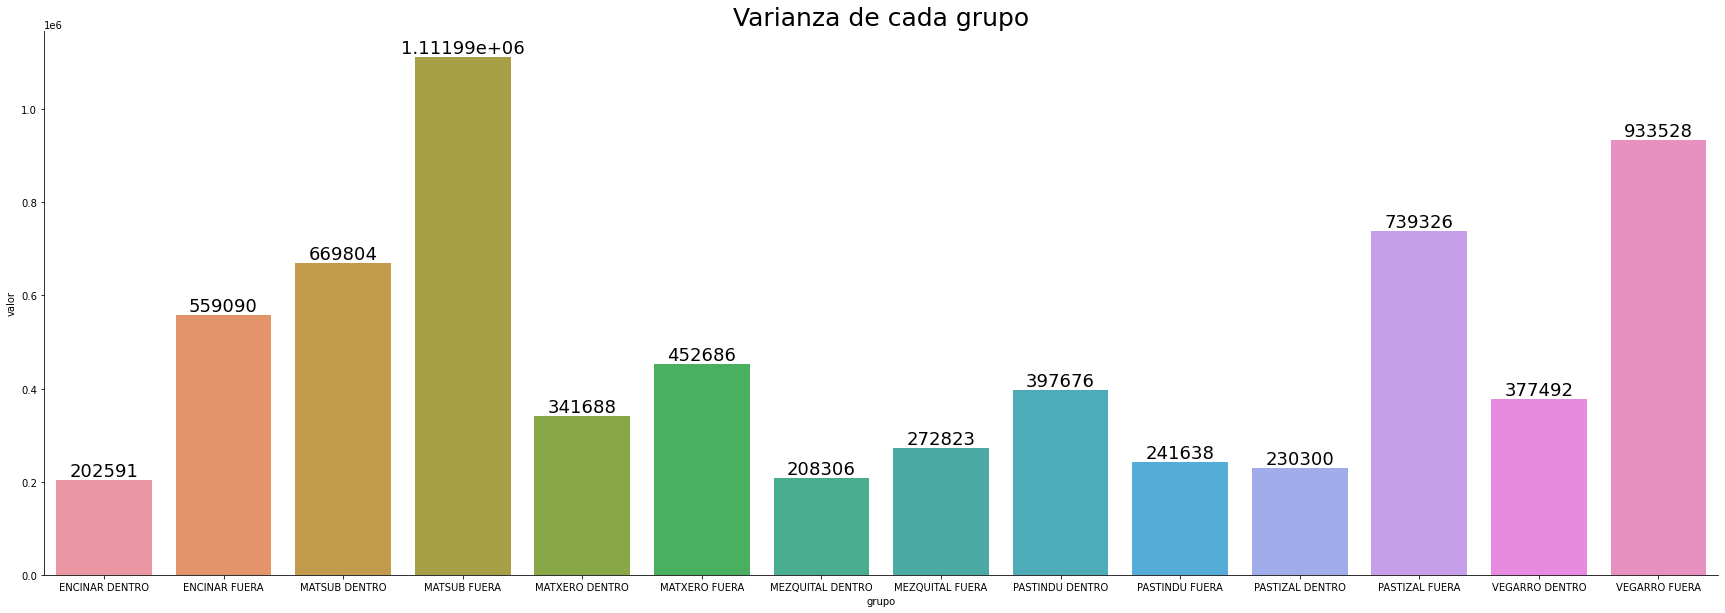

In [207]:
graficar_varianzas_intergrupos(temp_hum_evi, 'grupo', 'valor')

In [208]:
def prueba_levene(df, col_grupos, col_variable):
    levene = stats.levene(
        df[df[col_grupos] == 'ENCINAR DENTRO'][col_variable],
        df[df[col_grupos] == 'ENCINAR FUERA'][col_variable],
        df[df[col_grupos] == 'MATSUB DENTRO'][col_variable],
        df[df[col_grupos] == 'MATSUB FUERA'][col_variable],
        df[df[col_grupos] == 'MATXERO DENTRO'][col_variable],
        df[df[col_grupos] == 'MATXERO FUERA'][col_variable],
        df[df[col_grupos] == 'MEZQUITAL DENTRO'][col_variable],
        df[df[col_grupos] == 'MEZQUITAL FUERA'][col_variable],
        df[df[col_grupos] == 'PASTINDU DENTRO'][col_variable],
        df[df[col_grupos] == 'PASTINDU FUERA'][col_variable],
        df[df[col_grupos] == 'PASTIZAL DENTRO'][col_variable],
        df[df[col_grupos] == 'PASTIZAL FUERA'][col_variable],
        df[df[col_grupos] == 'VEGARRO DENTRO'][col_variable],
        df[df[col_grupos] == 'VEGARRO FUERA'][col_variable]
    )
    
    return levene

In [209]:
print(prueba_levene(temp_hum_evi, 'grupo', 'valor'))

LeveneResult(statistic=37.13635316722272, pvalue=4.2175199479756044e-88)


Tampoco la homogeneidad de varianzas se cumple. Por lo tanto, un ANOVA no sería apropiado

#### Kruskal-Wallis

Ya que los supuestos del ANOVA no se cumplen, tendremos que hacer uso de Kruskal-Wallis ya que es una prueba de hipótesis no paramétrica

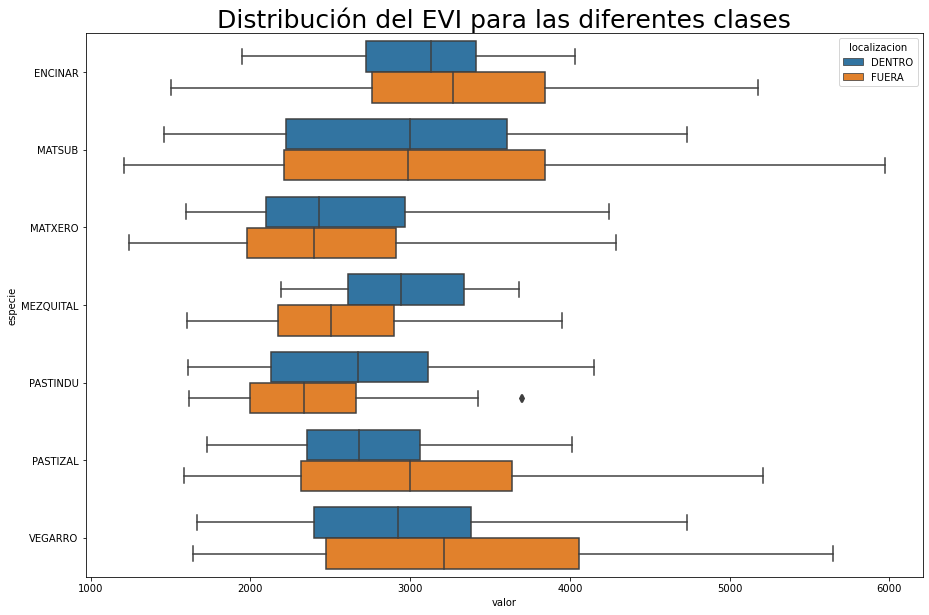

In [210]:
boxplots_variable_intergrupos(temp_hum_evi, 'Distribución del EVI para las diferentes clases', 'valor', 'especie', 'localizacion')

In [211]:
def prueba_kruskal_wallis(df, col_grupos, col_variable):
    kruskal = stats.kruskal(
        df[df[col_grupos] == 'ENCINAR DENTRO'][col_variable],
        df[df[col_grupos] == 'ENCINAR FUERA'][col_variable],
        df[df[col_grupos] == 'MATSUB DENTRO'][col_variable],
        df[df[col_grupos] == 'MATSUB FUERA'][col_variable],
        df[df[col_grupos] == 'MATXERO DENTRO'][col_variable],
        df[df[col_grupos] == 'MATXERO FUERA'][col_variable],
        df[df[col_grupos] == 'MEZQUITAL DENTRO'][col_variable],
        df[df[col_grupos] == 'MEZQUITAL FUERA'][col_variable],
        df[df[col_grupos] == 'PASTINDU DENTRO'][col_variable],
        df[df[col_grupos] == 'PASTINDU FUERA'][col_variable],
        df[df[col_grupos] == 'PASTIZAL DENTRO'][col_variable],
        df[df[col_grupos] == 'PASTIZAL FUERA'][col_variable],
        df[df[col_grupos] == 'VEGARRO DENTRO'][col_variable],
        df[df[col_grupos] == 'VEGARRO FUERA'][col_variable]
    )
    
    return kruskal

In [212]:
print(prueba_kruskal_wallis(temp_hum_evi, 'grupo', 'valor'))

KruskalResult(statistic=381.2956181450812, pvalue=1.9833913215878826e-73)


#### Pruebas Post Hoc: Tukey HSD

Tenemos suficiente evidencia para rechazar la hipótesis nula de Kruskal-Wallis que nos dice que las distribuciones de las poblaciones son iguales al menos entre un par de grupos. Ahora, realizaremos pruebas Post Hoc para conocer qué distribuciones difieren entre sí.

In [213]:
def prueba_tukey(df, col_grupos, col_variable, col_especies):
    prueba = pairwise_tukeyhsd(endog=df[col_variable], groups=df[col_grupos], alpha=0.05)
    resultados_completos = pd.DataFrame.from_records(prueba.summary().data)
    resultados_completos.columns = resultados_completos.iloc[0,:]
    resultados_completos = resultados_completos.iloc[1:,:] 

    comparaciones_de_interes = pd.DataFrame()
    for especie in df[col_especies].unique():
        comparacion = resultados_completos[(resultados_completos.group1 == f'{especie} DENTRO')
                                & (resultados_completos.group2 == f'{especie} FUERA')]
        comparaciones_de_interes = pd.concat([comparaciones_de_interes, comparacion])

    return prueba, resultados_completos, comparaciones_de_interes

In [214]:
obj_tukey, _, comparaciones_dentro_fuera = prueba_tukey(temp_hum_evi, 'grupo', 'valor', 'especie')
comparaciones_dentro_fuera

0             group1           group2  meandiff   p-adj     lower     upper  \
1     ENCINAR DENTRO    ENCINAR FUERA  208.9809  0.0912  -13.4582  431.4199   
26     MATSUB DENTRO     MATSUB FUERA  135.2946  0.7144  -87.5399  358.1291   
47    MATXERO DENTRO    MATXERO FUERA  -29.1402     0.9  -263.237  204.9567   
64  MEZQUITAL DENTRO  MEZQUITAL FUERA -429.6056   0.094 -888.3836   29.1725   
77   PASTINDU DENTRO   PASTINDU FUERA -320.5097  0.0518 -642.0677    1.0483   
86   PASTIZAL DENTRO   PASTIZAL FUERA  346.1772   0.001   167.648  524.7064   
91    VEGARRO DENTRO    VEGARRO FUERA  377.6128   0.001  100.5993  654.6264   

0  reject  
1   False  
26  False  
47  False  
64  False  
77  False  
86   True  
91   True

Text(0.5, 1.0, 'Intervalos de confianza para la media de cada grupo')

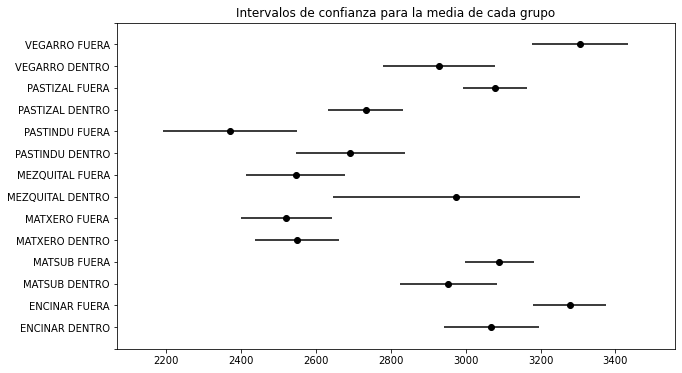

In [215]:
fig , ax = plt.subplots(1,1,figsize=(15,10))

_ = obj_tukey.plot_simultaneous(ax=ax)
ax.set_title('Intervalos de confianza para la media de cada grupo')

### NDVI

#### Obtención de los datos de la última temporada húmeda

In [216]:
# NDVI
temp_hum_ndvi = evi_ndvi[
    (evi_ndvi.fecha >=  '2020-07-27') &
    (evi_ndvi.fecha <= '2020-10-15') &
    (evi_ndvi.metrica == 'NDVI')
].copy().reset_index(drop=True)

# Se crea la columna grupo y outlier
temp_hum_ndvi['grupo'] = temp_hum_ndvi.especie + ' ' + temp_hum_ndvi.localizacion
temp_hum_ndvi.head()

X            Y      fecha  especie localizacion metrica   valor  \
0  675860.252  3265951.876 2020-07-27  ENCINAR       DENTRO    NDVI  5977.0   
1  676300.819  3265951.876 2020-07-27  ENCINAR       DENTRO    NDVI  5869.0   
2  676521.102  3262427.342 2020-07-27  ENCINAR       DENTRO    NDVI  5424.0   
3  675419.685  3260444.792 2020-07-27  ENCINAR       DENTRO    NDVI  5426.0   
4  675639.968  3260444.792 2020-07-27  ENCINAR       DENTRO    NDVI  5426.0   

            grupo  
0  ENCINAR DENTRO  
1  ENCINAR DENTRO  
2  ENCINAR DENTRO  
3  ENCINAR DENTRO  
4  ENCINAR DENTRO

#### Localización de datos atípicos

Revisamos si existen datos atípicos

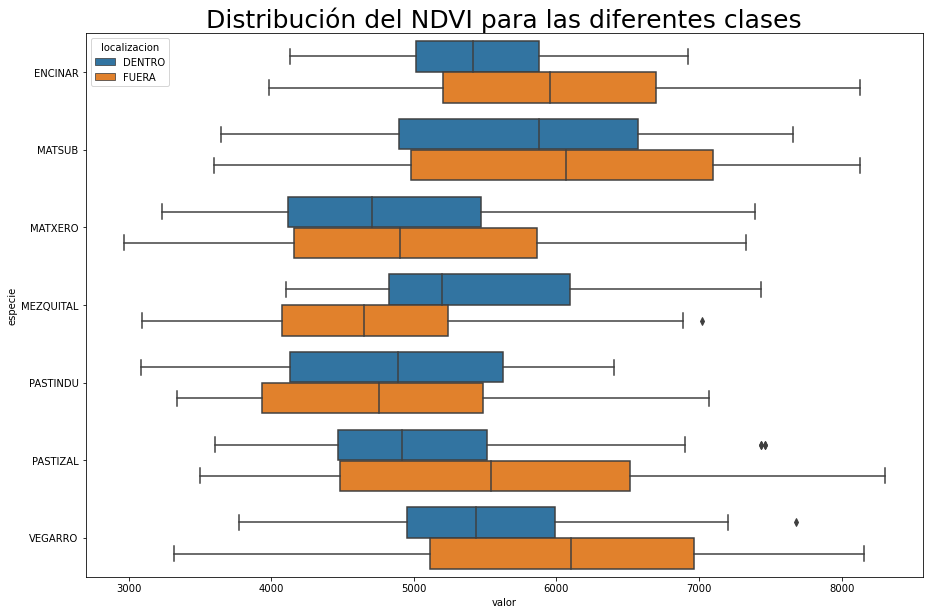

In [217]:

boxplots_variable_intergrupos(temp_hum_ndvi, 'Distribución del NDVI para las diferentes clases', 'valor', 'especie', 'localizacion')

# de outliers identificados: 6


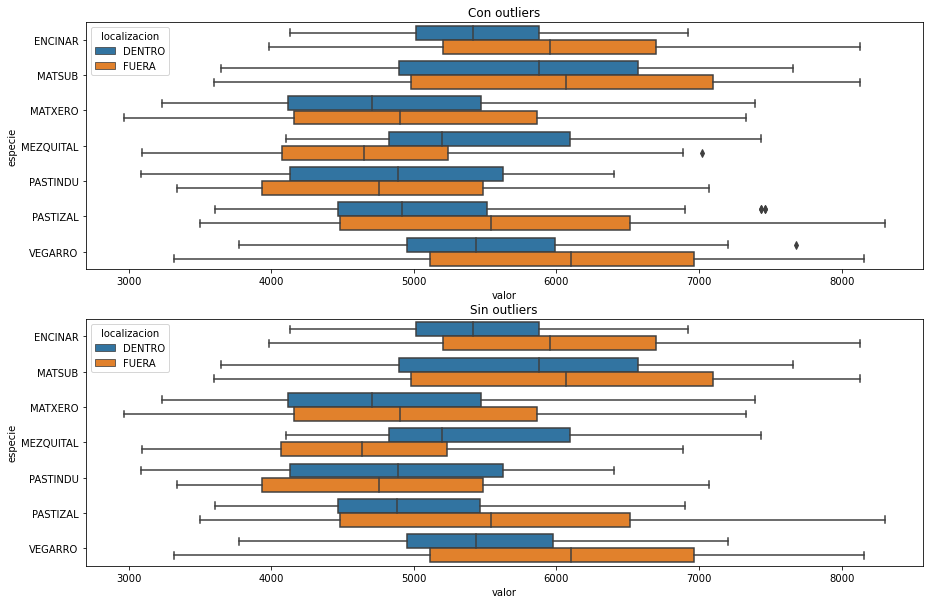

In [218]:
temp_hum_ndvi['outlier'] = 0
idx_col_outliers = temp_hum_ndvi.columns.to_list().index('outlier')

identificacion_outliers(
    temp_hum_ndvi,
    'grupo',
    'valor',
    idx_col_outliers,
    'especie',
    'localizacion'
)

#### Conteo del número de observaciones por grupo

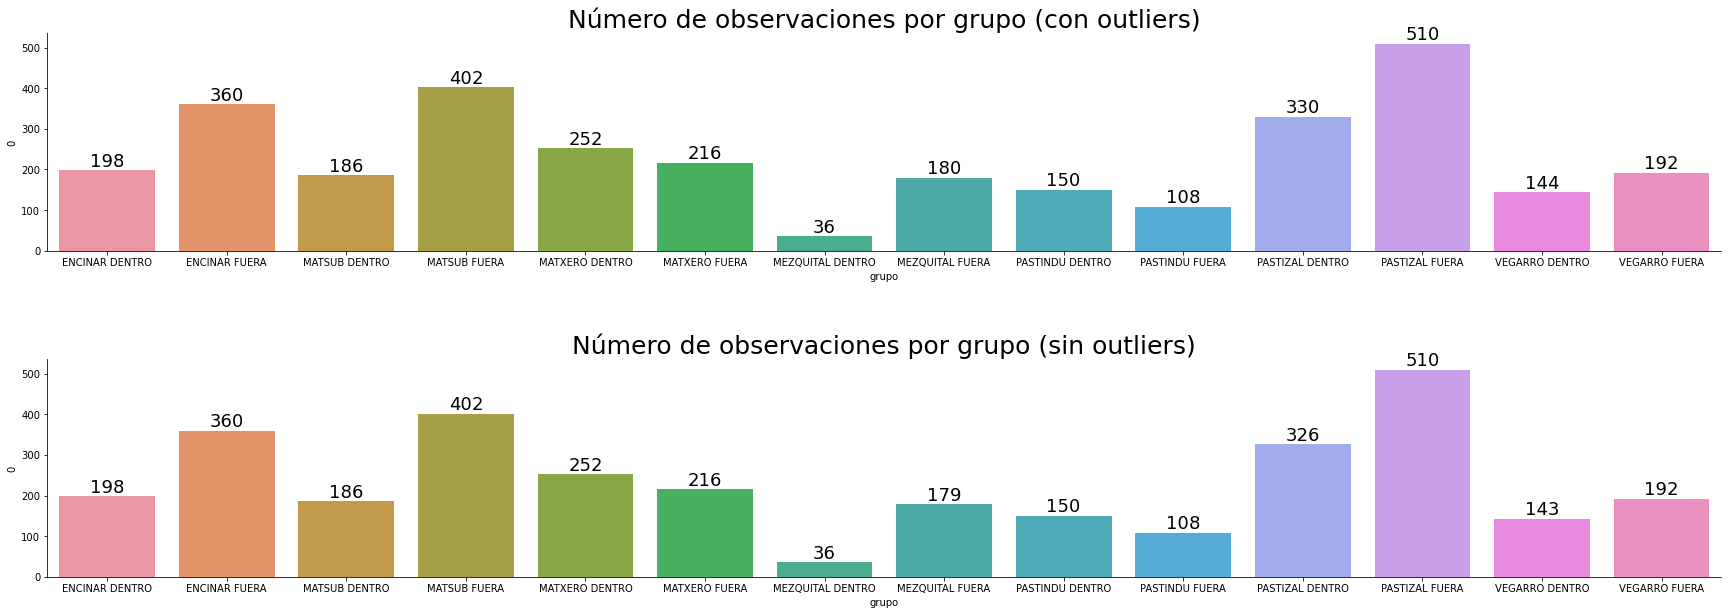

In [219]:
revisar_num_muestras_por_grupo(temp_hum_ndvi, 'grupo', idx_col_outliers)

#### Revisión del supuesto de normalidad

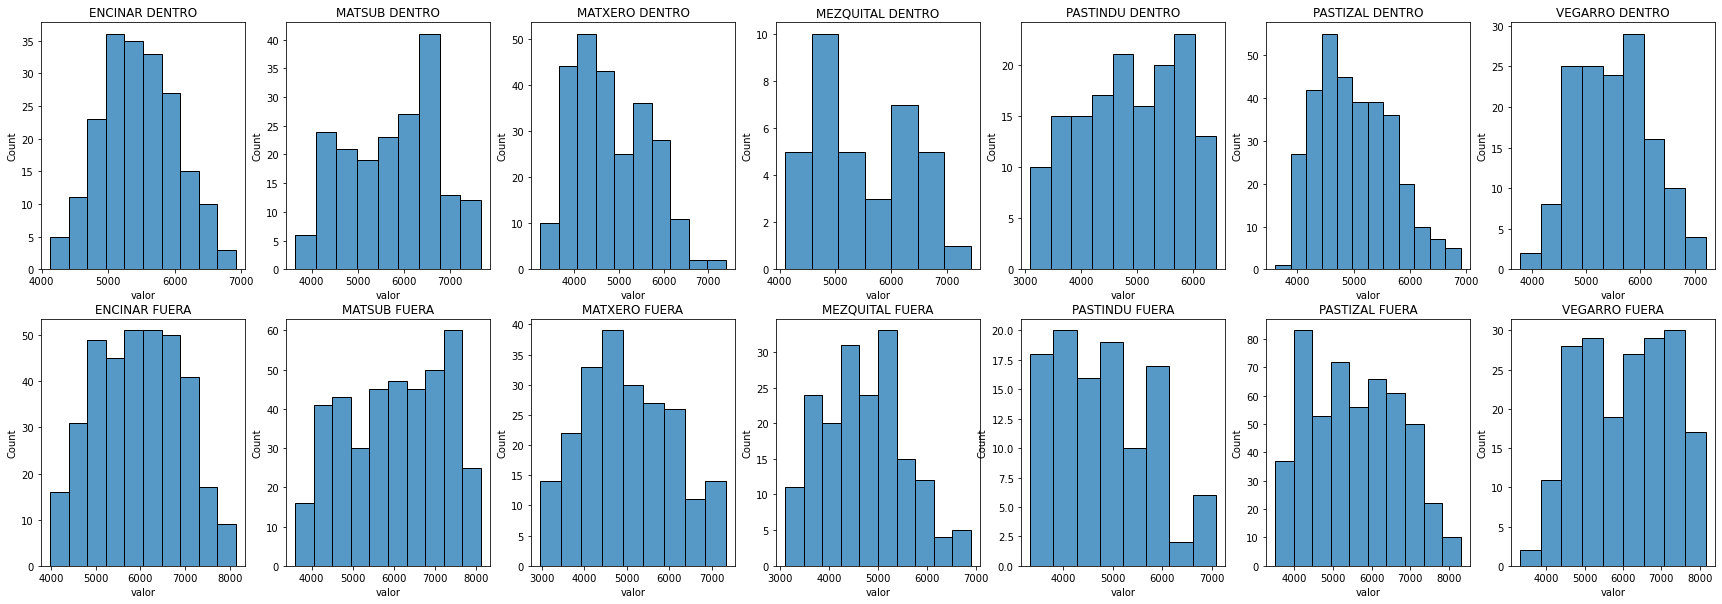

In [220]:
temp_hum_ndvi = temp_hum_ndvi[temp_hum_ndvi.outlier == 0].copy()
histogramas_por_clase(temp_hum_ndvi, 'grupo', 'valor')

In [221]:
resultados_test_norm = pruebas_normalidad_shapiro(temp_hum_ndvi, 'grupo', 'valor')
resultados_test_norm[resultados_test_norm.pvalor > .05]

grupo         W    pvalor
0    ENCINAR DENTRO  0.989516  0.156600
3  MEZQUITAL DENTRO  0.947143  0.085019
6    VEGARRO DENTRO  0.989618  0.368846

#### Revisión del supuesto de homogeneidad de varianzas

Ahora, se revisará el supuesto de homogeneidad de varianzas

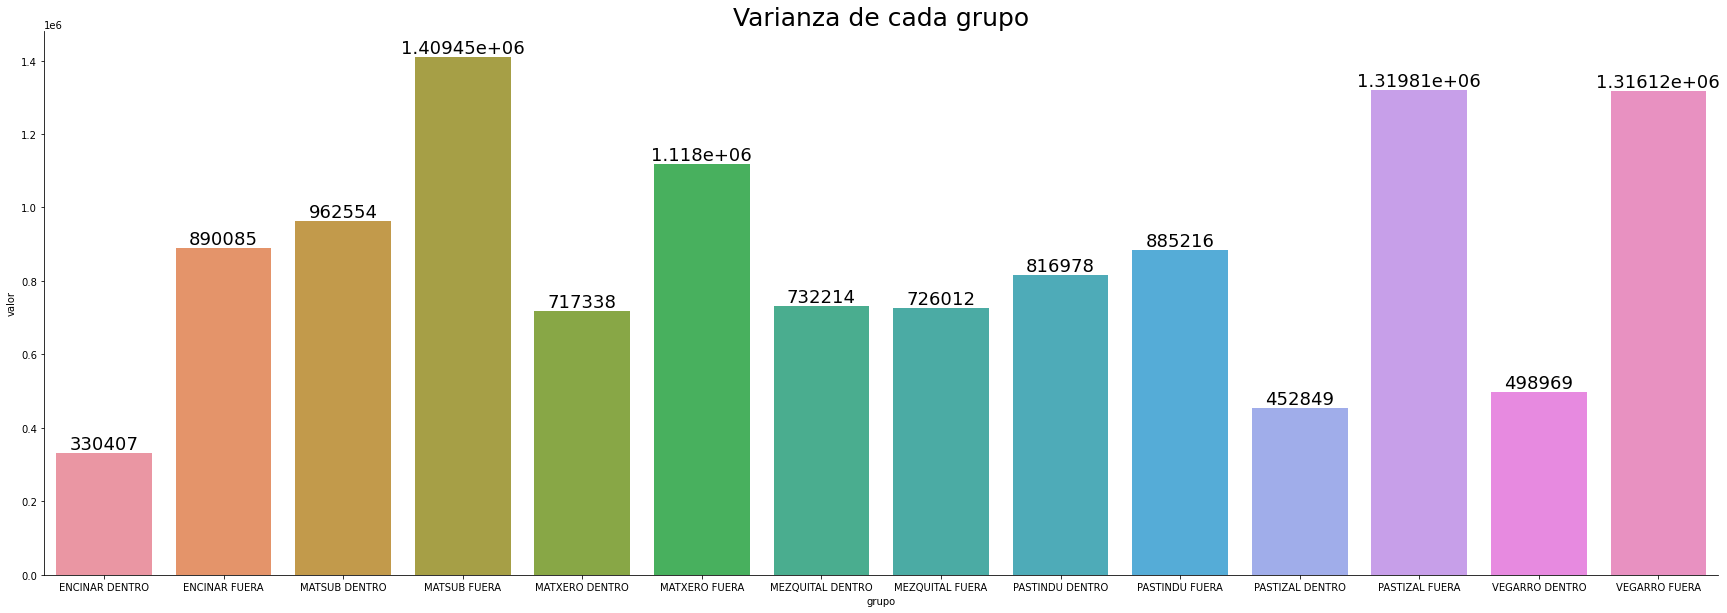

In [222]:
graficar_varianzas_intergrupos(temp_hum_ndvi, 'grupo', 'valor')

In [223]:
print(prueba_levene(temp_hum_ndvi, 'grupo', 'valor'))

LeveneResult(statistic=27.37470801752077, pvalue=2.3046144580980008e-64)


Tampoco la homogeneidad de varianzas se cumple. Por lo tanto, un ANOVA no sería apropiado

#### Kruskal-Wallis

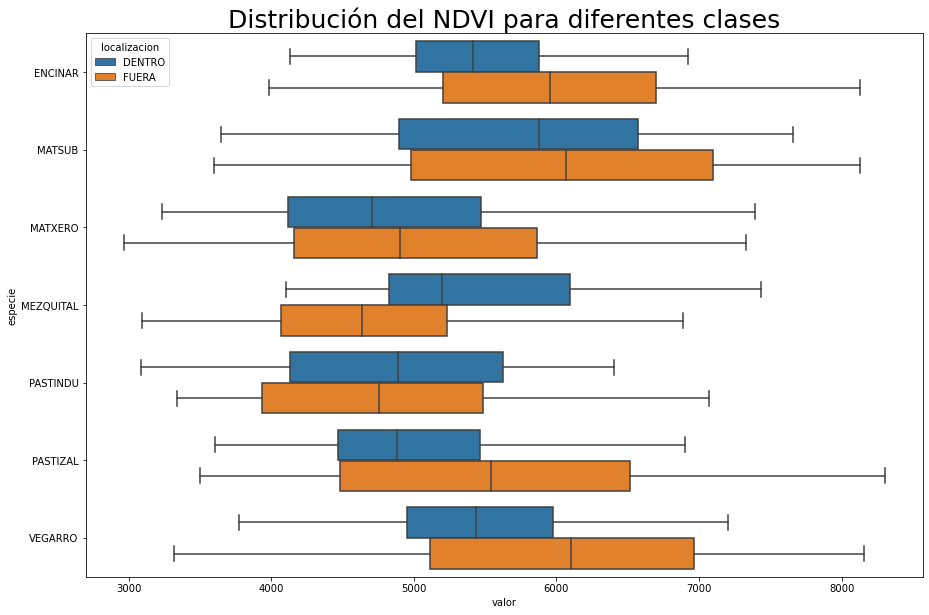

In [224]:
boxplots_variable_intergrupos(temp_hum_ndvi, 'Distribución del NDVI para diferentes clases', 'valor', 'especie', 'localizacion')

In [225]:
print(prueba_kruskal_wallis(temp_hum_ndvi, 'grupo', 'valor'))

KruskalResult(statistic=582.9030131454119, pvalue=3.3756629957313543e-116)


#### Pruebas Post Hoc: Tukey HSD

In [226]:
obj_tukey, _, comparaciones_dentro_fuera = prueba_tukey(temp_hum_ndvi, 'grupo', 'valor', 'especie')
comparaciones_dentro_fuera

0             group1           group2  meandiff   p-adj      lower     upper  \
1     ENCINAR DENTRO    ENCINAR FUERA  495.3899   0.001   206.9368   783.843   
26     MATSUB DENTRO     MATSUB FUERA  291.7889  0.0454     2.6802  580.8976   
47    MATXERO DENTRO    MATXERO FUERA  191.1104  0.6608  -111.1893  493.4102   
64  MEZQUITAL DENTRO  MEZQUITAL FUERA -779.9708   0.001 -1375.4731 -184.4685   
77   PASTINDU DENTRO   PASTINDU FUERA  -87.5315     0.9  -498.9599   323.897   
86   PASTIZAL DENTRO   PASTIZAL FUERA  551.6023   0.001   320.4218  782.7828   
91    VEGARRO DENTRO    VEGARRO FUERA  585.9666   0.001   225.8478  946.0853   

0  reject  
1    True  
26   True  
47  False  
64   True  
77  False  
86   True  
91   True

Text(0.5, 1.0, 'Intervalos de confianza para la media de cada grupo')

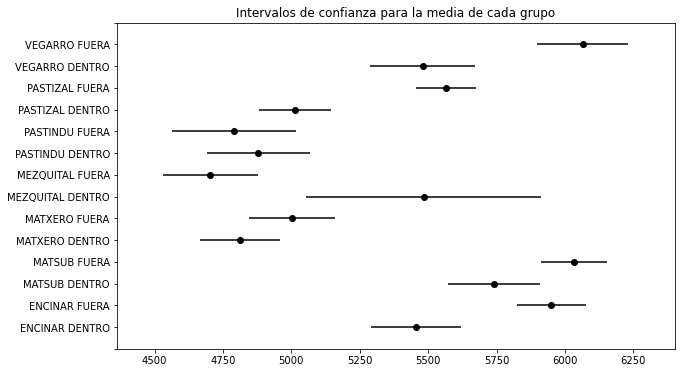

In [227]:
fig , ax = plt.subplots(1,1,figsize=(15,10))

_ = obj_tukey.plot_simultaneous(ax=ax)
ax.set_title('Intervalos de confianza para la media de cada grupo')

### INICIO DE LA TEMPORADA

#### EVI

In [228]:
ts_evi['GRUPO'] = ts_evi.CLASE_VEG + ' ' + ts_evi.LOCALIZACION
ts_evi.head()

CLASE_VEG  INICIO  AMPLITUD  DURACION  INTMAY  INTMEN LOCALIZACION  \
0   ENCINAR  172.96      1987   167.360   32030   13410       DENTRO   
1   ENCINAR  172.96      1972   148.272   30020   12640       DENTRO   
2   ENCINAR  192.16      1782   133.152   24720   10770       DENTRO   
3   ENCINAR  207.36      2162   258.880   41990   16480       DENTRO   
4   ENCINAR  203.20      1629   268.640   40850   14580       DENTRO   

            GRUPO  
0  ENCINAR DENTRO  
1  ENCINAR DENTRO  
2  ENCINAR DENTRO  
3  ENCINAR DENTRO  
4  ENCINAR DENTRO

##### Localización de datos atípicos

Revisamos si existen datos atípicos

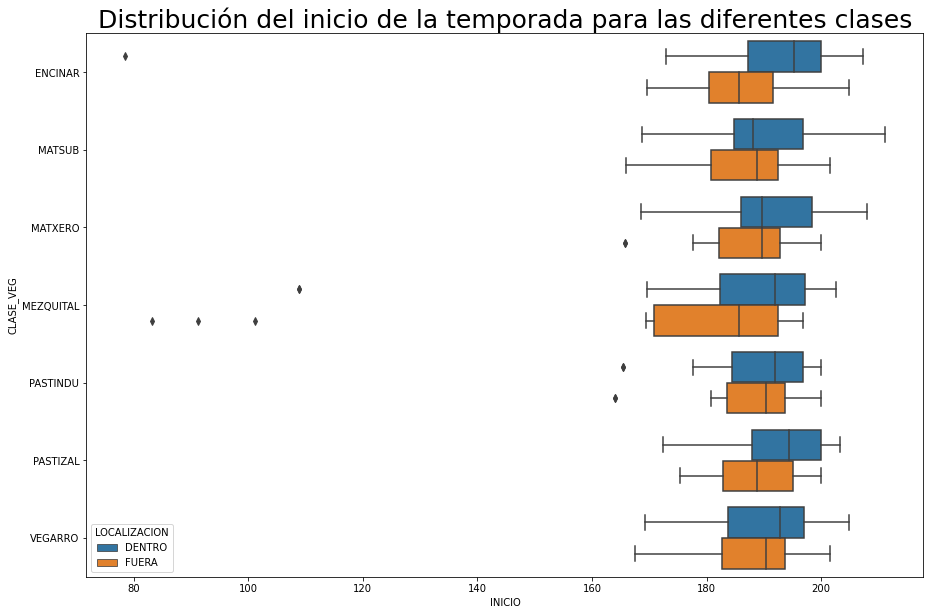

In [229]:
boxplots_variable_intergrupos(
    ts_evi, 
    'Distribución del inicio de la temporada para las diferentes clases', 
    'INICIO', 
    'CLASE_VEG', 
    'LOCALIZACION'
)

# de outliers identificados: 12


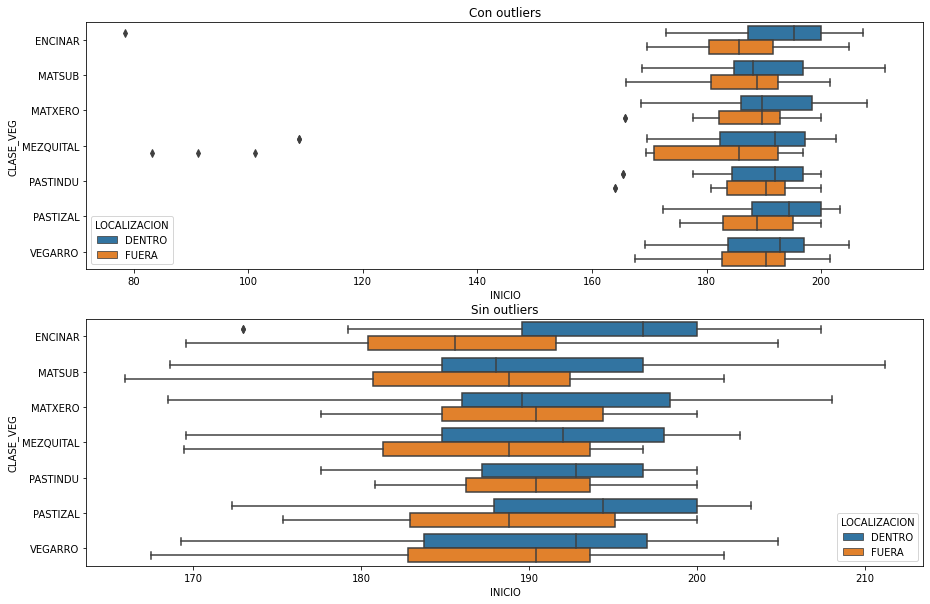

In [230]:
ts_evi['outlier'] = 0
idx_col_outliers = ts_evi.columns.to_list().index('outlier')

identificacion_outliers(
    ts_evi,
    'GRUPO',
    'INICIO',
    idx_col_outliers,
    'CLASE_VEG',
    'LOCALIZACION'
)

##### Conteo del número de observaciones por grupo

Revisamos el número de muestras en cada grupo

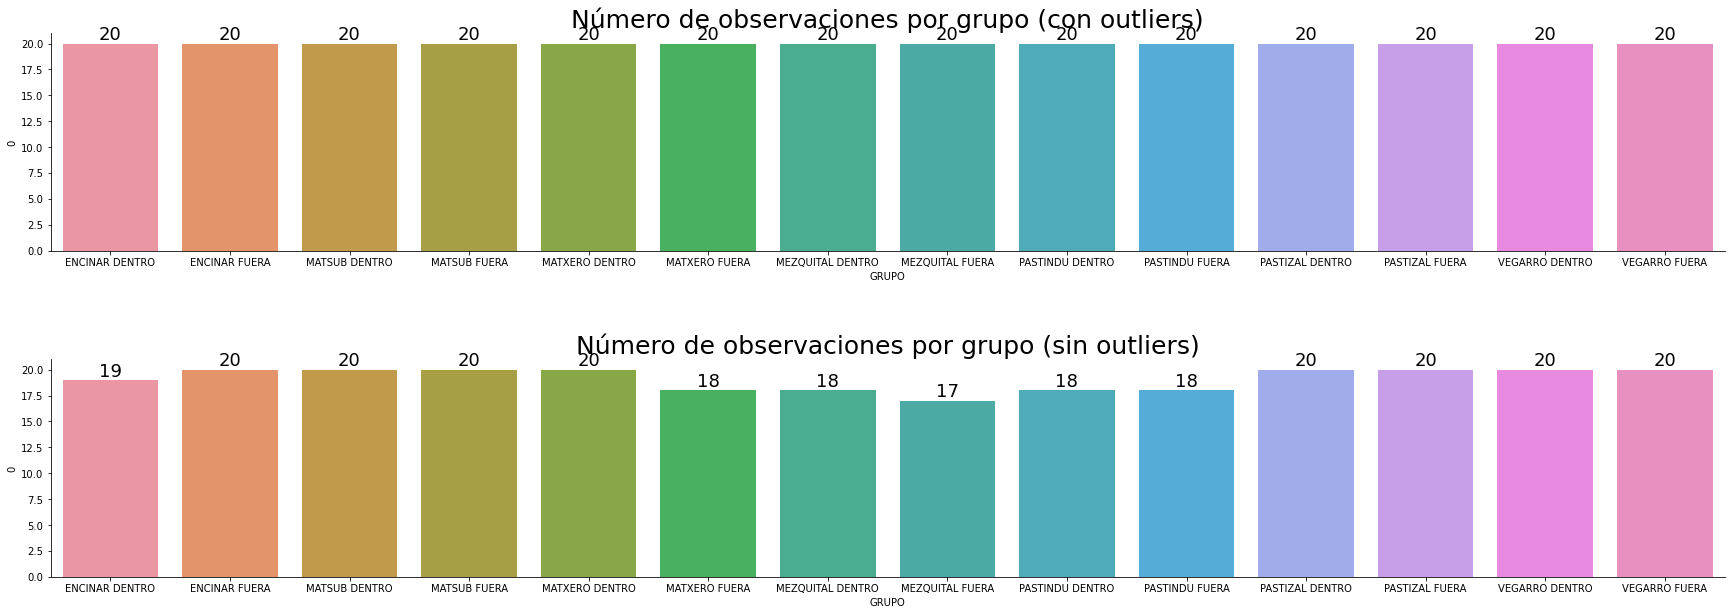

In [231]:
revisar_num_muestras_por_grupo(ts_evi, 'GRUPO', idx_col_outliers)

##### Revisión del supuesto de normalidad

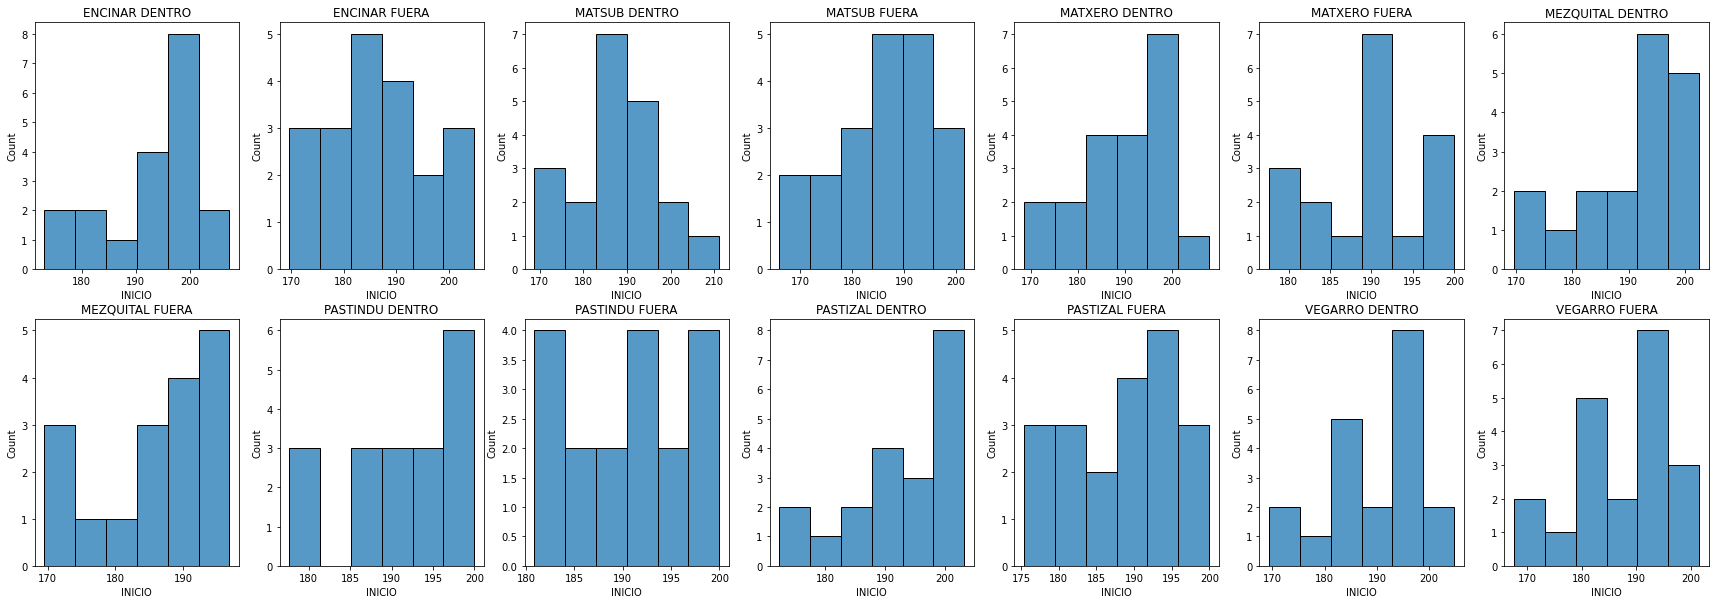

In [232]:
ts_evi = ts_evi[ts_evi.outlier == 0].copy()
histogramas_por_clase(ts_evi, 'GRUPO', 'INICIO')

In [233]:
resultados_test_norm = pruebas_normalidad_shapiro(ts_evi, 'GRUPO', 'INICIO')
resultados_test_norm[resultados_test_norm.pvalor > .05]

grupo         W    pvalor
0     ENCINAR DENTRO  0.900714  0.050121
1      ENCINAR FUERA  0.978283  0.910054
2      MATSUB DENTRO  0.966447  0.678787
3       MATSUB FUERA  0.939602  0.235656
4     MATXERO DENTRO  0.937012  0.210422
5      MATXERO FUERA  0.944210  0.341496
6   MEZQUITAL DENTRO  0.898516  0.054140
8    PASTINDU DENTRO  0.914158  0.101878
9     PASTINDU FUERA  0.944354  0.343398
11    PASTIZAL FUERA  0.951447  0.389584
12    VEGARRO DENTRO  0.923023  0.113304
13     VEGARRO FUERA  0.919608  0.097378

##### Revisión del supuesto de homogeneidad de varianzas

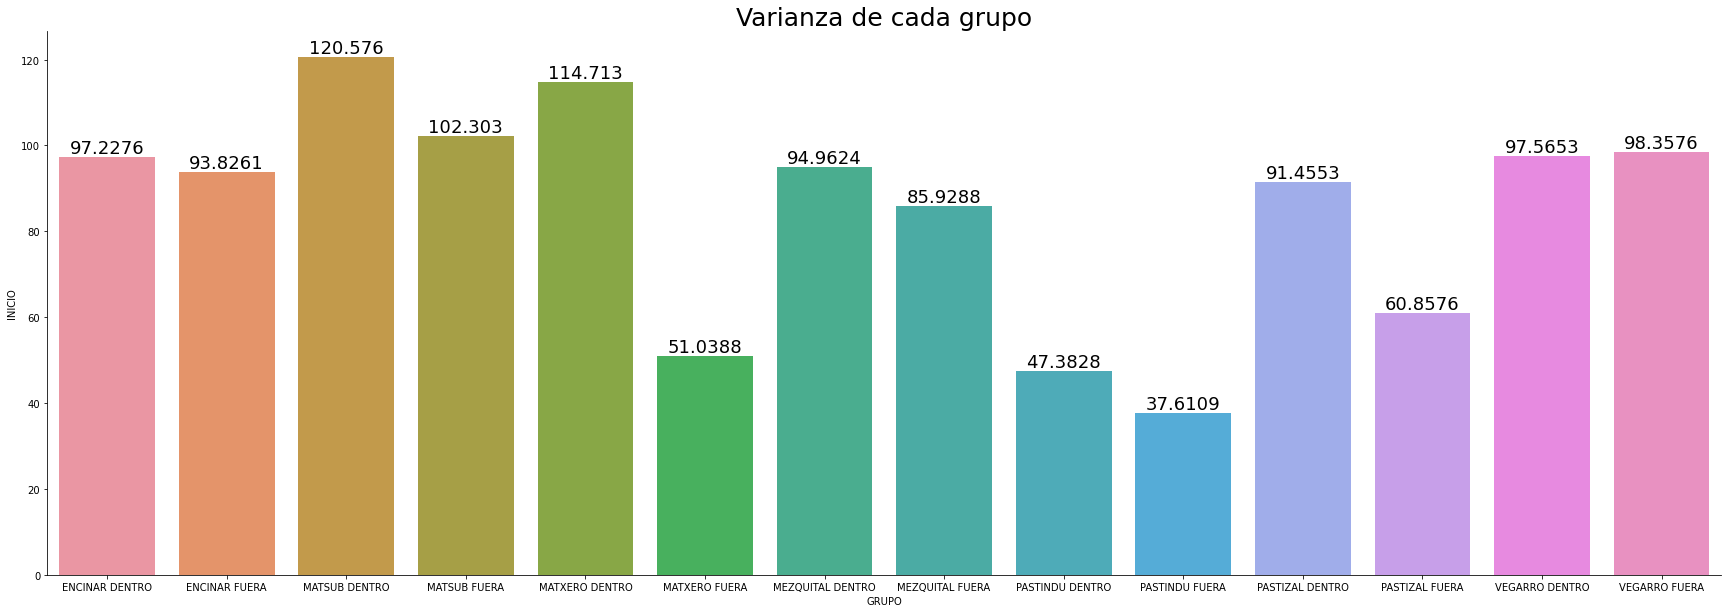

In [234]:
graficar_varianzas_intergrupos(ts_evi, 'GRUPO', 'INICIO')

In [235]:
print(prueba_levene(ts_evi, 'GRUPO', 'INICIO'))

LeveneResult(statistic=0.5958595075886648, pvalue=0.8567305931136246)


##### Análisis de varianza

In [236]:
# Ordinary Least Squares (OLS) model
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('INICIO ~ C(GRUPO)', data=ts_evi).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

             df        sum_sq    mean_sq         F    PR(>F)
C(GRUPO)   13.0   1124.425724  86.494286  1.004767  0.446999
Residual  254.0  21865.310395  86.083899       NaN       NaN


Text(0.5, 1.0, 'QQPLOT DE LOS RESIDUALES ESTANDARIZADOS')

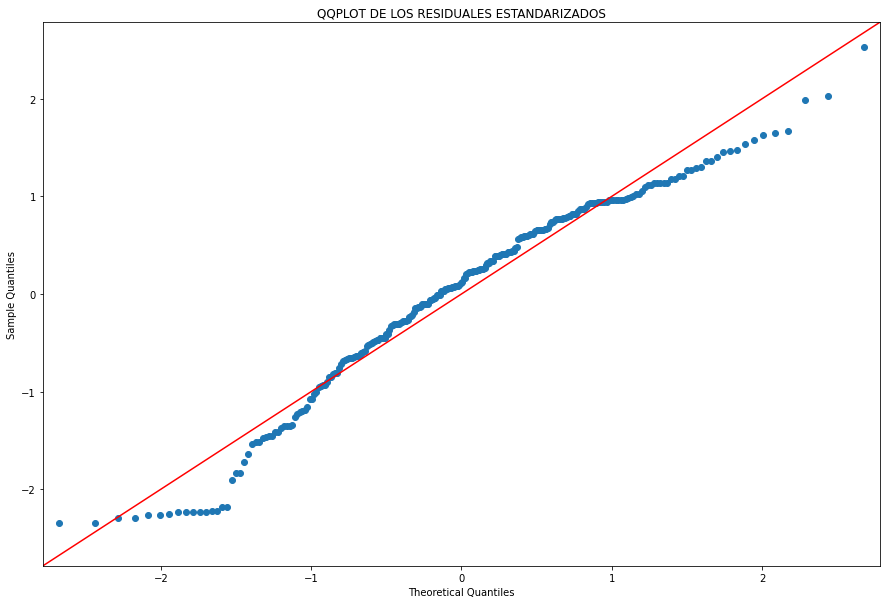

In [237]:
resid_standard = model.get_influence().resid_studentized_internal

fig , ax = plt.subplots(1,1,figsize=(15,10))
_ = sm.qqplot(resid_standard, line='45', ax=ax)
ax.set_title('QQPLOT DE LOS RESIDUALES ESTANDARIZADOS')

In [238]:
stats.shapiro(resid_standard)

ShapiroResult(statistic=0.9638811349868774, pvalue=2.936109922302421e-06)

##### Kruskal-Wallis

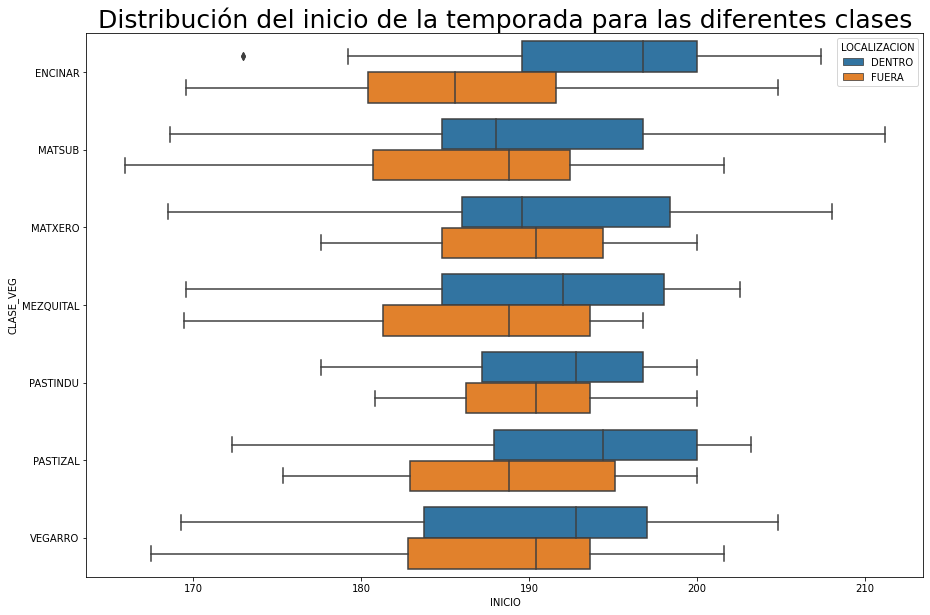

In [239]:
boxplots_variable_intergrupos(ts_evi, 'Distribución del inicio de la temporada para las diferentes clases', 'INICIO', 'CLASE_VEG', 'LOCALIZACION')

In [240]:
print(prueba_kruskal_wallis(ts_evi, 'GRUPO', 'INICIO'))

KruskalResult(statistic=14.698805572299909, pvalue=0.32653114579408526)


##### Pruebas Post Hoc: Tukey HSD

In [241]:
obj_tukey, _, comparaciones_dentro_fuera = prueba_tukey(ts_evi, 'GRUPO', 'INICIO', 'CLASE_VEG')
comparaciones_dentro_fuera

0             group1           group2 meandiff   p-adj    lower   upper reject
1     ENCINAR DENTRO    ENCINAR FUERA  -6.2303  0.6769 -16.2968  3.8362  False
26     MATSUB DENTRO     MATSUB FUERA   -1.696     0.9 -11.6326  8.2406  False
47    MATXERO DENTRO    MATXERO FUERA   0.0551     0.9 -10.1538  10.264  False
64  MEZQUITAL DENTRO  MEZQUITAL FUERA  -3.9618     0.9 -14.5888  6.6652  False
77   PASTINDU DENTRO   PASTINDU FUERA  -0.7289     0.9  -11.203  9.7452  False
86   PASTIZAL DENTRO   PASTIZAL FUERA   -4.032     0.9 -13.9686  5.9046  False
91    VEGARRO DENTRO    VEGARRO FUERA   -2.056     0.9 -11.9926  7.8806  False

Text(0.5, 1.0, 'Intervalos de confianza para la media de cada grupo')

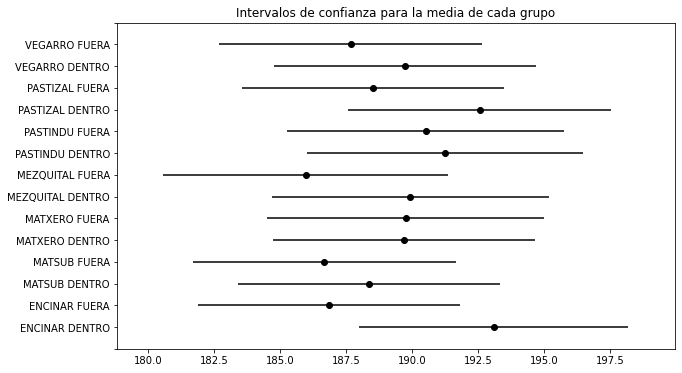

In [242]:
fig , ax = plt.subplots(1,1,figsize=(15,10))

_ = obj_tukey.plot_simultaneous(ax=ax)
ax.set_title('Intervalos de confianza para la media de cada grupo')

#### NDVI

In [243]:
ts_ndvi['GRUPO'] = ts_ndvi.CLASE_VEG + ' ' + ts_ndvi.LOCALIZACION
ts_ndvi.head()

CLASE_VEG  INICIO  AMPLITUD  DURACION  INTMAY  INTMEN LOCALIZACION  \
0   ENCINAR  177.44      3145    230.56   70050   33880       DENTRO   
1   ENCINAR  177.44      3019    302.40   89970   42230       DENTRO   
2   ENCINAR  187.04      2814    286.08   79660   33570       DENTRO   
3   ENCINAR  206.40      3614    277.76   83110   39800       DENTRO   
4   ENCINAR  201.60      2878    292.16   81110   36720       DENTRO   

            GRUPO  
0  ENCINAR DENTRO  
1  ENCINAR DENTRO  
2  ENCINAR DENTRO  
3  ENCINAR DENTRO  
4  ENCINAR DENTRO

##### Localización de datos atípicos

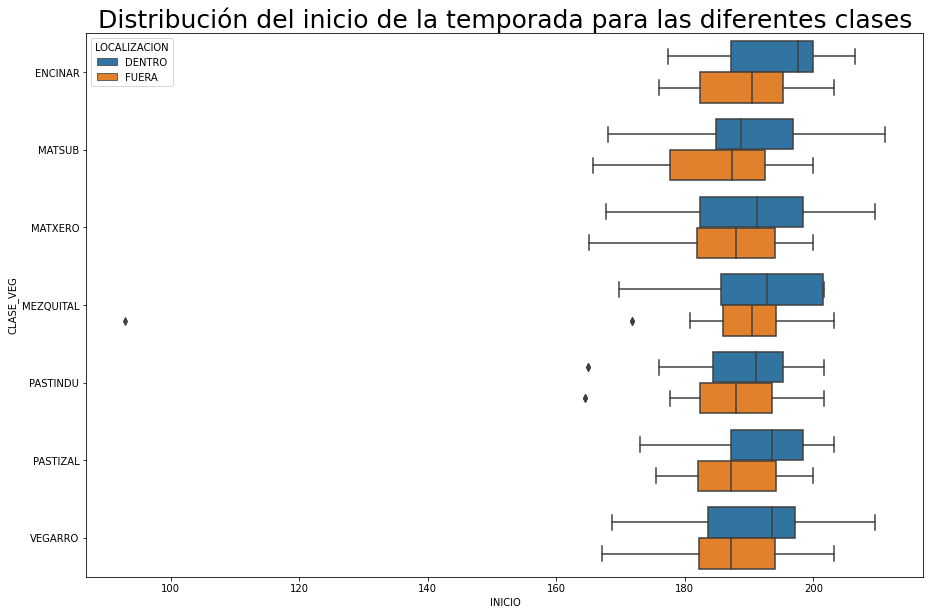

In [244]:
boxplots_variable_intergrupos(
    ts_ndvi, 
    'Distribución del inicio de la temporada para las diferentes clases', 
    'INICIO', 
    'CLASE_VEG', 
    'LOCALIZACION'
)

# de outliers identificados: 7


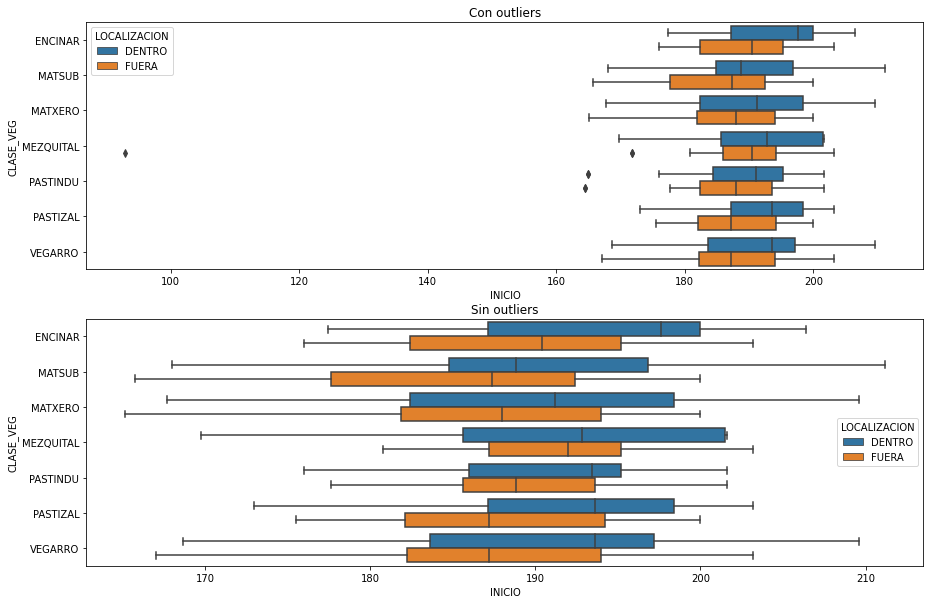

In [245]:
ts_ndvi['outlier'] = 0
idx_col_outliers = ts_ndvi.columns.to_list().index('outlier')

identificacion_outliers(
    ts_ndvi,
    'GRUPO',
    'INICIO',
    idx_col_outliers,
    'CLASE_VEG',
    'LOCALIZACION'
)

##### Conteo del número de observaciones por grupo

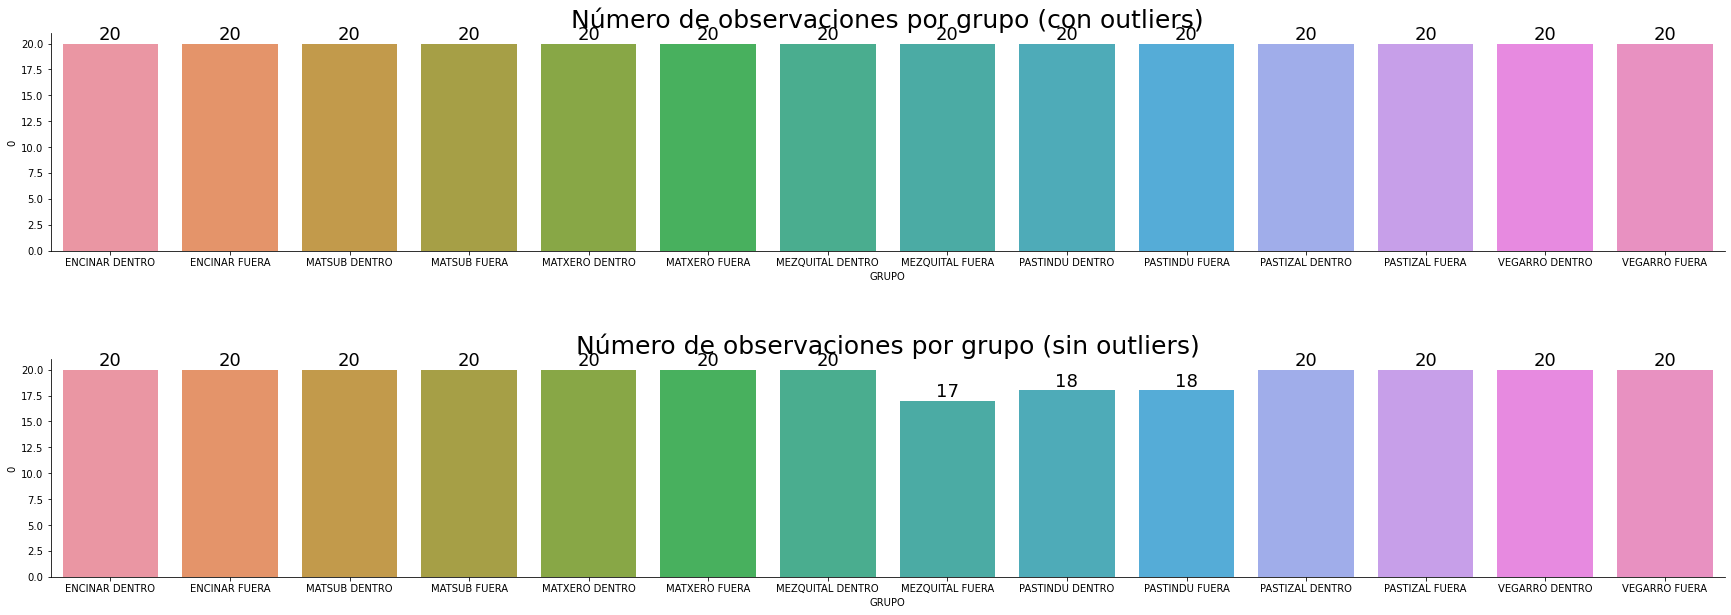

In [246]:
revisar_num_muestras_por_grupo(ts_ndvi, 'GRUPO', idx_col_outliers)

##### Revisión del supuesto de normalidad

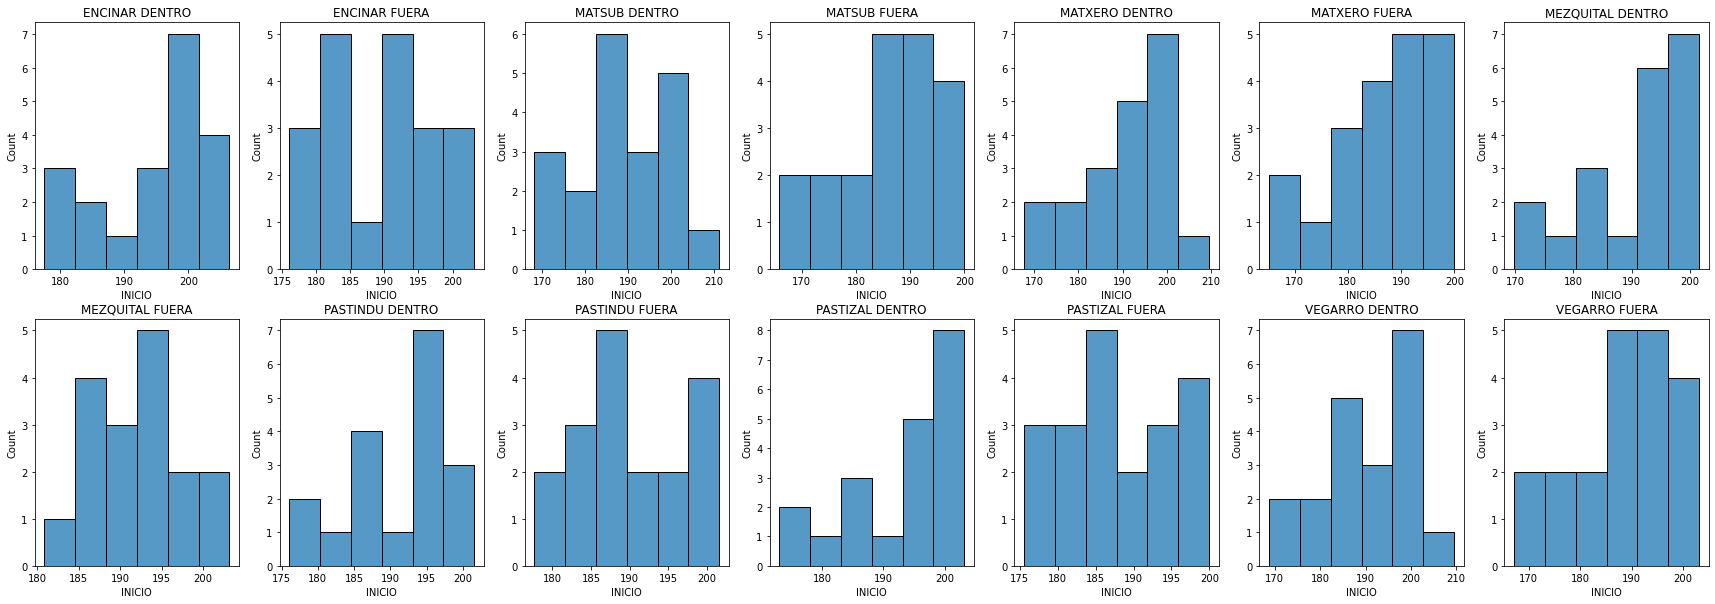

In [247]:
ts_ndvi = ts_ndvi[ts_ndvi.outlier == 0].copy()
histogramas_por_clase(ts_ndvi, 'GRUPO', 'INICIO')

In [248]:
resultados_test_norm = pruebas_normalidad_shapiro(ts_ndvi, 'GRUPO', 'INICIO')
resultados_test_norm[resultados_test_norm.pvalor > .05]

grupo         W    pvalor
1     ENCINAR FUERA  0.948538  0.345436
2     MATSUB DENTRO  0.954693  0.443963
3      MATSUB FUERA  0.934936  0.192066
4    MATXERO DENTRO  0.945483  0.303674
5     MATXERO FUERA  0.924212  0.119445
7   MEZQUITAL FUERA  0.989496  0.998660
8   PASTINDU DENTRO  0.947757  0.390921
9    PASTINDU FUERA  0.958071  0.564861
11   PASTIZAL FUERA  0.950109  0.368755
12   VEGARRO DENTRO  0.951691  0.393483
13    VEGARRO FUERA  0.948400  0.343450

##### Revisión del supuesto de homogeneidad de varianzas

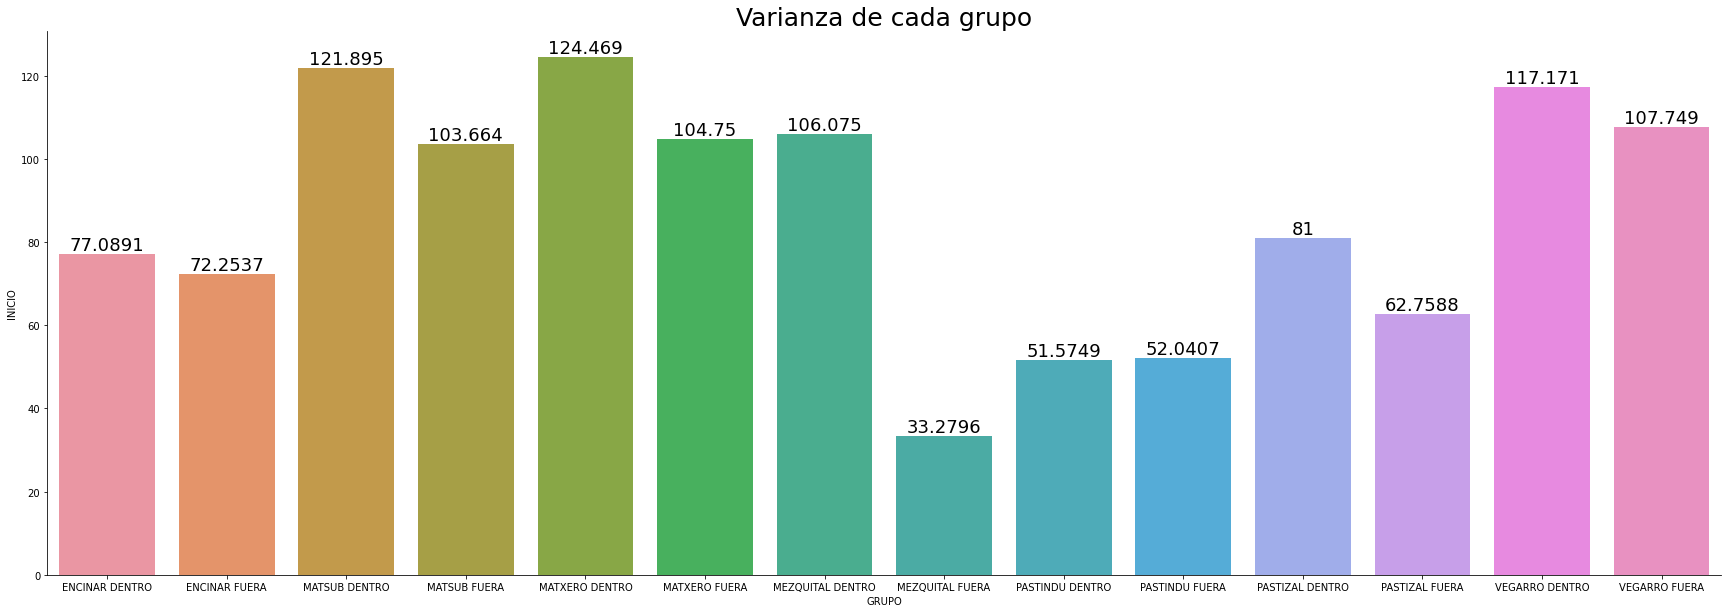

In [249]:
graficar_varianzas_intergrupos(ts_ndvi, 'GRUPO', 'INICIO')

In [250]:
print(prueba_levene(ts_ndvi, 'GRUPO', 'INICIO'))

LeveneResult(statistic=0.7551752241282825, pvalue=0.7070593675155972)


##### Análisis de varianza

In [251]:
# Ordinary Least Squares (OLS) model
model = ols('INICIO ~ C(GRUPO)', data=ts_ndvi).fit()

anova_table = sm.stats.anova_lm(model)
print(anova_table)

             df        sum_sq     mean_sq         F    PR(>F)
C(GRUPO)   13.0   1306.591139  100.507011  1.142098  0.323799
Residual  259.0  22792.550065   88.002124       NaN       NaN


Text(0.5, 1.0, 'QQPLOTR DE LOS RESIDUALES ESTANDARIZADOS')

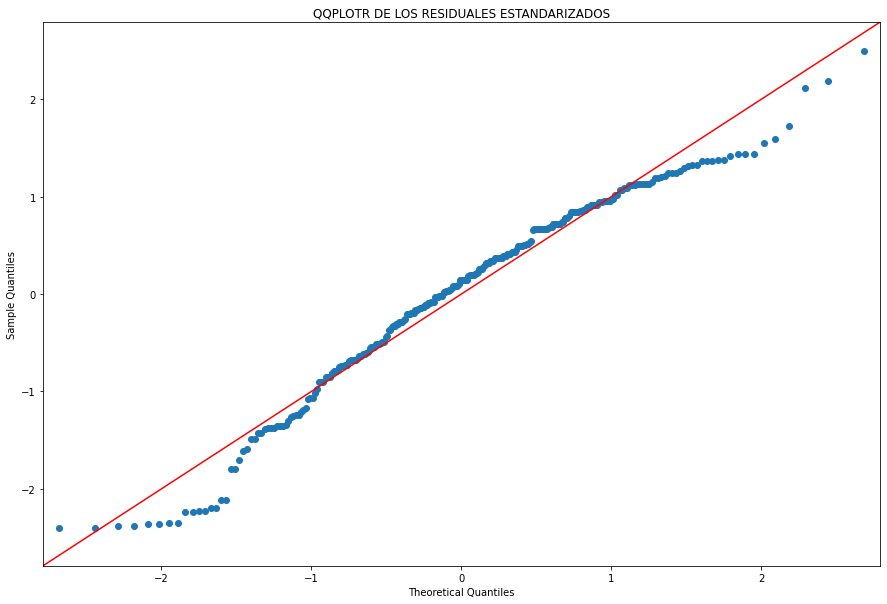

In [252]:
resid_standard = model.get_influence().resid_studentized_internal

fig , ax = plt.subplots(1,1,figsize=(15,10))
_ = sm.qqplot(resid_standard, line='45', ax=ax)
ax.set_title('QQPLOTR DE LOS RESIDUALES ESTANDARIZADOS')

In [253]:
stats.shapiro(resid_standard)

ShapiroResult(statistic=0.9693281054496765, pvalue=1.3875413060304709e-05)

##### Kruskal-Wallis

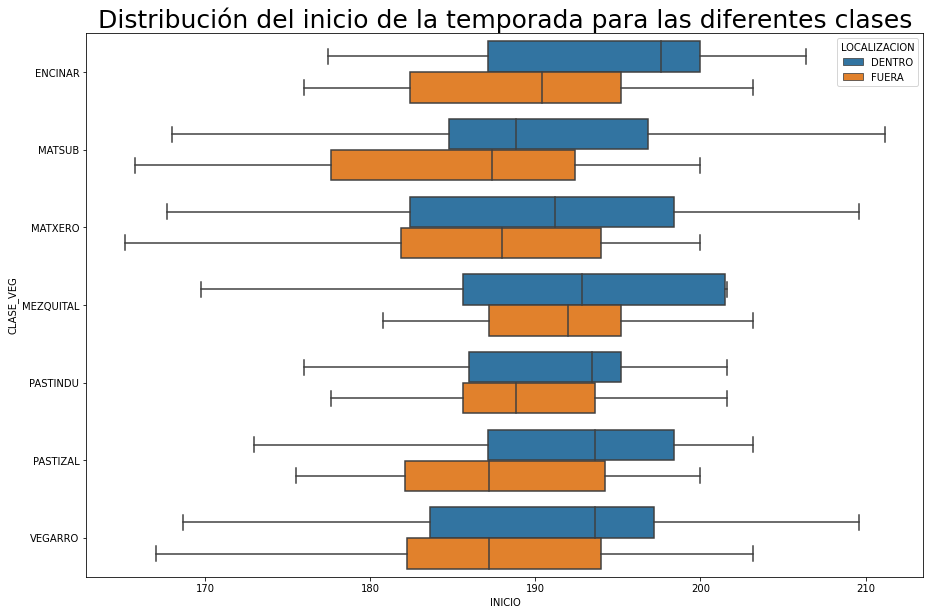

In [254]:
boxplots_variable_intergrupos(ts_ndvi, 'Distribución del inicio de la temporada para las diferentes clases', 'INICIO', 'CLASE_VEG', 'LOCALIZACION')

In [255]:
print(prueba_kruskal_wallis(ts_ndvi, 'GRUPO', 'INICIO'))

KruskalResult(statistic=15.407464644578344, pvalue=0.2826105312582419)


##### Pruebas Post Hoc: Tukey HSD

In [256]:
obj_tukey, _, comparaciones_dentro_fuera = prueba_tukey(ts_ndvi, 'GRUPO', 'INICIO', 'CLASE_VEG')
comparaciones_dentro_fuera

0             group1           group2 meandiff   p-adj    lower    upper  \
1     ENCINAR DENTRO    ENCINAR FUERA   -5.272  0.8777 -15.3168   4.7728   
26     MATSUB DENTRO     MATSUB FUERA   -2.544     0.9 -12.5888   7.5008   
47    MATXERO DENTRO    MATXERO FUERA   -2.752     0.9 -12.7968   7.2928   
64  MEZQUITAL DENTRO  MEZQUITAL FUERA   0.6188     0.9  -9.8598  11.0974   
77   PASTINDU DENTRO   PASTINDU FUERA  -0.7289     0.9  -11.317   9.8592   
86   PASTIZAL DENTRO   PASTIZAL FUERA   -4.384     0.9 -14.4288   5.6608   
91    VEGARRO DENTRO    VEGARRO FUERA   -2.832     0.9 -12.8768   7.2128   

0  reject  
1   False  
26  False  
47  False  
64  False  
77  False  
86  False  
91  False

Text(0.5, 1.0, 'Intervalos de confianza para la media de cada grupo')

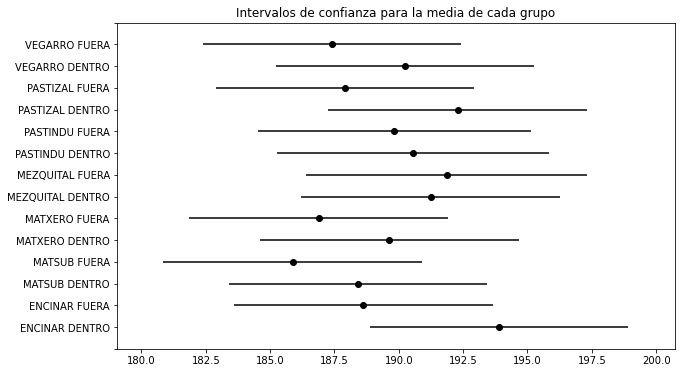

In [257]:
fig , ax = plt.subplots(1,1,figsize=(15,10))

_ = obj_tukey.plot_simultaneous(ax=ax)
ax.set_title('Intervalos de confianza para la media de cada grupo')

### DURACIÓN DE LA TEMPORADA

#### EVI

In [258]:
ts_evi = pd.read_excel(datasets[0], usecols=columnas_importantes)
ts_evi = preparar_dataframe(ts_evi)
ts_evi['GRUPO'] = ts_evi.CLASE_VEG + ' ' + ts_evi.LOCALIZACION
ts_evi.head()

CLASE_VEG  INICIO  AMPLITUD  DURACION  INTMAY  INTMEN LOCALIZACION  \
0   ENCINAR  172.96      1987   167.360   32030   13410       DENTRO   
1   ENCINAR  172.96      1972   148.272   30020   12640       DENTRO   
2   ENCINAR  192.16      1782   133.152   24720   10770       DENTRO   
3   ENCINAR  207.36      2162   258.880   41990   16480       DENTRO   
4   ENCINAR  203.20      1629   268.640   40850   14580       DENTRO   

            GRUPO  
0  ENCINAR DENTRO  
1  ENCINAR DENTRO  
2  ENCINAR DENTRO  
3  ENCINAR DENTRO  
4  ENCINAR DENTRO

##### Localización de datos atípicos

Revisamos si existen datos atípicos

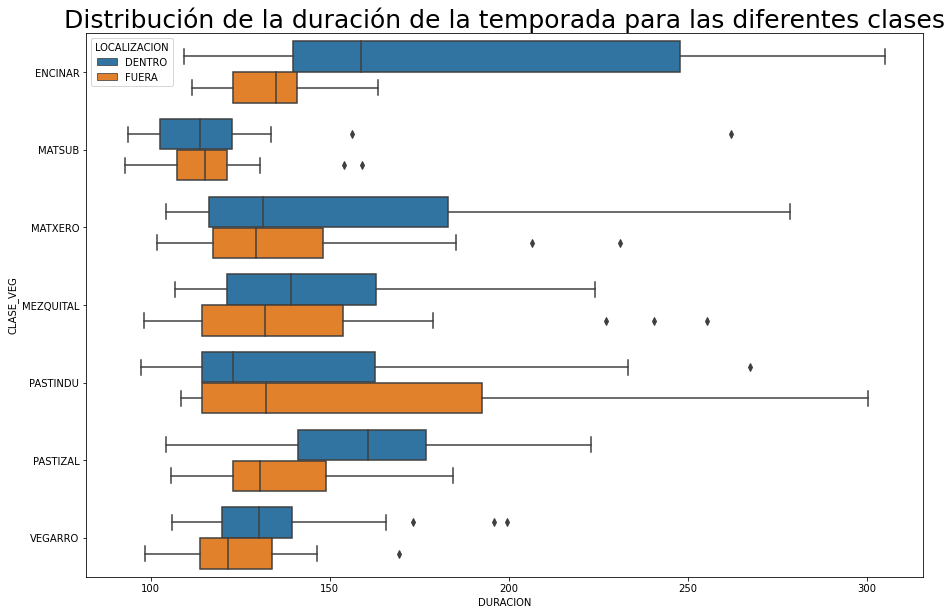

In [259]:
boxplots_variable_intergrupos(
    ts_evi, 
    'Distribución de la duración de la temporada para las diferentes clases', 
    'DURACION', 
    'CLASE_VEG', 
    'LOCALIZACION'
)

# de outliers identificados: 14


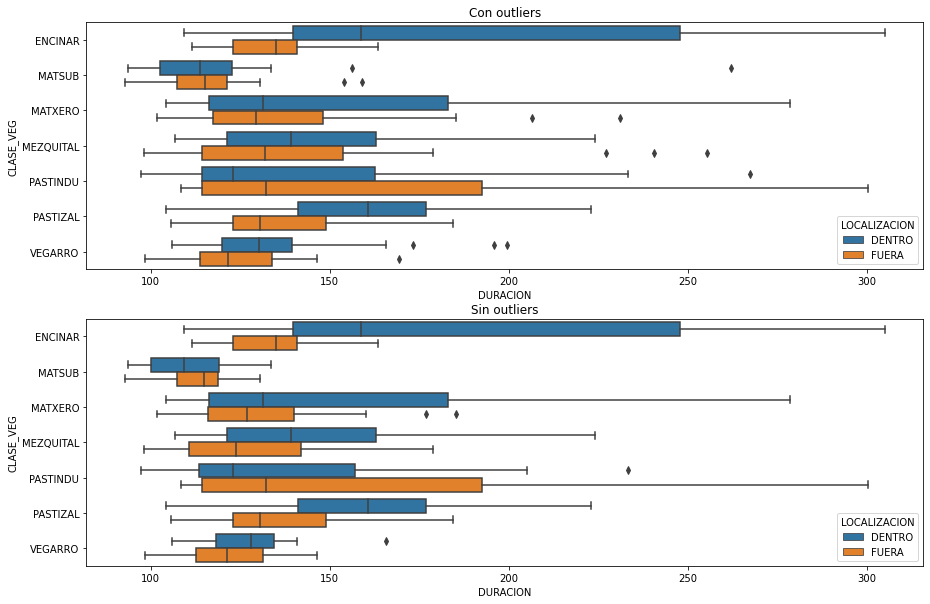

In [260]:
ts_evi['outlier'] = 0
idx_col_outliers = ts_evi.columns.to_list().index('outlier')

identificacion_outliers(
    ts_evi,
    'GRUPO',
    'DURACION',
    idx_col_outliers,
    'CLASE_VEG',
    'LOCALIZACION'
)

##### Conteo del número de observaciones por grupo

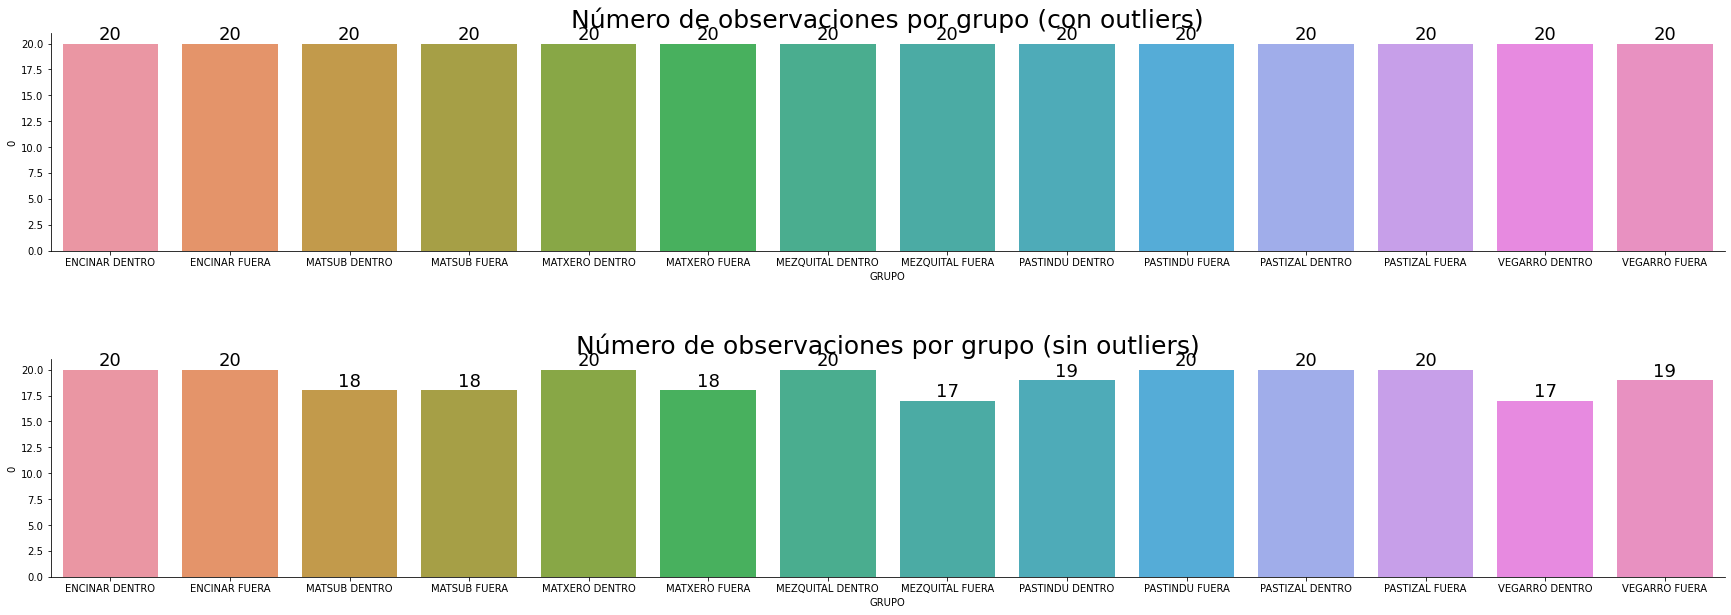

In [261]:
revisar_num_muestras_por_grupo(ts_evi, 'GRUPO', idx_col_outliers)

##### Revisión del supuesto de normalidad

Ahora se revisará el supuesto de normalidad

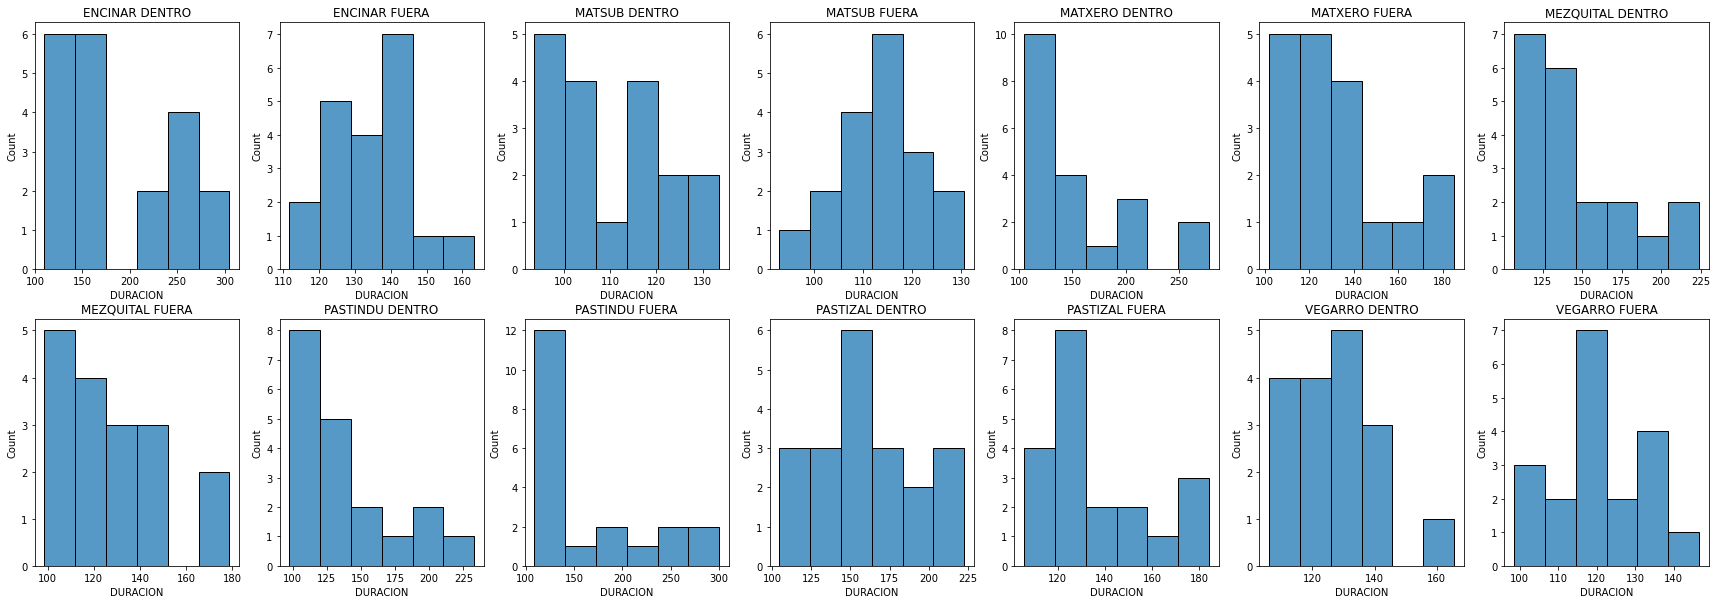

In [262]:
ts_evi = ts_evi[ts_evi.outlier == 0].copy()
histogramas_por_clase(ts_evi, 'GRUPO', 'DURACION')

In [263]:
resultados_test_norm = pruebas_normalidad_shapiro(ts_evi, 'GRUPO', 'DURACION')
resultados_test_norm[resultados_test_norm.pvalor > .05]

grupo         W    pvalor
1     ENCINAR FUERA  0.964503  0.637149
2     MATSUB DENTRO  0.948246  0.398163
3      MATSUB FUERA  0.981831  0.966908
7   MEZQUITAL FUERA  0.931195  0.227883
10  PASTIZAL DENTRO  0.965506  0.658570
11   PASTIZAL FUERA  0.916681  0.085545
12   VEGARRO DENTRO  0.939457  0.311799
13    VEGARRO FUERA  0.974817  0.866894

##### Revisión del supuesto de homogeneidad de varianzas

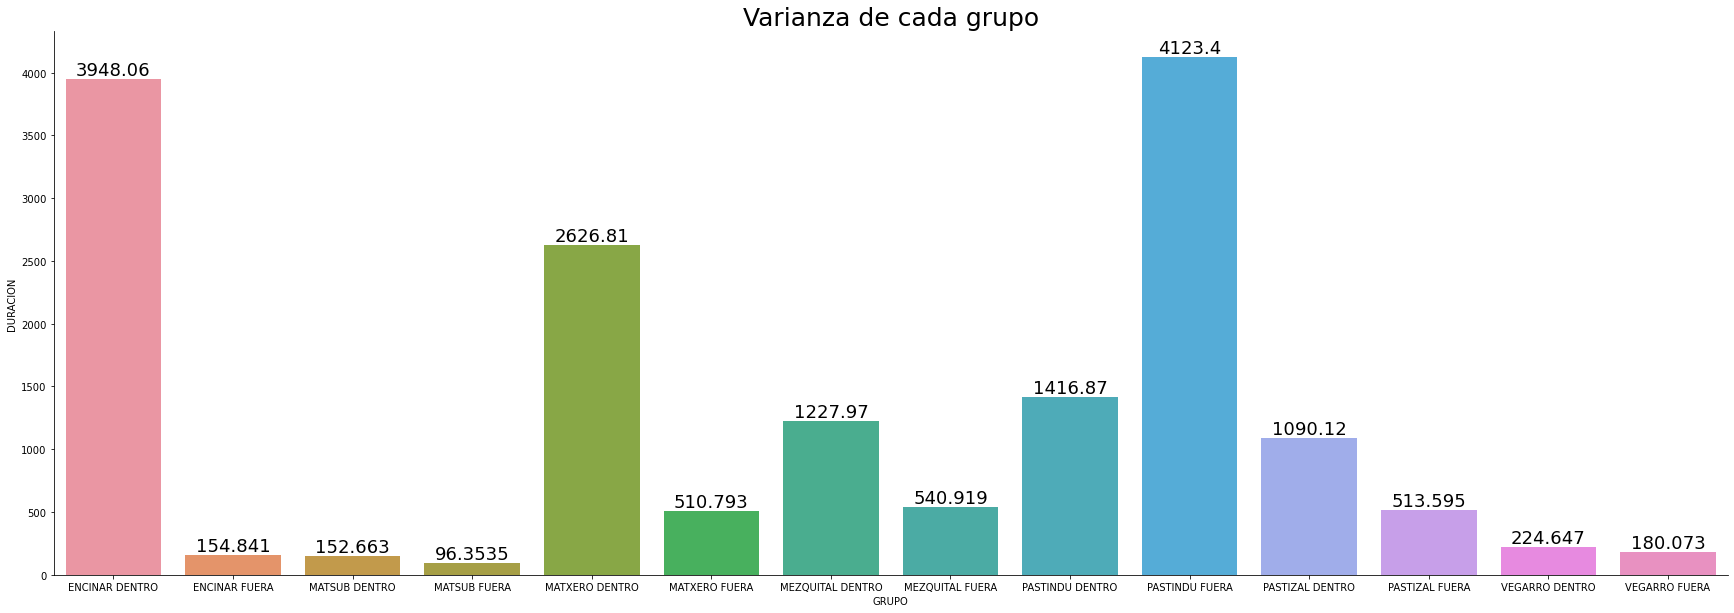

In [264]:
graficar_varianzas_intergrupos(ts_evi, 'GRUPO', 'DURACION')

In [265]:
print(prueba_levene(ts_evi, 'GRUPO', 'DURACION'))

LeveneResult(statistic=5.319336155111819, pvalue=1.9429435578690376e-08)


##### Kruskal-Wallis

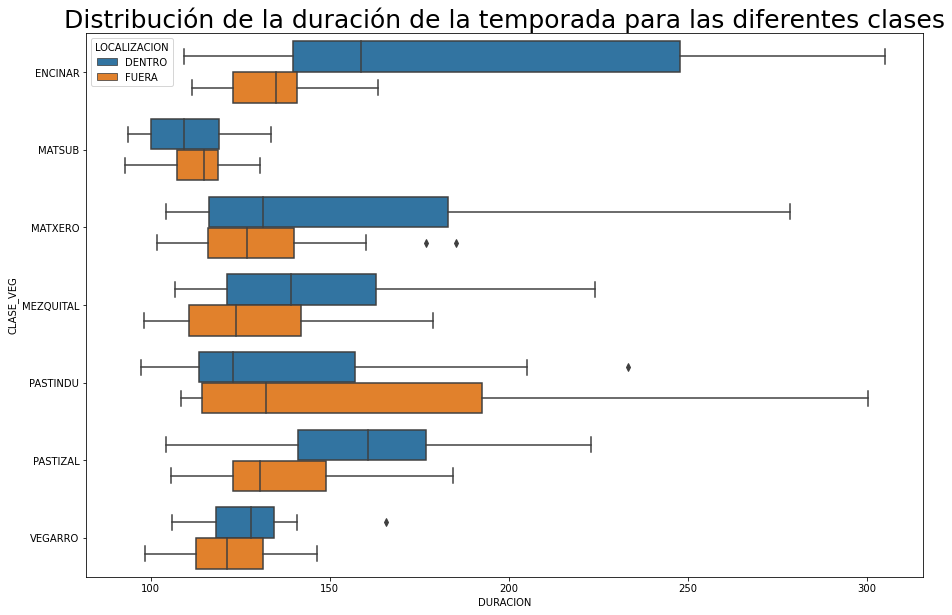

In [266]:
boxplots_variable_intergrupos(ts_evi, 'Distribución de la duración de la temporada para las diferentes clases', 'DURACION', 'CLASE_VEG', 'LOCALIZACION')

In [267]:
print(prueba_kruskal_wallis(ts_evi, 'GRUPO', 'DURACION'))

KruskalResult(statistic=70.81985074302047, pvalue=5.66849084317977e-10)


##### Pruebas Post Hoc: Tukey HSD

In [268]:
obj_tukey, _, comparaciones_dentro_fuera = prueba_tukey(ts_evi, 'GRUPO', 'DURACION', 'CLASE_VEG')
comparaciones_dentro_fuera

0             group1           group2 meandiff   p-adj    lower    upper  \
1     ENCINAR DENTRO    ENCINAR FUERA  -54.204   0.001 -92.0065 -16.4015   
26     MATSUB DENTRO     MATSUB FUERA   2.5333     0.9  -37.314  42.3806   
47    MATXERO DENTRO    MATXERO FUERA -21.8577  0.7964  -60.696  16.9807   
64  MEZQUITAL DENTRO  MEZQUITAL FUERA -18.6527     0.9 -58.0876  20.7823   
77   PASTINDU DENTRO   PASTINDU FUERA  24.1849  0.6499 -14.1118  62.4815   
86   PASTIZAL DENTRO   PASTIZAL FUERA -23.9584  0.6451 -61.7609  13.8441   
91    VEGARRO DENTRO    VEGARRO FUERA  -5.5427     0.9 -45.4517  34.3662   

0  reject  
1    True  
26  False  
47  False  
64  False  
77  False  
86  False  
91  False

Text(0.5, 1.0, 'Intervalos de confianza para la media de cada grupo')

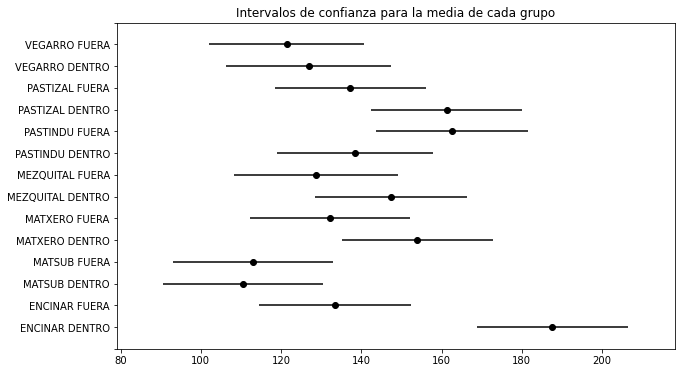

In [269]:
fig , ax = plt.subplots(1,1,figsize=(15,10))

_ = obj_tukey.plot_simultaneous(ax=ax)
ax.set_title('Intervalos de confianza para la media de cada grupo')

#### NDVI

In [270]:
ts_ndvi = pd.read_excel(datasets[1], usecols=columnas_importantes)
ts_ndvi = preparar_dataframe(ts_ndvi)
ts_ndvi['GRUPO'] = ts_ndvi.CLASE_VEG + ' ' + ts_ndvi.LOCALIZACION
ts_ndvi.head()

CLASE_VEG  INICIO  AMPLITUD  DURACION  INTMAY  INTMEN LOCALIZACION  \
0   ENCINAR  177.44      3145    230.56   70050   33880       DENTRO   
1   ENCINAR  177.44      3019    302.40   89970   42230       DENTRO   
2   ENCINAR  187.04      2814    286.08   79660   33570       DENTRO   
3   ENCINAR  206.40      3614    277.76   83110   39800       DENTRO   
4   ENCINAR  201.60      2878    292.16   81110   36720       DENTRO   

            GRUPO  
0  ENCINAR DENTRO  
1  ENCINAR DENTRO  
2  ENCINAR DENTRO  
3  ENCINAR DENTRO  
4  ENCINAR DENTRO

##### Localización de datos atípicos

Revisamos si existen datos atípicos

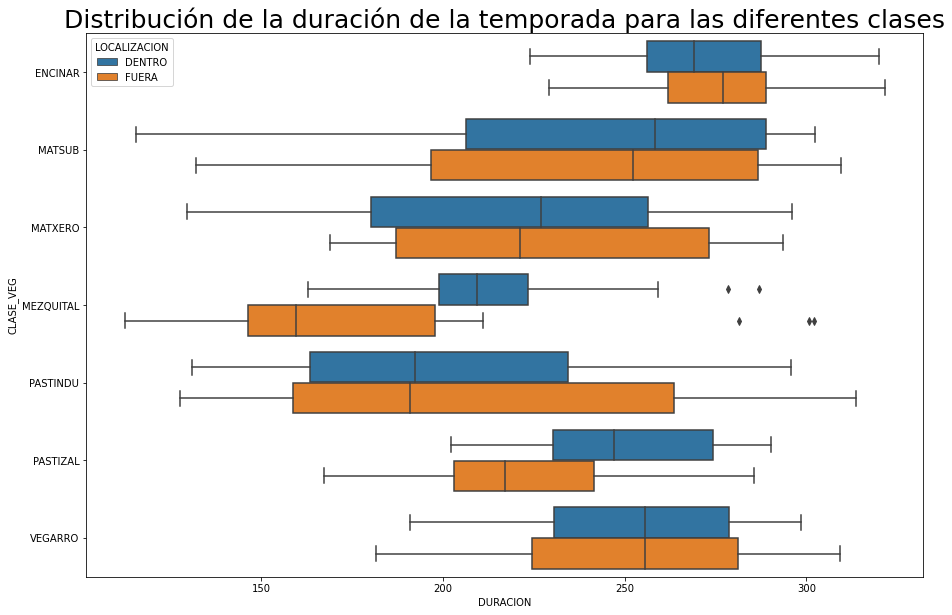

In [271]:
boxplots_variable_intergrupos(
    ts_ndvi, 
    'Distribución de la duración de la temporada para las diferentes clases', 
    'DURACION', 
    'CLASE_VEG', 
    'LOCALIZACION'
)

# de outliers identificados: 5


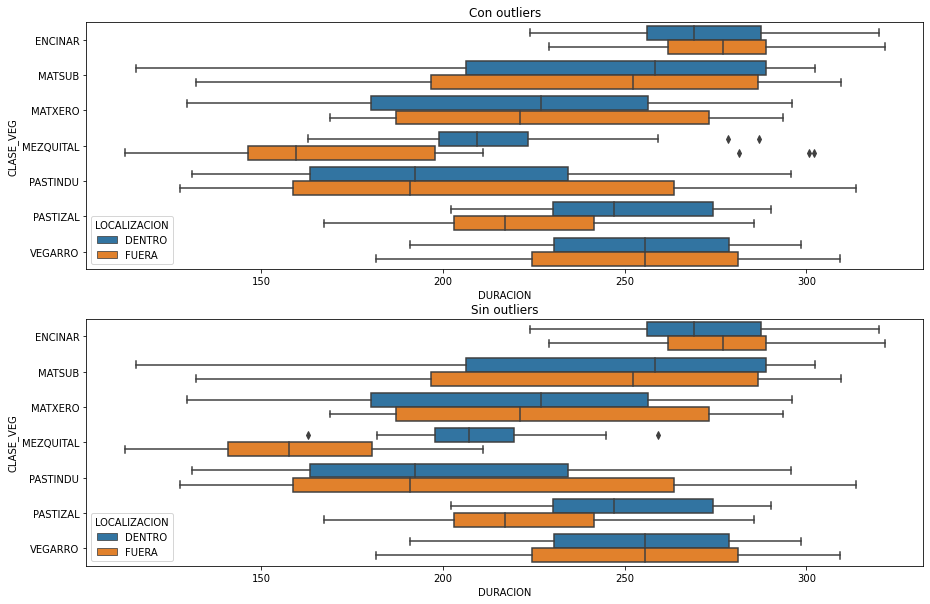

In [272]:
ts_ndvi['outlier'] = 0
idx_col_outliers = ts_ndvi.columns.to_list().index('outlier')

identificacion_outliers(
    ts_ndvi,
    'GRUPO',
    'DURACION',
    idx_col_outliers,
    'CLASE_VEG',
    'LOCALIZACION'
)

##### Conteo del número de observaciones por grupo

Revisamos el número de muestras en cada grupo

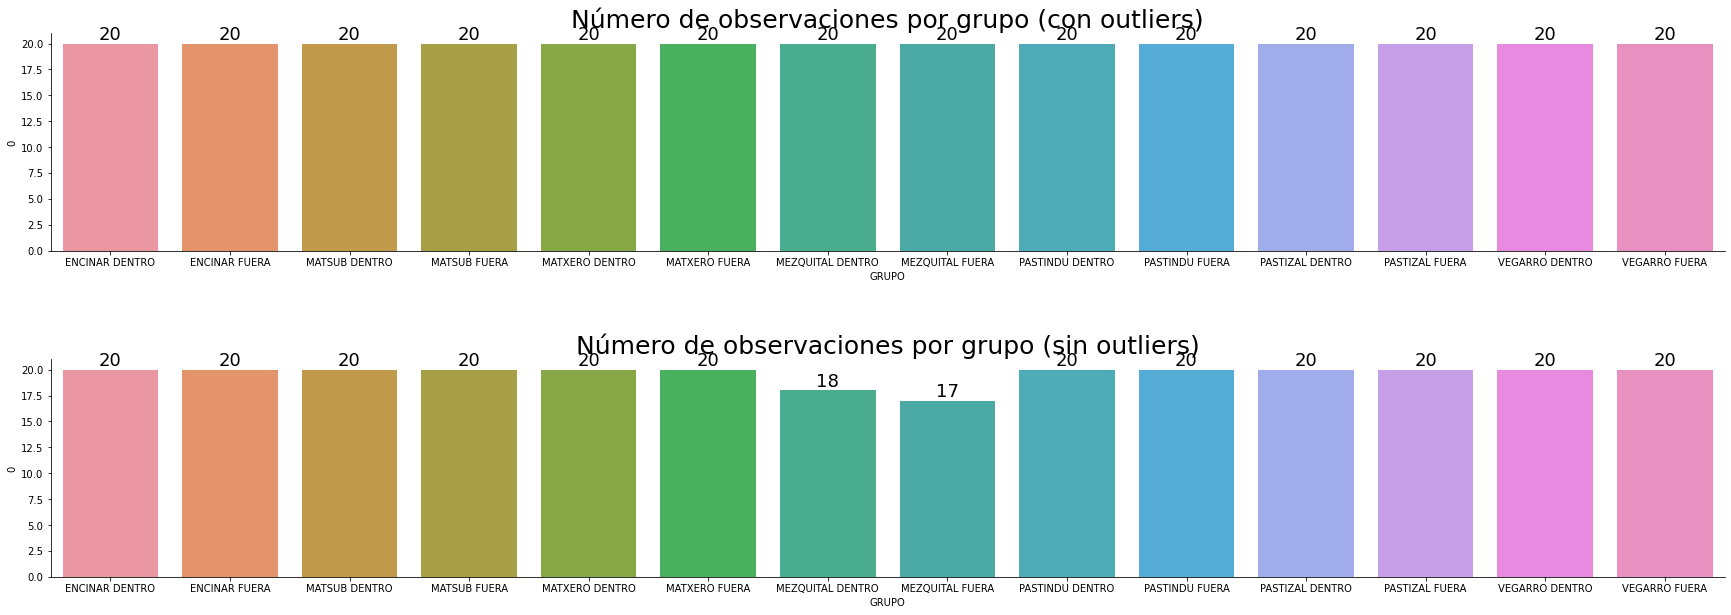

In [273]:
revisar_num_muestras_por_grupo(ts_ndvi, 'GRUPO', idx_col_outliers)

##### Revisión del supuesto de normalidad

Ahora se revisará el supuesto de normalidad

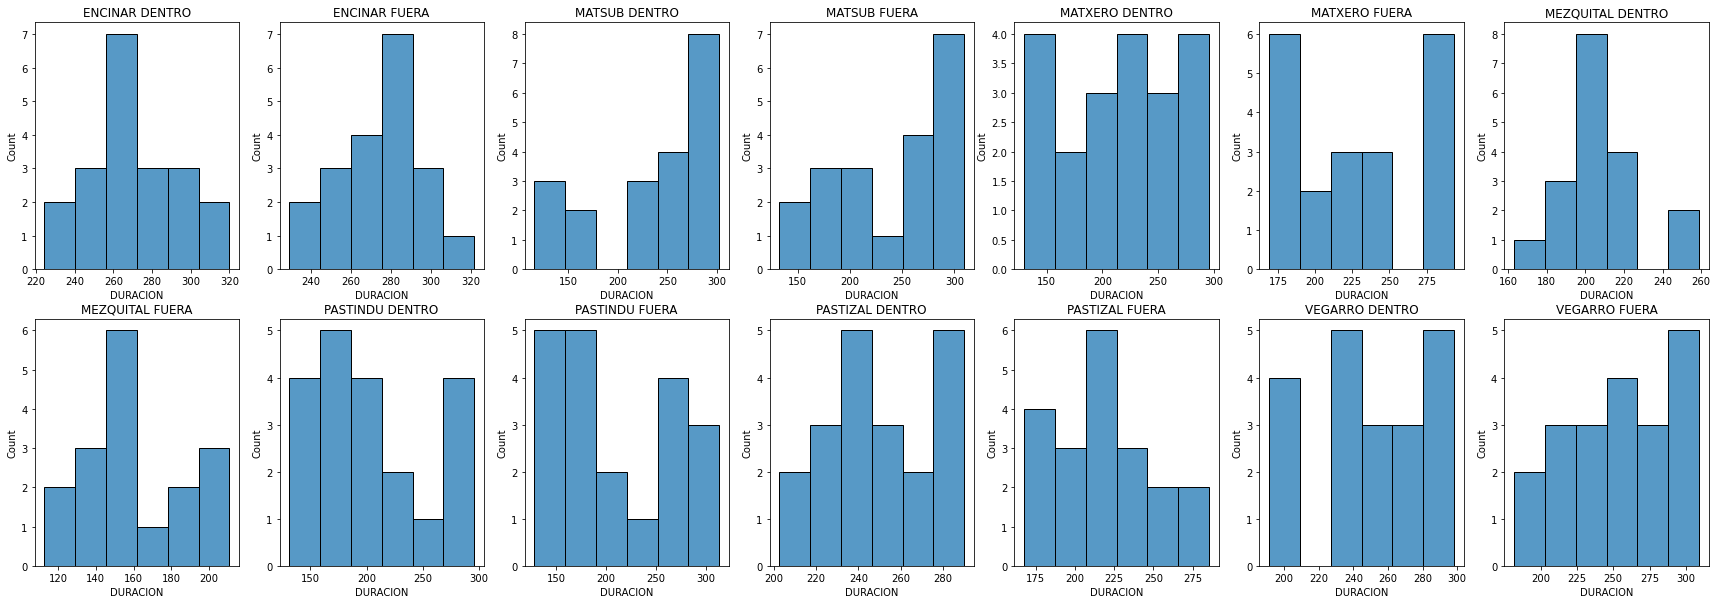

In [274]:
ts_ndvi = ts_ndvi[ts_ndvi.outlier == 0].copy()
histogramas_por_clase(ts_ndvi, 'GRUPO', 'DURACION')

In [275]:
resultados_test_norm = pruebas_normalidad_shapiro(ts_ndvi, 'GRUPO', 'DURACION')
resultados_test_norm[resultados_test_norm.pvalor > .05]

grupo         W    pvalor
0     ENCINAR DENTRO  0.984793  0.980265
1      ENCINAR FUERA  0.984064  0.975284
3       MATSUB FUERA  0.925547  0.126732
4     MATXERO DENTRO  0.955086  0.450911
5      MATXERO FUERA  0.912750  0.071924
6   MEZQUITAL DENTRO  0.968437  0.767827
7    MEZQUITAL FUERA  0.967885  0.780416
8    PASTINDU DENTRO  0.931189  0.162765
9     PASTINDU FUERA  0.916262  0.083977
10   PASTIZAL DENTRO  0.944819  0.295190
11    PASTIZAL FUERA  0.973576  0.827853
12    VEGARRO DENTRO  0.935962  0.200937
13     VEGARRO FUERA  0.965405  0.656407

##### Revisión del supuesto de homogeneidad de varianzas

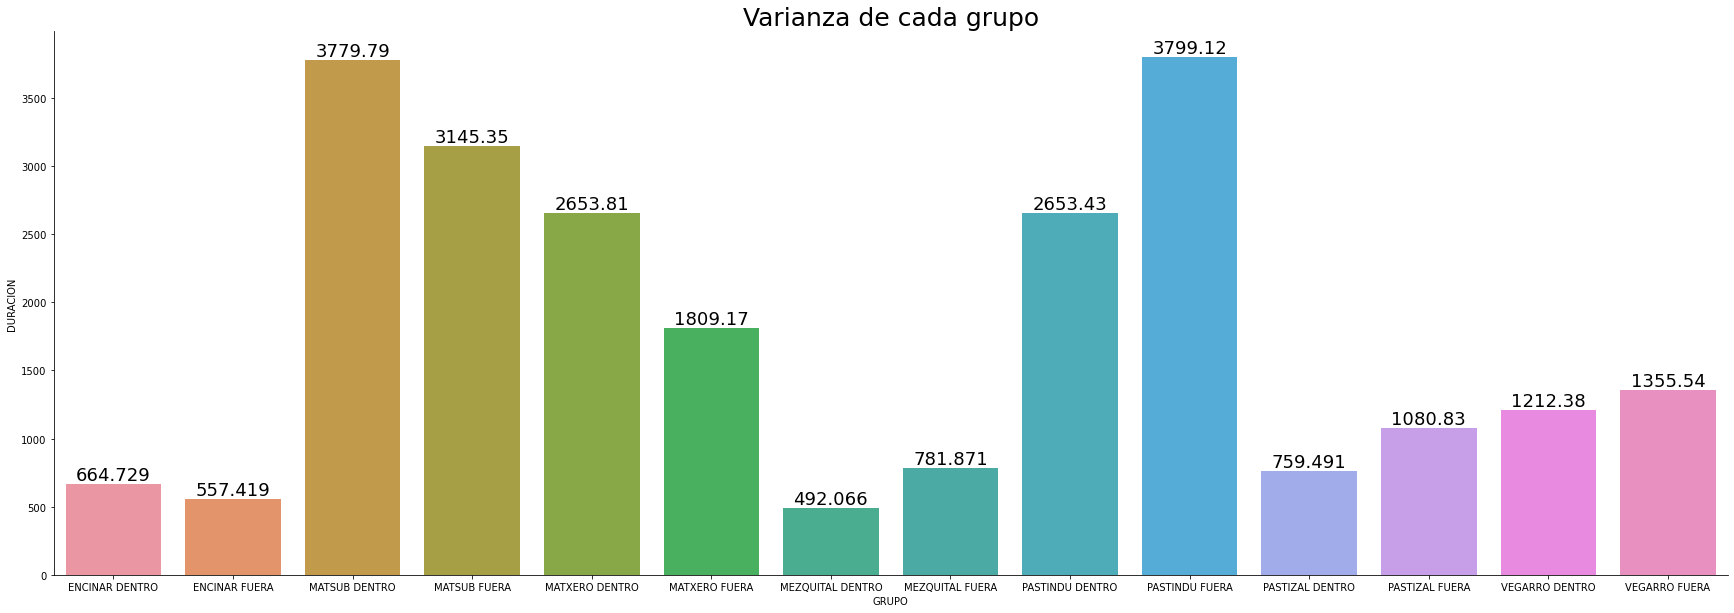

In [276]:
graficar_varianzas_intergrupos(ts_ndvi, 'GRUPO', 'DURACION')

In [277]:
print(prueba_levene(ts_ndvi, 'GRUPO', 'DURACION'))

LeveneResult(statistic=4.443960000598312, pvalue=8.128261138714082e-07)


##### Kruskal-Wallis

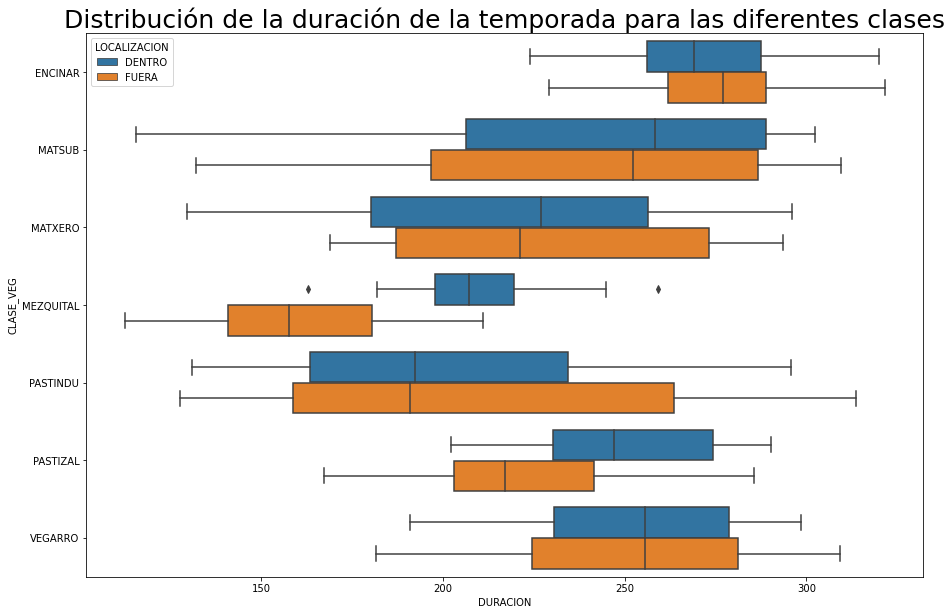

In [278]:
boxplots_variable_intergrupos(ts_ndvi, 'Distribución de la duración de la temporada para las diferentes clases', 'DURACION', 'CLASE_VEG', 'LOCALIZACION')

In [279]:
print(prueba_kruskal_wallis(ts_ndvi, 'GRUPO', 'DURACION'))

KruskalResult(statistic=85.85476598072772, pvalue=8.622482735933039e-13)


##### Pruebas Post Hoc: Tukey HSD

In [280]:
obj_tukey, _, comparaciones_dentro_fuera = prueba_tukey(ts_ndvi, 'GRUPO', 'DURACION', 'CLASE_VEG')
comparaciones_dentro_fuera

0             group1           group2 meandiff   p-adj    lower    upper  \
1     ENCINAR DENTRO    ENCINAR FUERA    5.672     0.9 -39.6093  50.9533   
26     MATSUB DENTRO     MATSUB FUERA  -0.7424     0.9 -46.0237  44.5389   
47    MATXERO DENTRO    MATXERO FUERA   7.4688     0.9 -37.8125  52.7501   
64  MEZQUITAL DENTRO  MEZQUITAL FUERA -48.3514  0.0508 -96.7789   0.0762   
77   PASTINDU DENTRO   PASTINDU FUERA   7.0696     0.9 -38.2117  52.3509   
86   PASTIZAL DENTRO   PASTIZAL FUERA  -30.376  0.5666 -75.6573  14.9053   
91    VEGARRO DENTRO    VEGARRO FUERA    2.376     0.9 -42.9053  47.6573   

0  reject  
1   False  
26  False  
47  False  
64  False  
77  False  
86  False  
91  False

Text(0.5, 1.0, 'Intervalos de confianza para la media de cada grupo')

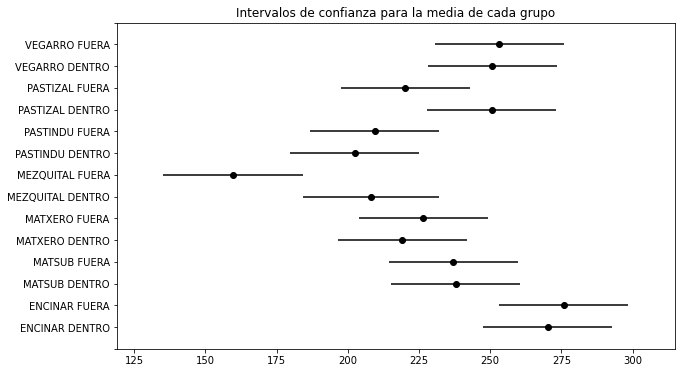

In [281]:
fig , ax = plt.subplots(1,1,figsize=(15,10))

_ = obj_tukey.plot_simultaneous(ax=ax)
ax.set_title('Intervalos de confianza para la media de cada grupo')

### AMPLITUD

#### EVI

In [282]:
ts_evi = pd.read_excel(datasets[0], usecols=columnas_importantes)
ts_evi = preparar_dataframe(ts_evi)
ts_evi['GRUPO'] = ts_evi.CLASE_VEG + ' ' + ts_evi.LOCALIZACION
ts_evi.head()

CLASE_VEG  INICIO  AMPLITUD  DURACION  INTMAY  INTMEN LOCALIZACION  \
0   ENCINAR  172.96      1987   167.360   32030   13410       DENTRO   
1   ENCINAR  172.96      1972   148.272   30020   12640       DENTRO   
2   ENCINAR  192.16      1782   133.152   24720   10770       DENTRO   
3   ENCINAR  207.36      2162   258.880   41990   16480       DENTRO   
4   ENCINAR  203.20      1629   268.640   40850   14580       DENTRO   

            GRUPO  
0  ENCINAR DENTRO  
1  ENCINAR DENTRO  
2  ENCINAR DENTRO  
3  ENCINAR DENTRO  
4  ENCINAR DENTRO

##### Localización de datos atípicos

Revisamos si existen datos atípicos

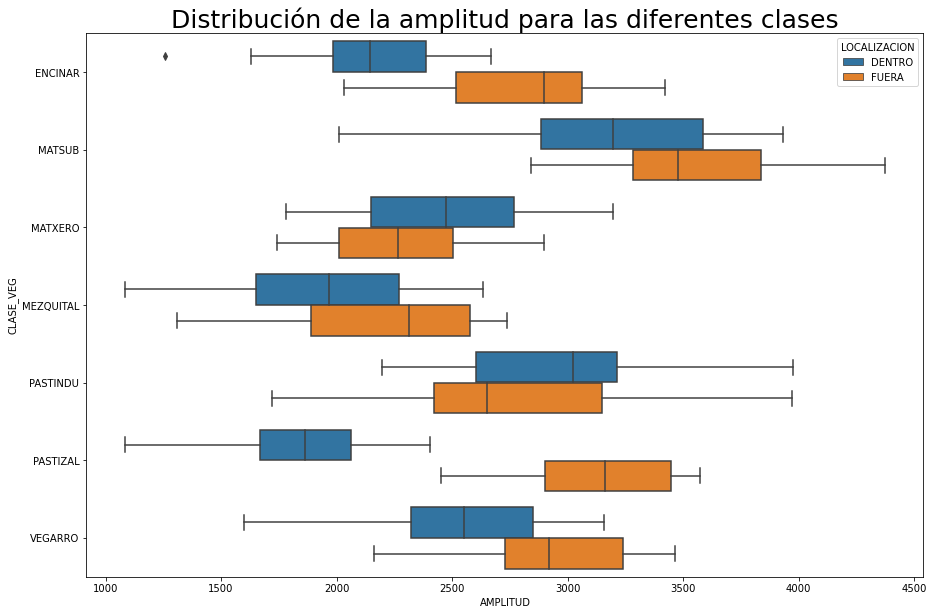

In [283]:
boxplots_variable_intergrupos(
    ts_evi, 
    'Distribución de la amplitud para las diferentes clases', 
    'AMPLITUD', 
    'CLASE_VEG', 
    'LOCALIZACION'
)

# de outliers identificados: 1


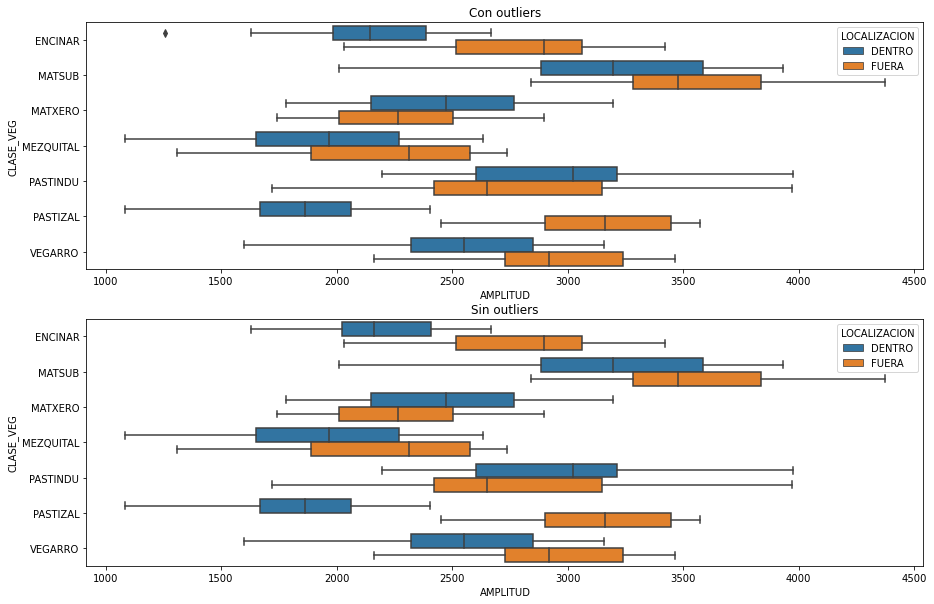

In [284]:
ts_evi['outlier'] = 0
idx_col_outliers = ts_evi.columns.to_list().index('outlier')

identificacion_outliers(
    ts_evi,
    'GRUPO',
    'AMPLITUD',
    idx_col_outliers,
    'CLASE_VEG',
    'LOCALIZACION'
)

##### Conteo del número de observaciones por grupo

Revisamos el número de muestras en cada grupo

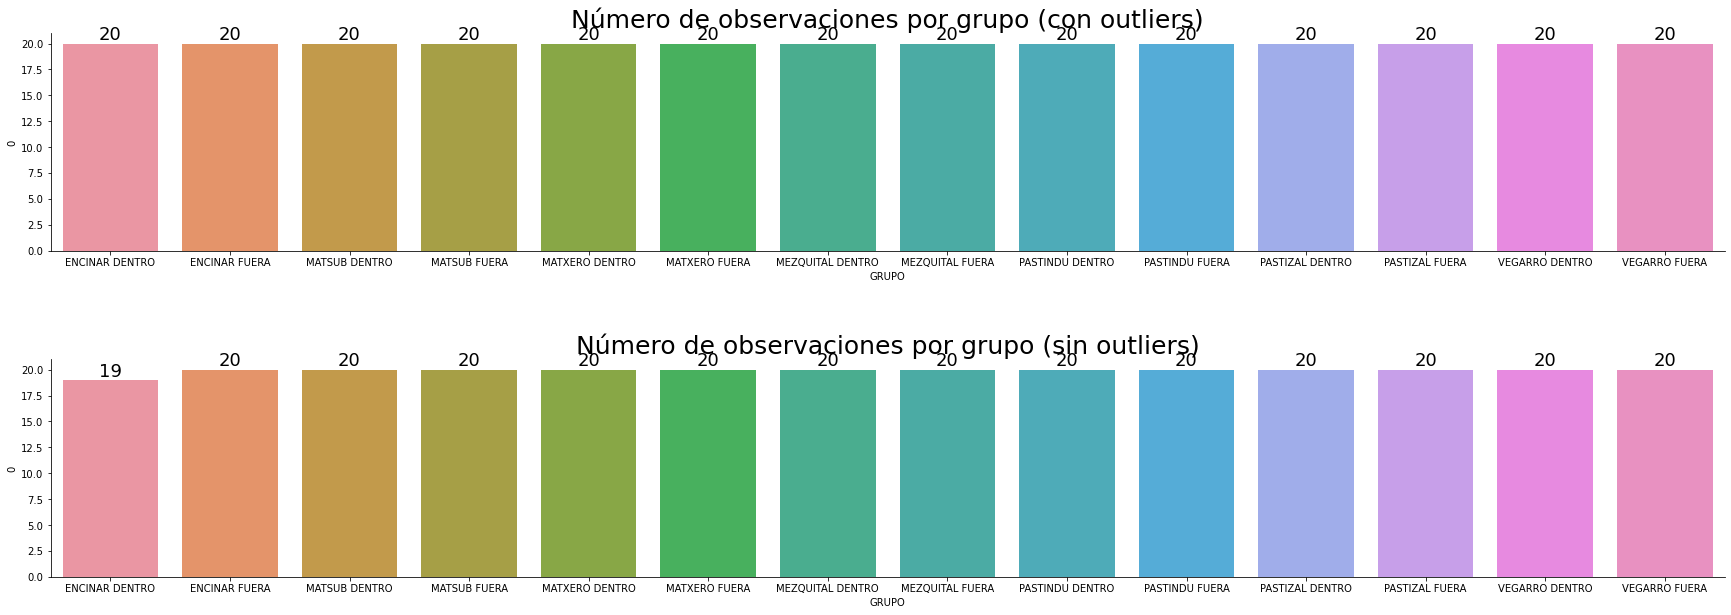

In [285]:
revisar_num_muestras_por_grupo(ts_evi, 'GRUPO', idx_col_outliers)

##### Revisión del supuesto de normalidad

Ahora se revisará el supuesto de normalidad

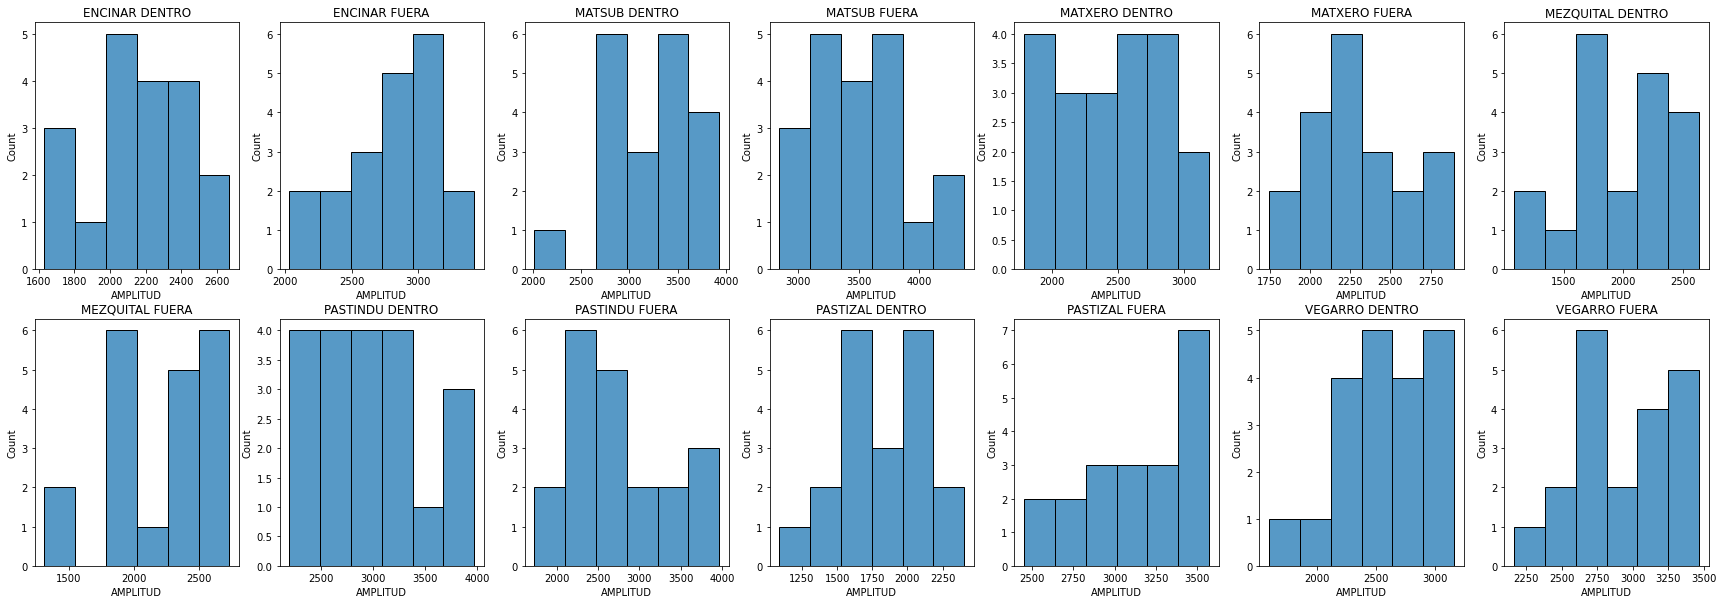

In [286]:
ts_evi = ts_evi[ts_evi.outlier == 0].copy()
histogramas_por_clase(ts_evi, 'GRUPO', 'AMPLITUD')

In [287]:
resultados_test_norm = pruebas_normalidad_shapiro(ts_evi, 'GRUPO', 'AMPLITUD')
resultados_test_norm[resultados_test_norm.pvalor > .05]

grupo         W    pvalor
0     ENCINAR DENTRO  0.974848  0.867439
1      ENCINAR FUERA  0.949741  0.363173
2      MATSUB DENTRO  0.939740  0.237079
3       MATSUB FUERA  0.976913  0.888342
4     MATXERO DENTRO  0.975406  0.862225
5      MATXERO FUERA  0.971411  0.784362
6   MEZQUITAL DENTRO  0.961909  0.582656
7    MEZQUITAL FUERA  0.926694  0.133357
8    PASTINDU DENTRO  0.957867  0.502174
9     PASTINDU FUERA  0.962803  0.601242
10   PASTIZAL DENTRO  0.972110  0.798679
11    PASTIZAL FUERA  0.930018  0.154540
12    VEGARRO DENTRO  0.967570  0.702968
13     VEGARRO FUERA  0.948461  0.344331

##### Revisión del supuesto de homogeneidad de varianzas

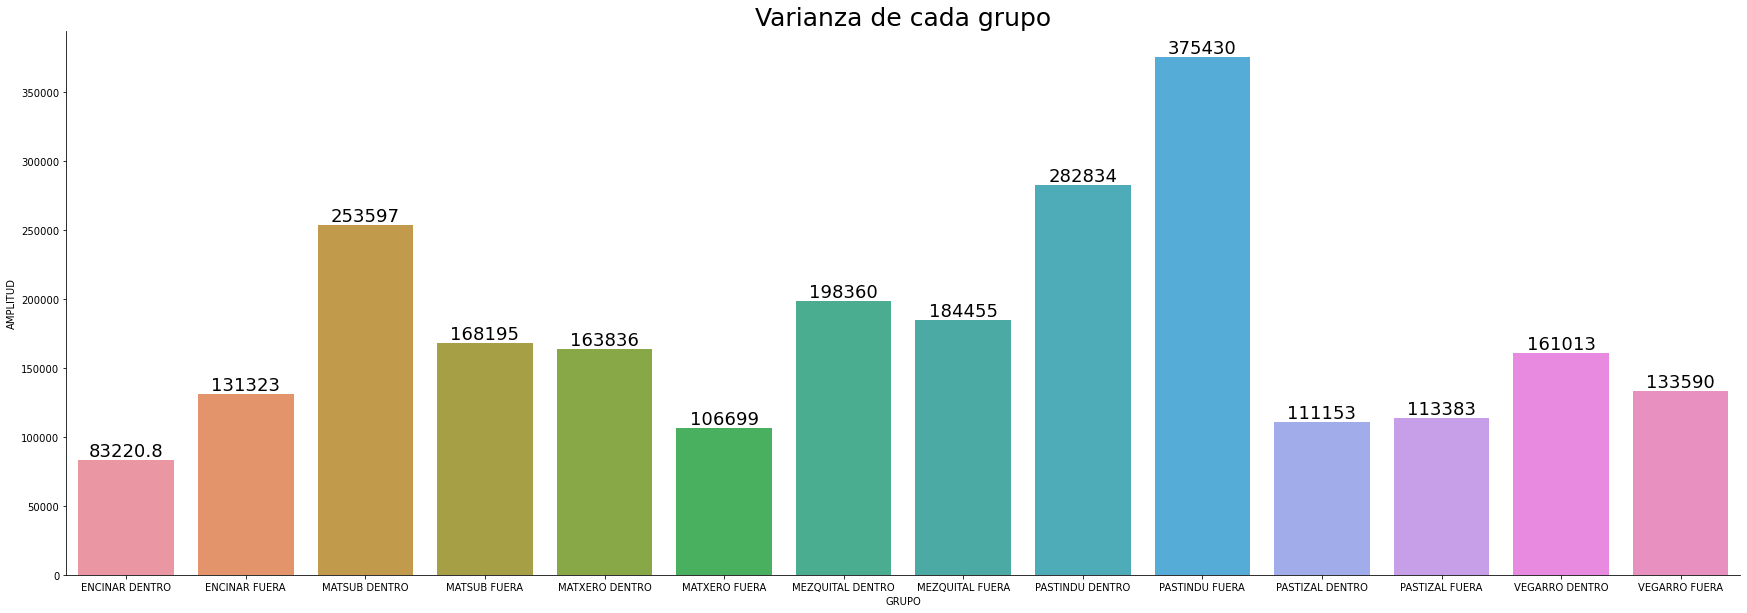

In [288]:
graficar_varianzas_intergrupos(ts_evi, 'GRUPO', 'AMPLITUD')

In [289]:
print(prueba_levene(ts_evi, 'GRUPO', 'AMPLITUD'))

LeveneResult(statistic=1.736268784685449, pvalue=0.053741228315205475)


##### Análisis de varianza  

In [290]:
# Ordinary Least Squares (OLS) model
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('AMPLITUD ~ C(GRUPO)', data=ts_evi).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

             df        sum_sq       mean_sq          F        PR(>F)
C(GRUPO)   13.0  6.658377e+07  5.121829e+06  29.007112  1.217465e-43
Residual  265.0  4.679144e+07  1.765715e+05        NaN           NaN


Text(0.5, 1.0, 'QQPLOTR DE LOS RESIDUALES ESTANDARIZADOS')

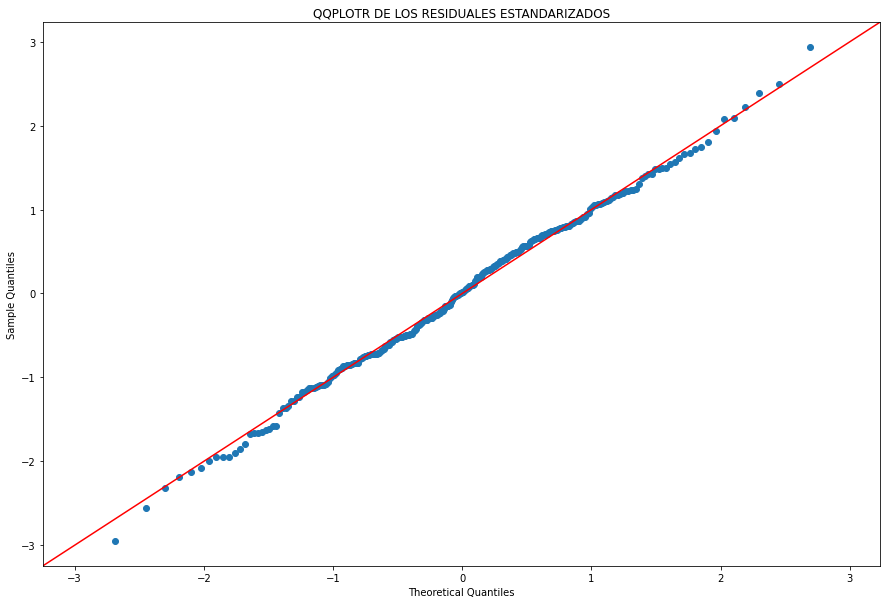

In [291]:
resid_standard = model.get_influence().resid_studentized_internal

fig , ax = plt.subplots(1,1,figsize=(15,10))
_ = sm.qqplot(resid_standard, line='45', ax=ax)
ax.set_title('QQPLOTR DE LOS RESIDUALES ESTANDARIZADOS')

In [292]:
stats.shapiro(resid_standard)

ShapiroResult(statistic=0.996801495552063, pvalue=0.8525516986846924)

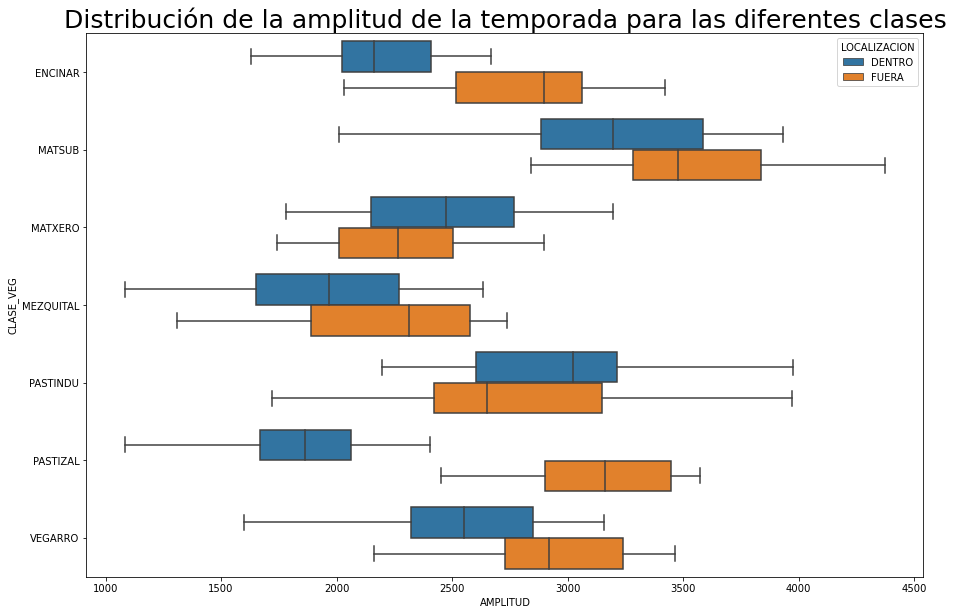

In [293]:
boxplots_variable_intergrupos(ts_evi, 'Distribución de la amplitud de la temporada para las diferentes clases', 'AMPLITUD', 'CLASE_VEG', 'LOCALIZACION')

##### Pruebas Post Hoc: Tukey HSD

In [294]:
obj_tukey, _, comparaciones_dentro_fuera = prueba_tukey(ts_evi, 'GRUPO', 'AMPLITUD', 'CLASE_VEG')
comparaciones_dentro_fuera

0             group1           group2  meandiff   p-adj     lower      upper  \
1     ENCINAR DENTRO    ENCINAR FUERA  623.8553   0.001  168.1323  1079.5782   
26     MATSUB DENTRO     MATSUB FUERA    301.75  0.5669 -148.0924   751.5924   
47    MATXERO DENTRO    MATXERO FUERA   -167.45     0.9 -617.2924   282.3924   
64  MEZQUITAL DENTRO  MEZQUITAL FUERA    249.95  0.8124 -199.8924   699.7924   
77   PASTINDU DENTRO   PASTINDU FUERA    -228.4     0.9 -678.2424   221.4424   
86   PASTIZAL DENTRO   PASTIZAL FUERA   1317.55   0.001  867.7076  1767.3924   
91    VEGARRO DENTRO    VEGARRO FUERA    414.75  0.1062  -35.0924   864.5924   

0  reject  
1    True  
26  False  
47  False  
64  False  
77  False  
86   True  
91  False

Text(0.5, 1.0, 'Intervalos de confianza para la media de cada grupo')

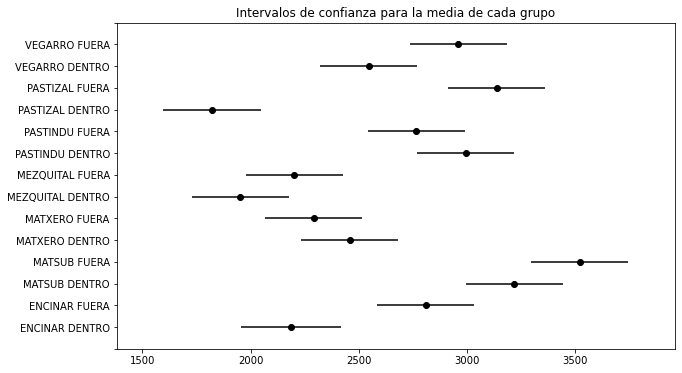

In [295]:
fig , ax = plt.subplots(1,1,figsize=(15,10))

_ = obj_tukey.plot_simultaneous(ax=ax)
ax.set_title('Intervalos de confianza para la media de cada grupo')

#### NDVI

In [296]:
ts_ndvi = pd.read_excel(datasets[1], usecols=columnas_importantes)
ts_ndvi = preparar_dataframe(ts_ndvi)
ts_ndvi['GRUPO'] = ts_ndvi.CLASE_VEG + ' ' + ts_ndvi.LOCALIZACION
ts_ndvi.head()

CLASE_VEG  INICIO  AMPLITUD  DURACION  INTMAY  INTMEN LOCALIZACION  \
0   ENCINAR  177.44      3145    230.56   70050   33880       DENTRO   
1   ENCINAR  177.44      3019    302.40   89970   42230       DENTRO   
2   ENCINAR  187.04      2814    286.08   79660   33570       DENTRO   
3   ENCINAR  206.40      3614    277.76   83110   39800       DENTRO   
4   ENCINAR  201.60      2878    292.16   81110   36720       DENTRO   

            GRUPO  
0  ENCINAR DENTRO  
1  ENCINAR DENTRO  
2  ENCINAR DENTRO  
3  ENCINAR DENTRO  
4  ENCINAR DENTRO

##### Localización de datos atípicos

Revisamos si existen datos atípicos

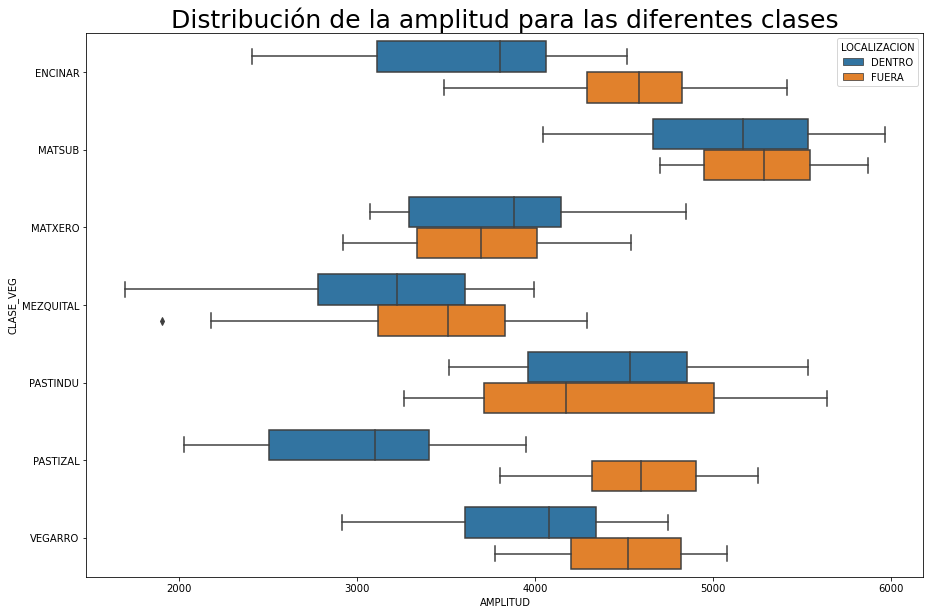

In [297]:
boxplots_variable_intergrupos(
    ts_ndvi, 
    'Distribución de la amplitud para las diferentes clases', 
    'AMPLITUD', 
    'CLASE_VEG', 
    'LOCALIZACION'
)

# de outliers identificados: 1


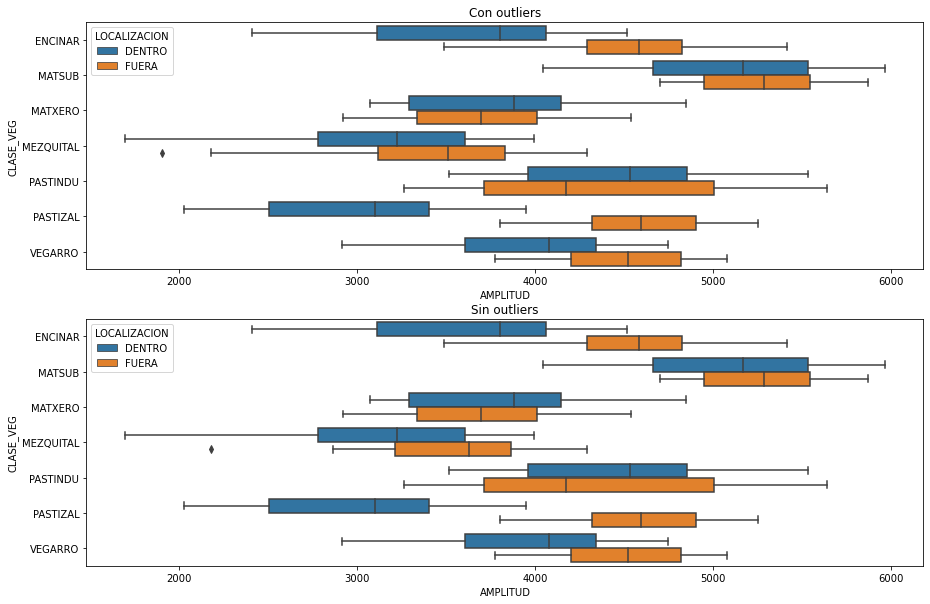

In [298]:
ts_ndvi['outlier'] = 0
idx_col_outliers = ts_ndvi.columns.to_list().index('outlier')

identificacion_outliers(
    ts_ndvi,
    'GRUPO',
    'AMPLITUD',
    idx_col_outliers,
    'CLASE_VEG',
    'LOCALIZACION'
)

##### Conteo del número de observaciones por grupo

Revisamos el número de muestras en cada grupo

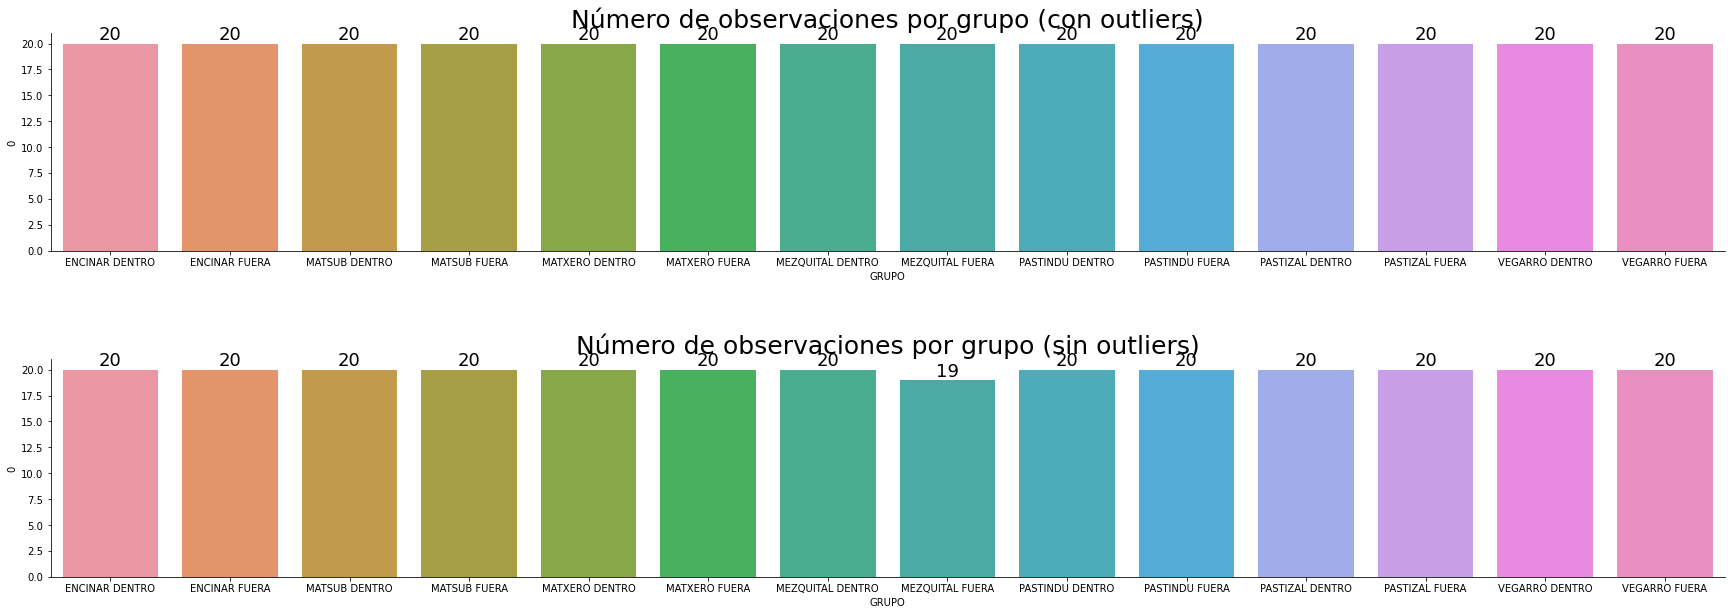

In [299]:
revisar_num_muestras_por_grupo(ts_ndvi, 'GRUPO', idx_col_outliers)

##### Revisión del supuesto de normalidad

Ahora se revisará el supuesto de normalidad

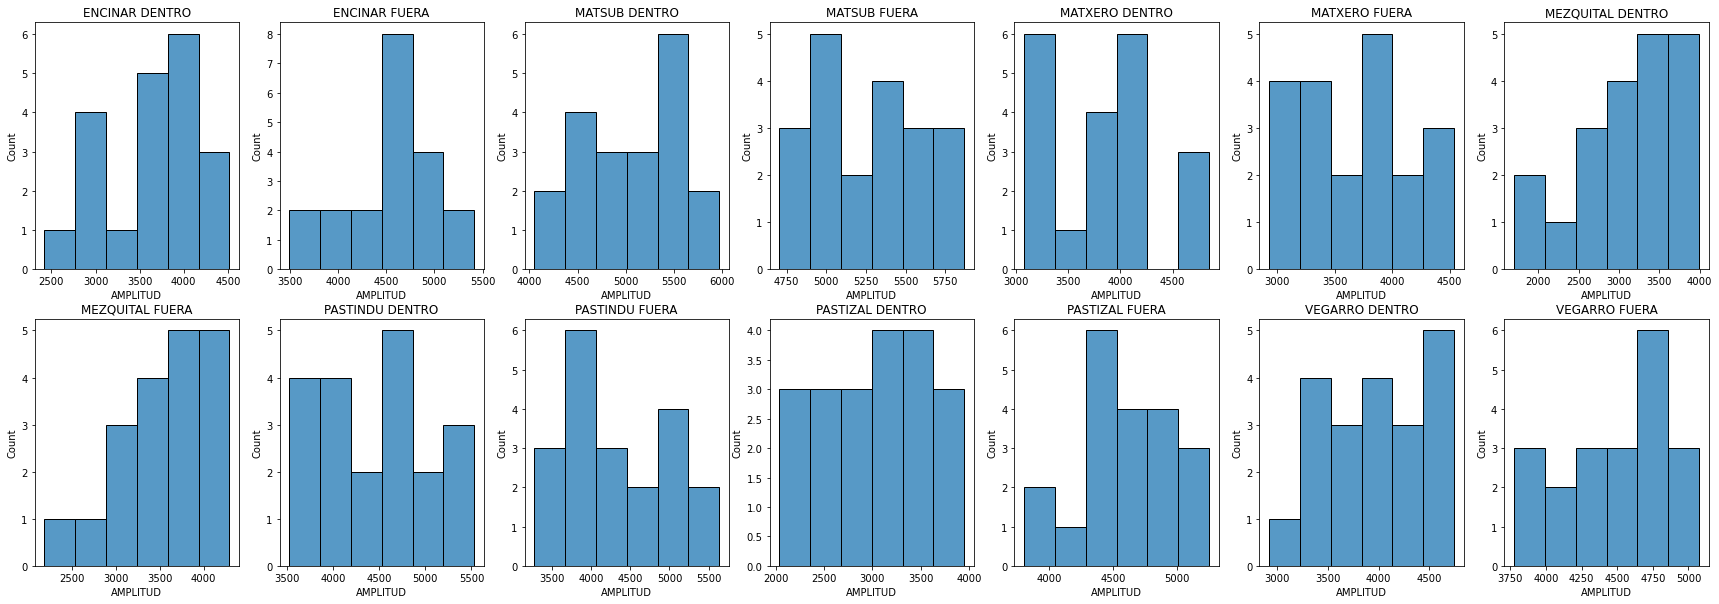

In [300]:
ts_ndvi = ts_ndvi[ts_ndvi.outlier == 0].copy()
histogramas_por_clase(ts_ndvi, 'GRUPO', 'AMPLITUD')

In [301]:
resultados_test_norm = pruebas_normalidad_shapiro(ts_ndvi, 'GRUPO', 'AMPLITUD')
resultados_test_norm[resultados_test_norm.pvalor > .05]

grupo         W    pvalor
0     ENCINAR DENTRO  0.939084  0.230399
1      ENCINAR FUERA  0.966716  0.684579
2      MATSUB DENTRO  0.957515  0.495480
3       MATSUB FUERA  0.955522  0.458701
4     MATXERO DENTRO  0.937783  0.217653
5      MATXERO FUERA  0.961596  0.576203
6   MEZQUITAL DENTRO  0.940480  0.244842
7    MEZQUITAL FUERA  0.959991  0.572196
8    PASTINDU DENTRO  0.951445  0.389560
9     PASTINDU FUERA  0.946563  0.317909
10   PASTIZAL DENTRO  0.953944  0.430936
11    PASTIZAL FUERA  0.977144  0.892155
12    VEGARRO DENTRO  0.963378  0.613302
13     VEGARRO FUERA  0.943389  0.277653

##### Revisión del supuesto de homogeneidad de varianzas

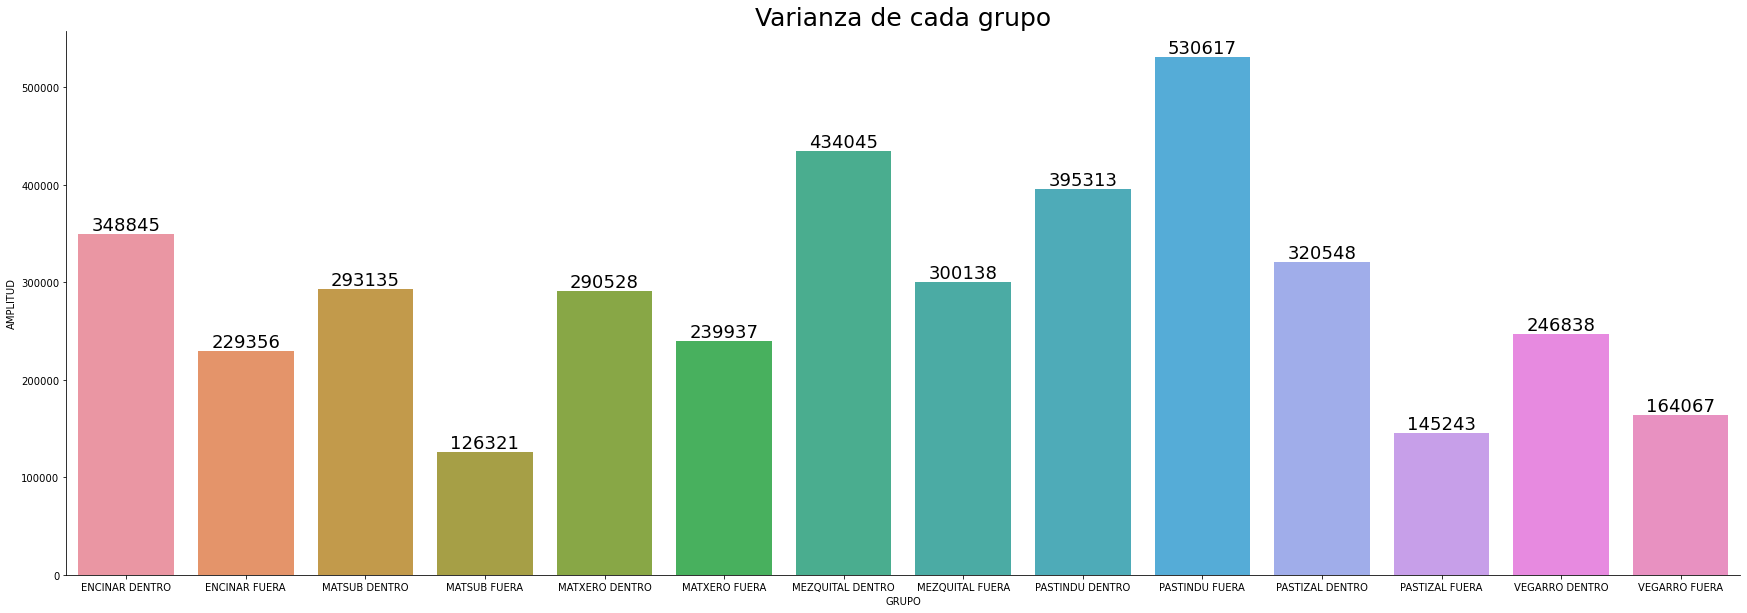

In [302]:
graficar_varianzas_intergrupos(ts_ndvi, 'GRUPO', 'AMPLITUD')

In [303]:
print(prueba_levene(ts_ndvi, 'GRUPO', 'AMPLITUD'))

LeveneResult(statistic=1.533596488688189, pvalue=0.10517725286329468)


##### Análisis de varianza  

In [304]:
# Ordinary Least Squares (OLS) model
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('AMPLITUD ~ C(GRUPO)', data=ts_ndvi).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

             df        sum_sq       mean_sq          F        PR(>F)
C(GRUPO)   13.0  1.198042e+08  9.215709e+06  31.743802  1.168688e-46
Residual  265.0  7.693353e+07  2.903152e+05        NaN           NaN


Text(0.5, 1.0, 'QQPLOTR DE LOS RESIDUALES ESTANDARIZADOS')

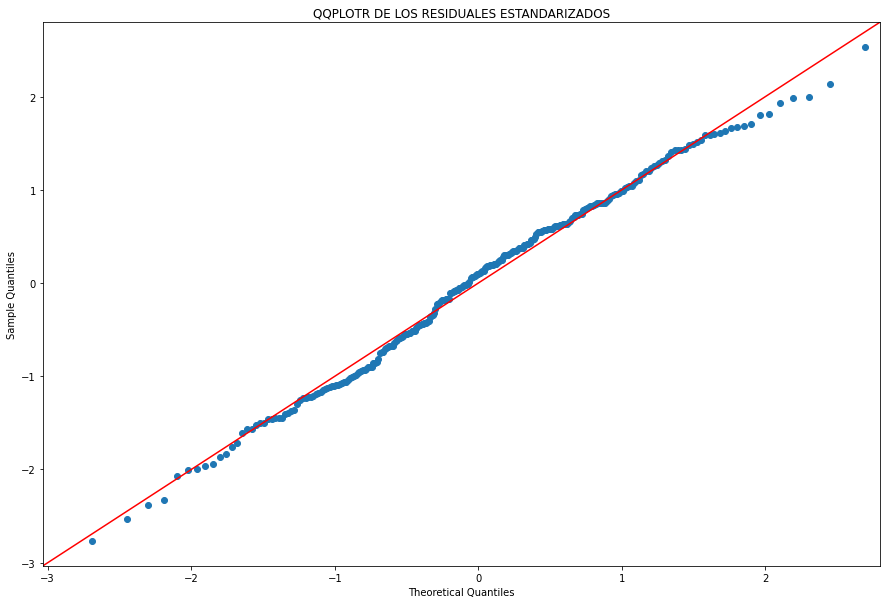

In [305]:
resid_standard = model.get_influence().resid_studentized_internal

fig , ax = plt.subplots(1,1,figsize=(15,10))
_ = sm.qqplot(resid_standard, line='45', ax=ax)
ax.set_title('QQPLOTR DE LOS RESIDUALES ESTANDARIZADOS')

In [306]:
stats.shapiro(resid_standard)

ShapiroResult(statistic=0.9913984537124634, pvalue=0.10265546292066574)

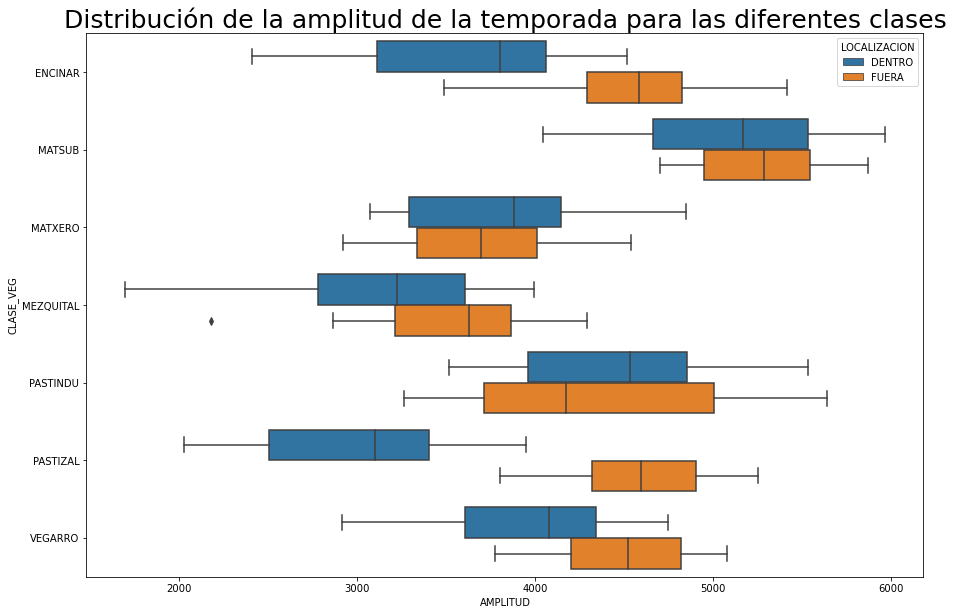

In [307]:
boxplots_variable_intergrupos(ts_ndvi, 'Distribución de la amplitud de la temporada para las diferentes clases', 'AMPLITUD', 'CLASE_VEG', 'LOCALIZACION')

##### Pruebas Post Hoc: Tukey HSD

In [308]:
obj_tukey, _, comparaciones_dentro_fuera = prueba_tukey(ts_ndvi, 'GRUPO', 'AMPLITUD', 'CLASE_VEG')
comparaciones_dentro_fuera

0             group1           group2  meandiff   p-adj     lower     upper  \
1     ENCINAR DENTRO    ENCINAR FUERA    906.65   0.001   329.837  1483.463   
26     MATSUB DENTRO     MATSUB FUERA     186.0     0.9  -390.813   762.813   
47    MATXERO DENTRO    MATXERO FUERA   -154.45     0.9  -731.263   422.363   
64  MEZQUITAL DENTRO  MEZQUITAL FUERA  357.7921  0.6916 -226.5613  942.1455   
77   PASTINDU DENTRO   PASTINDU FUERA    -172.4     0.9  -749.213   404.413   
86   PASTIZAL DENTRO   PASTIZAL FUERA   1597.45   0.001  1020.637  2174.263   
91    VEGARRO DENTRO    VEGARRO FUERA    493.55  0.1857   -83.263  1070.363   

0  reject  
1    True  
26  False  
47  False  
64  False  
77  False  
86   True  
91  False

Text(0.5, 1.0, 'Intervalos de confianza para la media de cada grupo')

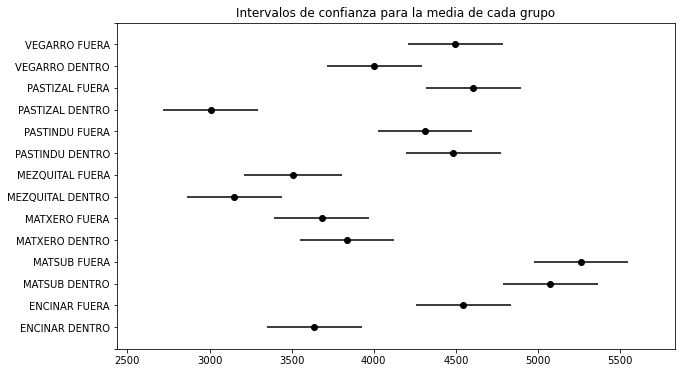

In [309]:
fig , ax = plt.subplots(1,1,figsize=(15,10))

_ = obj_tukey.plot_simultaneous(ax=ax)
ax.set_title('Intervalos de confianza para la media de cada grupo')

### INTEGRAL MAYOR

#### EVI

In [310]:
ts_evi = pd.read_excel(datasets[0], usecols=columnas_importantes)
ts_evi = preparar_dataframe(ts_evi)
ts_evi['GRUPO'] = ts_evi.CLASE_VEG + ' ' + ts_evi.LOCALIZACION
ts_evi.head()

CLASE_VEG  INICIO  AMPLITUD  DURACION  INTMAY  INTMEN LOCALIZACION  \
0   ENCINAR  172.96      1987   167.360   32030   13410       DENTRO   
1   ENCINAR  172.96      1972   148.272   30020   12640       DENTRO   
2   ENCINAR  192.16      1782   133.152   24720   10770       DENTRO   
3   ENCINAR  207.36      2162   258.880   41990   16480       DENTRO   
4   ENCINAR  203.20      1629   268.640   40850   14580       DENTRO   

            GRUPO  
0  ENCINAR DENTRO  
1  ENCINAR DENTRO  
2  ENCINAR DENTRO  
3  ENCINAR DENTRO  
4  ENCINAR DENTRO

##### Localización de datos atípicos

Revisamos si existen datos atípicos

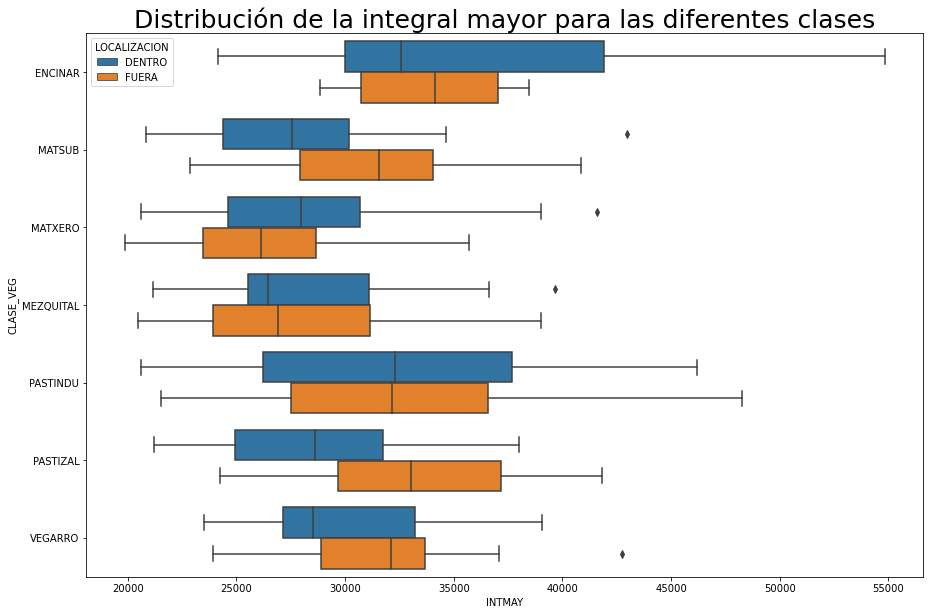

In [311]:
boxplots_variable_intergrupos(
    ts_evi, 
    'Distribución de la integral mayor para las diferentes clases', 
    'INTMAY', 
    'CLASE_VEG', 
    'LOCALIZACION'
)

# de outliers identificados: 4


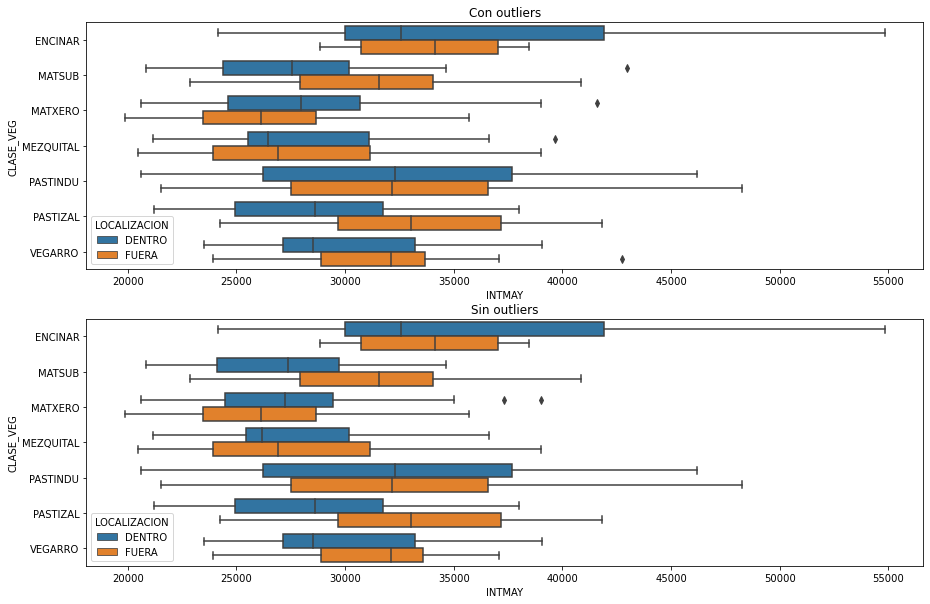

In [312]:
ts_evi['outlier'] = 0
idx_col_outliers = ts_evi.columns.to_list().index('outlier')

identificacion_outliers(
    ts_evi,
    'GRUPO',
    'INTMAY',
    idx_col_outliers,
    'CLASE_VEG',
    'LOCALIZACION'
)

##### Conteo del número de observaciones por grupo

Revisamos el número de muestras en cada grupo

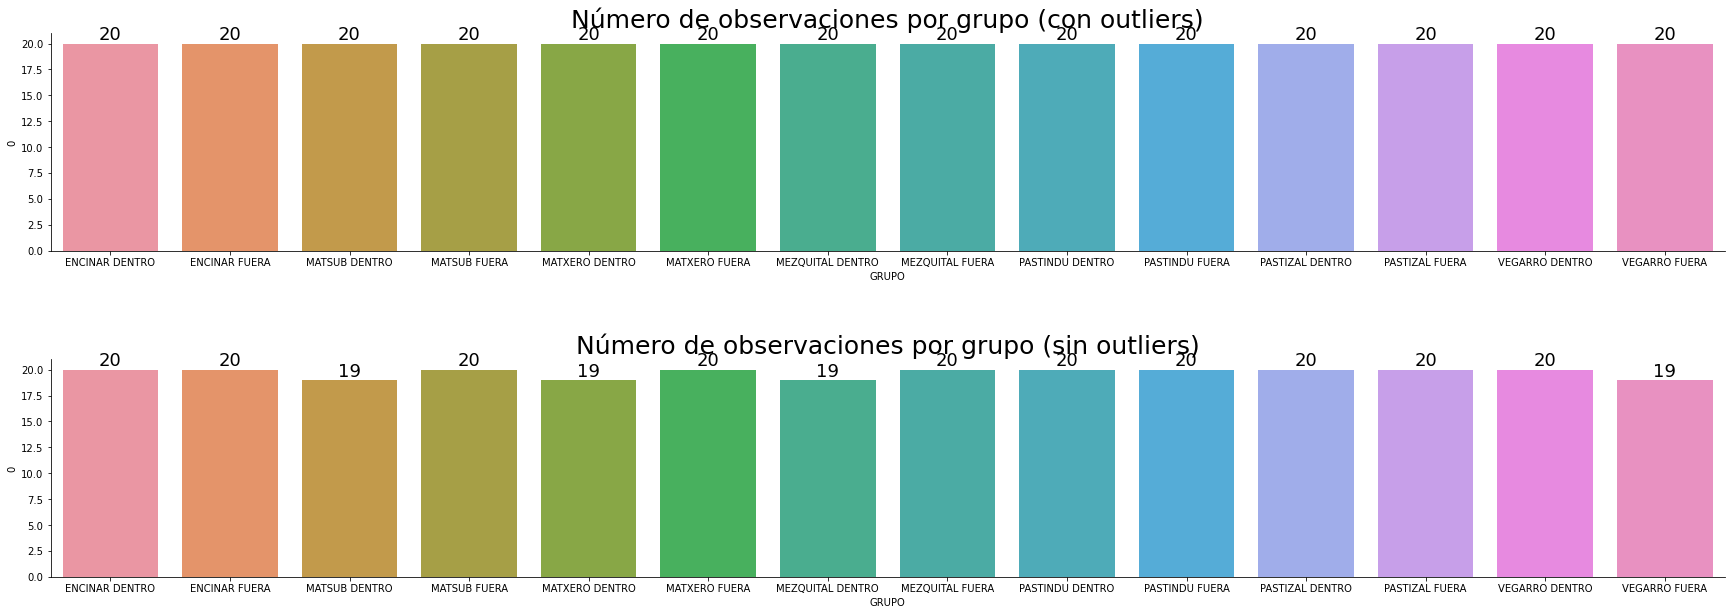

In [313]:
revisar_num_muestras_por_grupo(ts_evi, 'GRUPO', idx_col_outliers)

##### Revisión del supuesto de normalidad

Ahora se revisará el supuesto de normalidad

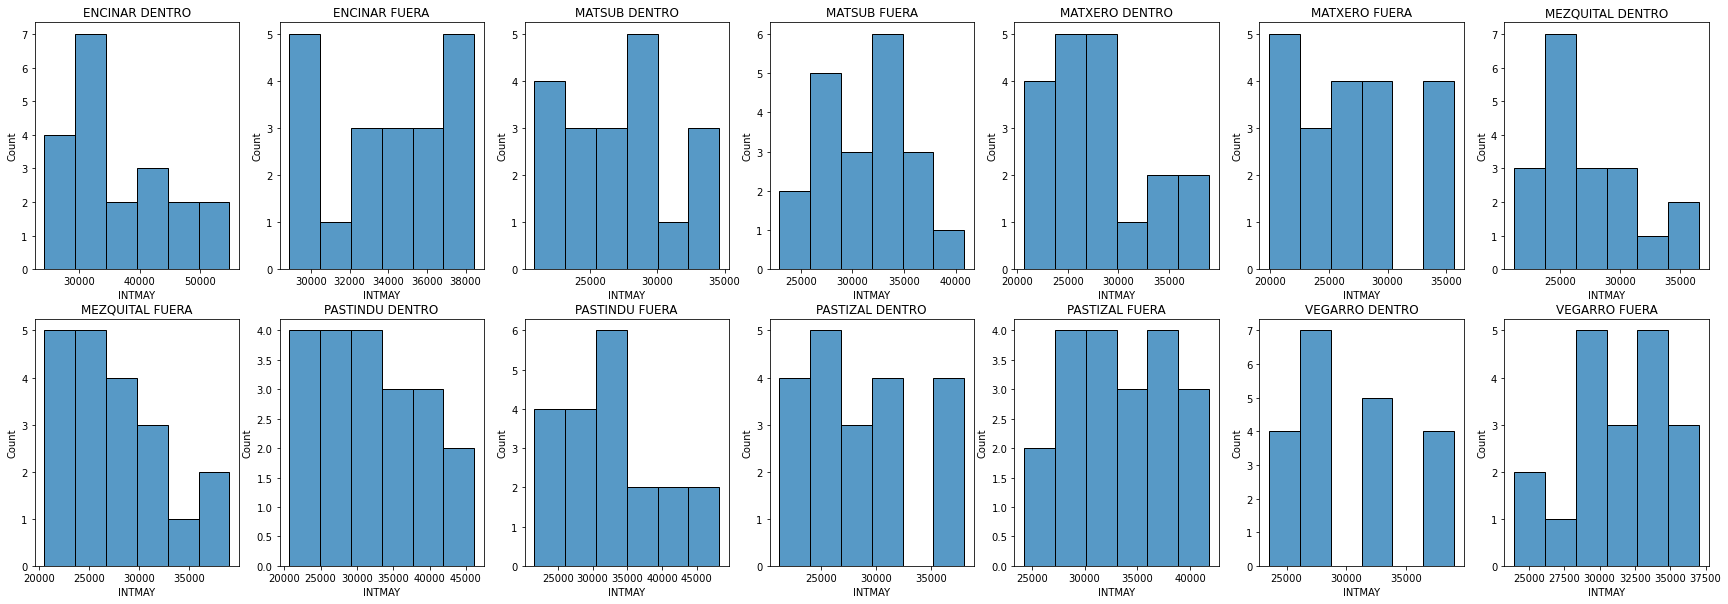

In [314]:
ts_evi = ts_evi[ts_evi.outlier == 0].copy()
histogramas_por_clase(ts_evi, 'GRUPO', 'INTMAY')

In [315]:
resultados_test_norm = pruebas_normalidad_shapiro(ts_evi, 'GRUPO', 'INTMAY')
resultados_test_norm[resultados_test_norm.pvalor > .05]

grupo         W    pvalor
0     ENCINAR DENTRO  0.915752  0.082105
1      ENCINAR FUERA  0.908603  0.059949
2      MATSUB DENTRO  0.965094  0.675821
3       MATSUB FUERA  0.986214  0.987993
4     MATXERO DENTRO  0.929338  0.168393
5      MATXERO FUERA  0.936352  0.204411
6   MEZQUITAL DENTRO  0.928817  0.164706
7    MEZQUITAL FUERA  0.945867  0.308670
8    PASTINDU DENTRO  0.955398  0.456468
9     PASTINDU FUERA  0.955796  0.463644
10   PASTIZAL DENTRO  0.951302  0.387293
11    PASTIZAL FUERA  0.973557  0.827479
12    VEGARRO DENTRO  0.925994  0.129276
13     VEGARRO FUERA  0.954010  0.461030

##### Revisión del supuesto de homogeneidad de varianzas

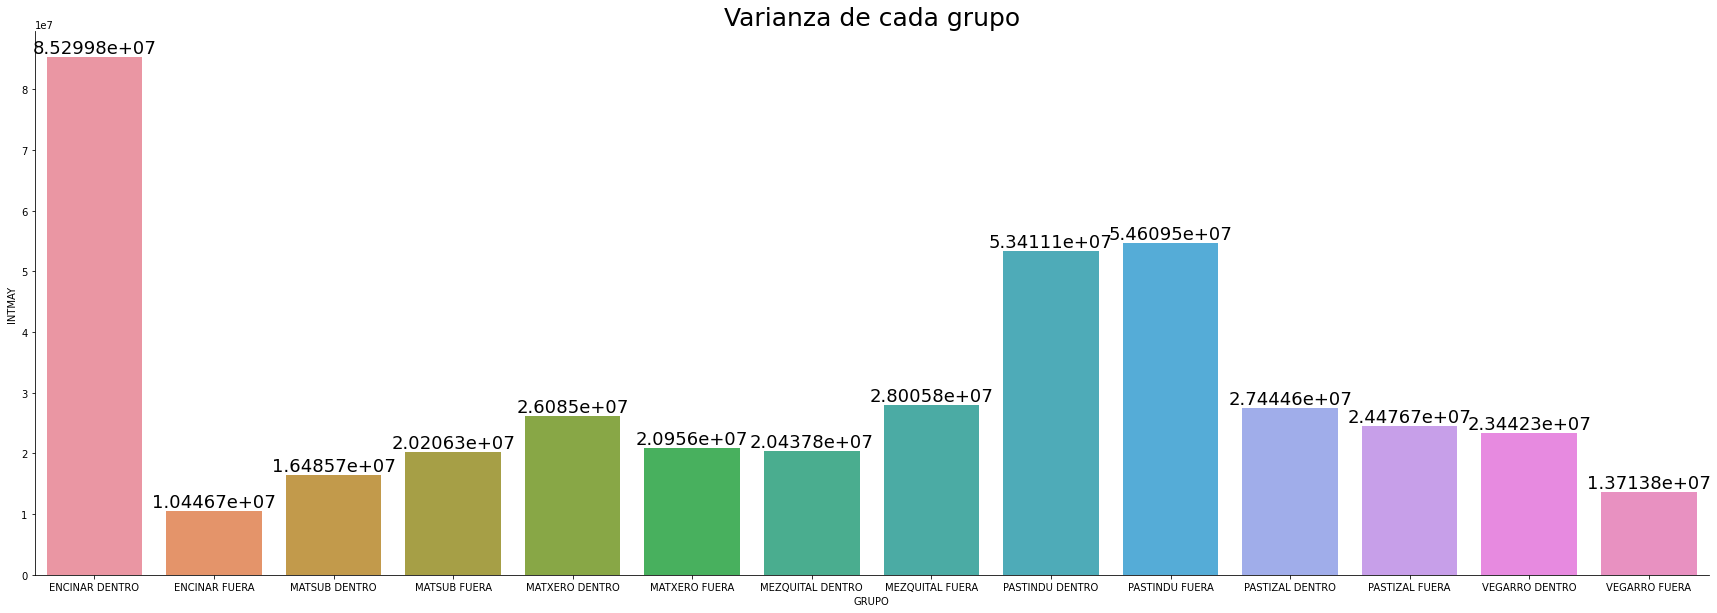

In [316]:
graficar_varianzas_intergrupos(ts_evi, 'GRUPO', 'INTMAY')

In [317]:
print(prueba_levene(ts_evi, 'GRUPO', 'INTMAY'))

LeveneResult(statistic=2.589850531529492, pvalue=0.002146625781154389)


Eliminamos el grupo del encinar

In [318]:
df = ts_evi
col_grupos = 'GRUPO'
col_variable = 'INTMAY'
levene = stats.levene(
        #df[df[col_grupos] == 'ENCINAR DENTRO'][col_variable],
        #df[df[col_grupos] == 'ENCINAR FUERA'][col_variable],
        df[df[col_grupos] == 'MATSUB DENTRO'][col_variable],
        df[df[col_grupos] == 'MATSUB FUERA'][col_variable],
        df[df[col_grupos] == 'MATXERO DENTRO'][col_variable],
        df[df[col_grupos] == 'MATXERO FUERA'][col_variable],
        df[df[col_grupos] == 'MEZQUITAL DENTRO'][col_variable],
        df[df[col_grupos] == 'MEZQUITAL FUERA'][col_variable],
        df[df[col_grupos] == 'PASTINDU DENTRO'][col_variable],
        df[df[col_grupos] == 'PASTINDU FUERA'][col_variable],
        df[df[col_grupos] == 'PASTIZAL DENTRO'][col_variable],
        df[df[col_grupos] == 'PASTIZAL FUERA'][col_variable],
        df[df[col_grupos] == 'VEGARRO DENTRO'][col_variable],
        df[df[col_grupos] == 'VEGARRO FUERA'][col_variable]
)

levene

LeveneResult(statistic=1.6498119932203879, pvalue=0.08641577917193814)

##### Análisis de varianza

In [319]:
# Ordinary Least Squares (OLS) model
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('INTMAY ~ C(GRUPO)', data=ts_evi[~ts_evi.GRUPO.str.contains('ENCINAR')]).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

             df        sum_sq       mean_sq         F    PR(>F)
C(GRUPO)   11.0  1.164772e+09  1.058883e+08  3.838337  0.000045
Residual  224.0  6.179497e+09  2.758704e+07       NaN       NaN


Text(0.5, 1.0, 'QQPLOTR DE LOS RESIDUALES ESTANDARIZADOS')

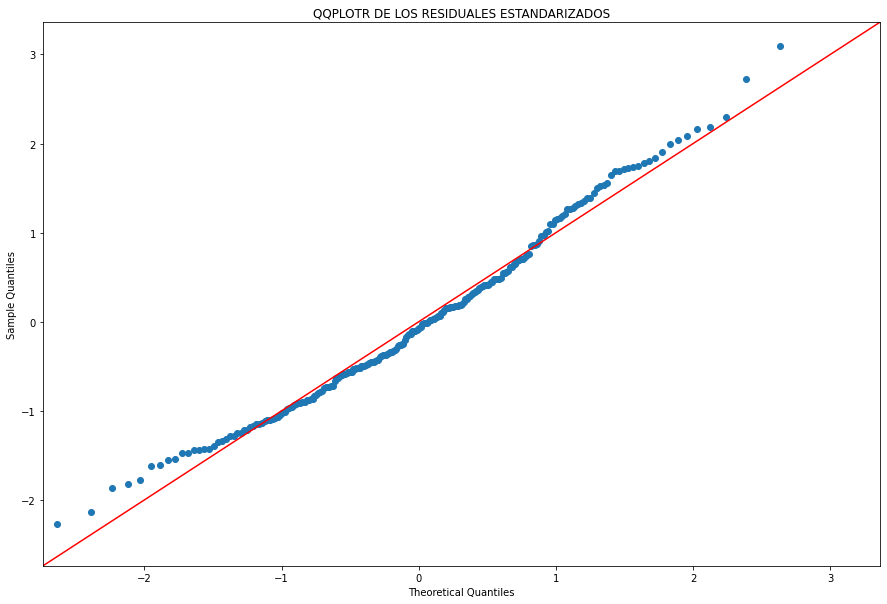

In [320]:
resid_standard = model.get_influence().resid_studentized_internal

fig , ax = plt.subplots(1,1,figsize=(15,10))
_ = sm.qqplot(resid_standard, line='45', ax=ax)
ax.set_title('QQPLOTR DE LOS RESIDUALES ESTANDARIZADOS')

In [321]:
stats.shapiro(resid_standard)

ShapiroResult(statistic=0.9841073751449585, pvalue=0.009681143797934055)

##### Kruskal-Wallis

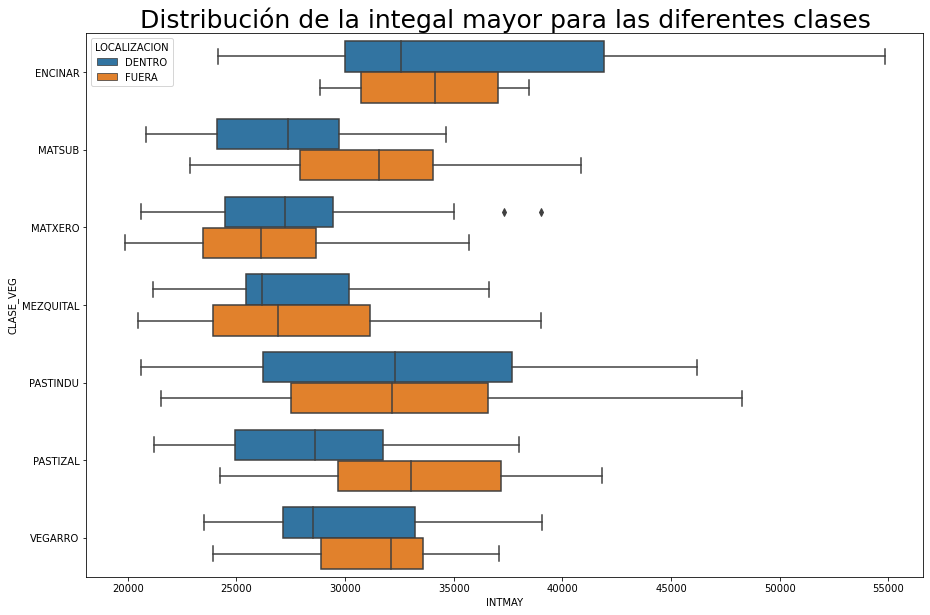

In [322]:
boxplots_variable_intergrupos(ts_evi, 'Distribución de la integal mayor para las diferentes clases', 'INTMAY', 'CLASE_VEG', 'LOCALIZACION')

In [323]:
print(prueba_kruskal_wallis(ts_evi, 'GRUPO', 'INTMAY'))

KruskalResult(statistic=56.79366270483746, pvalue=1.952344761636459e-07)


##### Pruebas Post Hoc: Tukey HSD

In [324]:
obj_tukey, _, comparaciones_dentro_fuera = prueba_tukey(ts_evi, 'GRUPO', 'INTMAY', 'CLASE_VEG')
comparaciones_dentro_fuera

0             group1           group2   meandiff   p-adj      lower  \
1     ENCINAR DENTRO    ENCINAR FUERA    -1864.5     0.9 -7780.1868   
26     MATSUB DENTRO     MATSUB FUERA  3845.2368  0.6289 -2147.7825   
47    MATXERO DENTRO    MATXERO FUERA    -1175.5     0.9 -7168.5193   
64  MEZQUITAL DENTRO  MEZQUITAL FUERA   277.1053     0.9  -5715.914   
77   PASTINDU DENTRO   PASTINDU FUERA      183.5     0.9 -5732.1868   
86   PASTIZAL DENTRO   PASTIZAL FUERA     4628.5  0.3154 -1287.1868   
91    VEGARRO DENTRO    VEGARRO FUERA  1007.2105     0.9 -4985.8088   

0        upper reject  
1    4051.1868  False  
26   9838.2561  False  
47   4817.5193  False  
64   6270.1246  False  
77   6099.1868  False  
86  10544.1868  False  
91   7000.2298  False

Text(0.5, 1.0, 'Intervalos de confianza para la media de cada grupo')

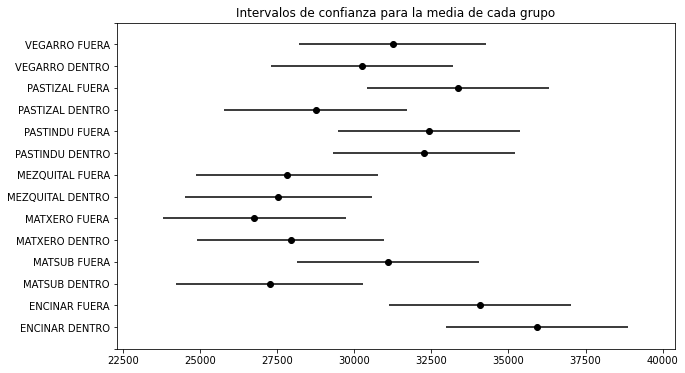

In [325]:
fig , ax = plt.subplots(1,1,figsize=(15,10))

_ = obj_tukey.plot_simultaneous(ax=ax)
ax.set_title('Intervalos de confianza para la media de cada grupo')

#### NDVI

In [326]:
ts_ndvi = pd.read_excel(datasets[1], usecols=columnas_importantes)
ts_ndvi = preparar_dataframe(ts_ndvi)
ts_ndvi['GRUPO'] = ts_ndvi.CLASE_VEG + ' ' + ts_ndvi.LOCALIZACION
ts_ndvi.head()

CLASE_VEG  INICIO  AMPLITUD  DURACION  INTMAY  INTMEN LOCALIZACION  \
0   ENCINAR  177.44      3145    230.56   70050   33880       DENTRO   
1   ENCINAR  177.44      3019    302.40   89970   42230       DENTRO   
2   ENCINAR  187.04      2814    286.08   79660   33570       DENTRO   
3   ENCINAR  206.40      3614    277.76   83110   39800       DENTRO   
4   ENCINAR  201.60      2878    292.16   81110   36720       DENTRO   

            GRUPO  
0  ENCINAR DENTRO  
1  ENCINAR DENTRO  
2  ENCINAR DENTRO  
3  ENCINAR DENTRO  
4  ENCINAR DENTRO

##### Localización de datos atípicos

Revisamos si existen datos atípicos

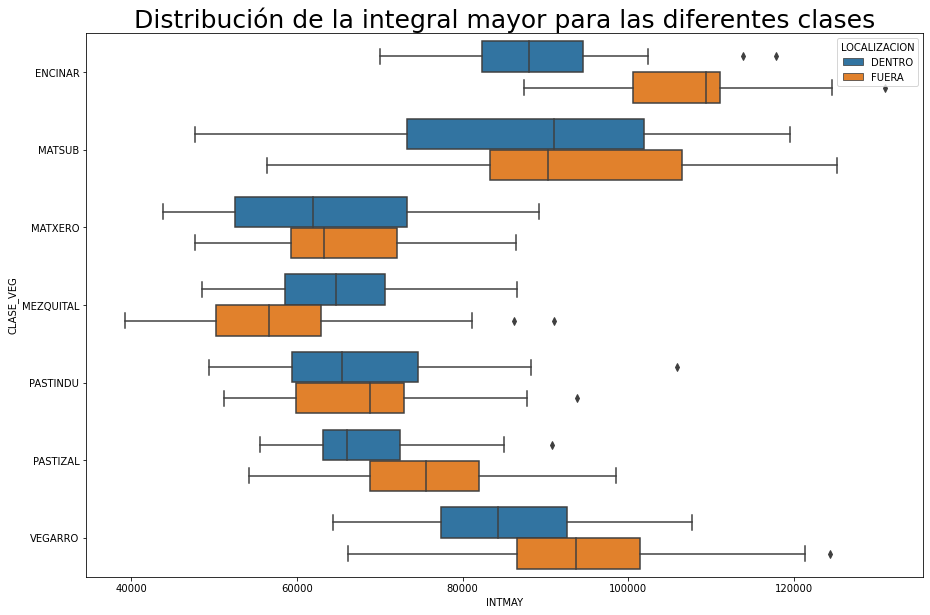

In [327]:
boxplots_variable_intergrupos(
    ts_ndvi, 
    'Distribución de la integral mayor para las diferentes clases', 
    'INTMAY', 
    'CLASE_VEG', 
    'LOCALIZACION'
)

# de outliers identificados: 9


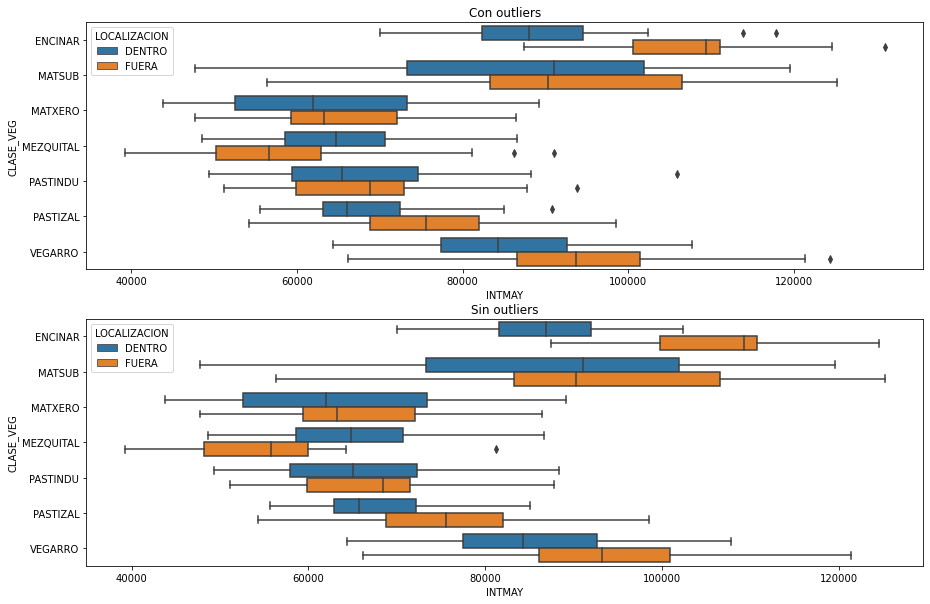

In [328]:
ts_ndvi['outlier'] = 0
idx_col_outliers = ts_ndvi.columns.to_list().index('outlier')

identificacion_outliers(
    ts_ndvi,
    'GRUPO',
    'INTMAY',
    idx_col_outliers,
    'CLASE_VEG',
    'LOCALIZACION'
)

##### Conteo del número de observaciones por grupo

Revisamos el número de muestras en cada grupo

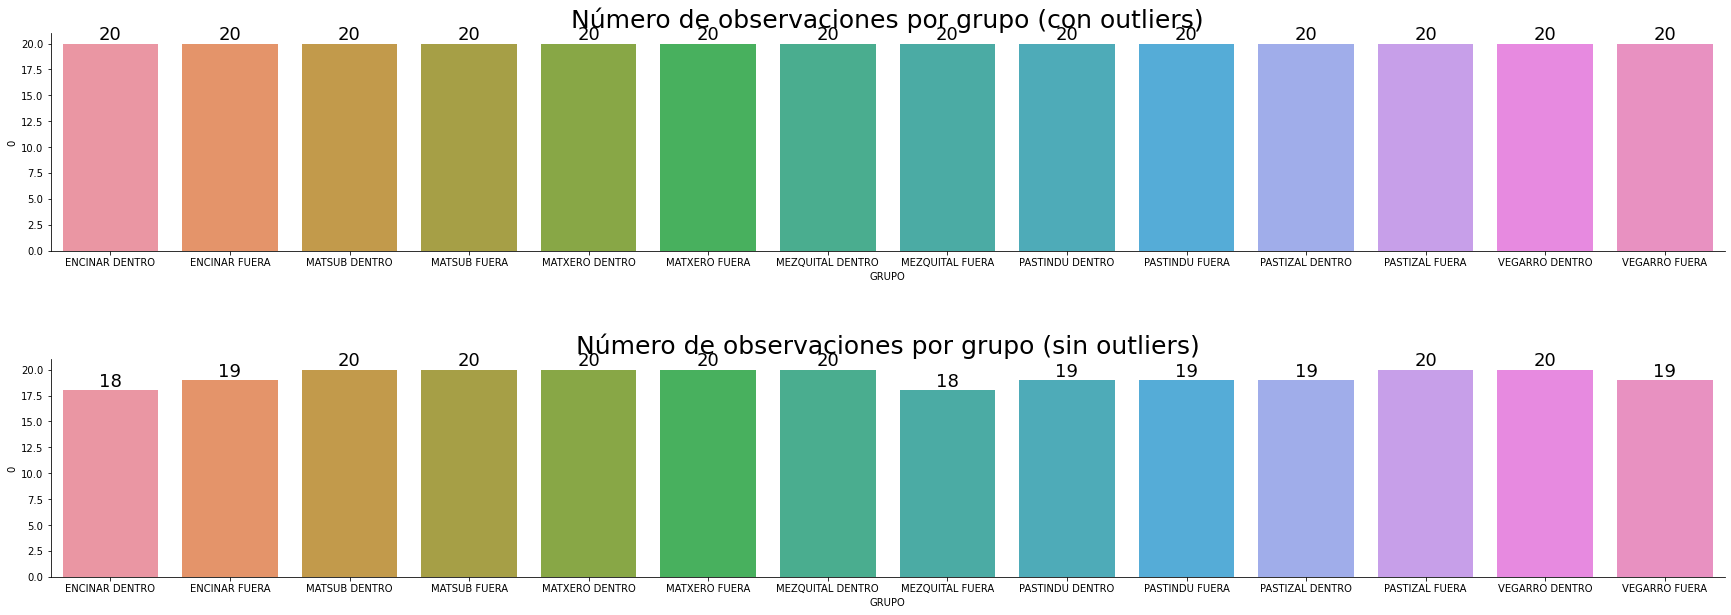

In [329]:
revisar_num_muestras_por_grupo(ts_ndvi, 'GRUPO', idx_col_outliers)

##### Revisión del supuesto de normalidad

Ahora se revisará el supuesto de normalidad

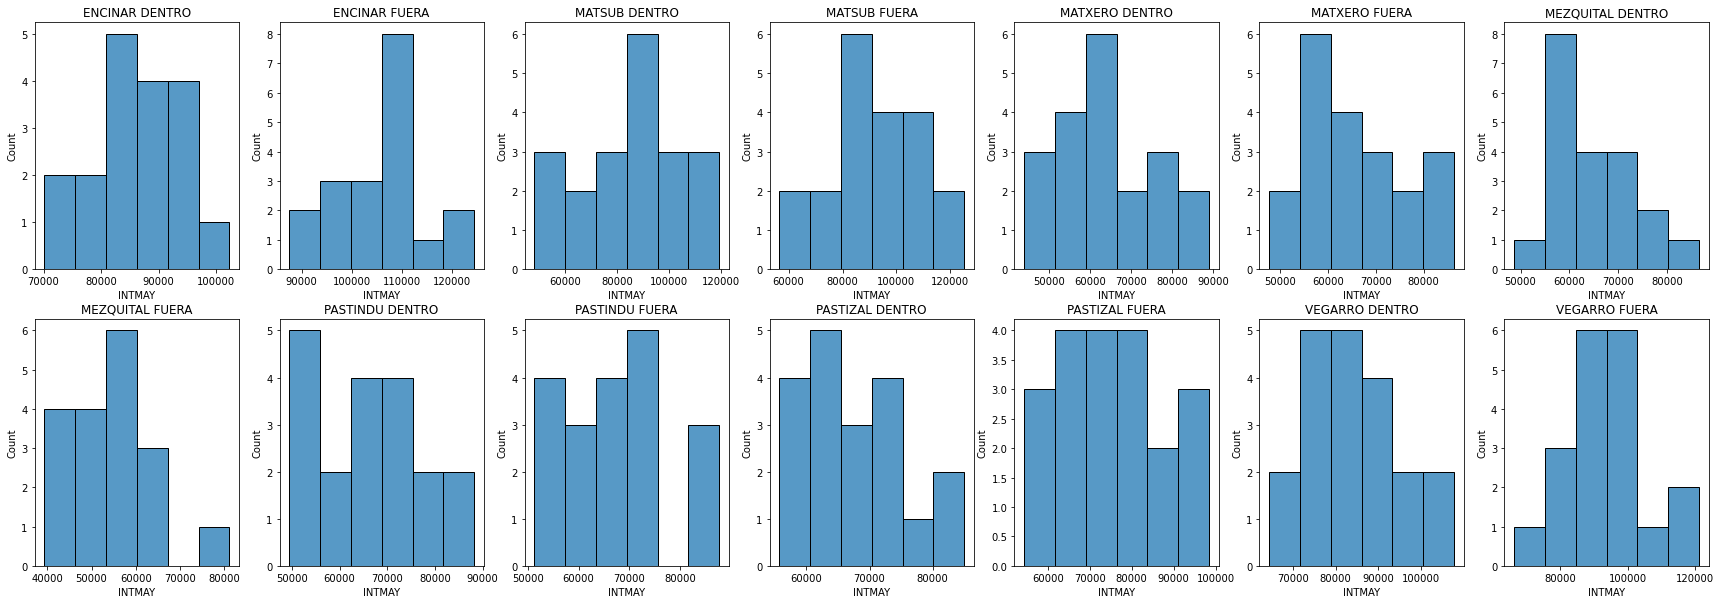

In [330]:
ts_ndvi = ts_ndvi[ts_ndvi.outlier == 0].copy()
histogramas_por_clase(ts_ndvi, 'GRUPO', 'INTMAY')

In [331]:
resultados_test_norm = pruebas_normalidad_shapiro(ts_ndvi, 'GRUPO', 'INTMAY')
resultados_test_norm[resultados_test_norm.pvalor > .05]

grupo         W    pvalor
0     ENCINAR DENTRO  0.983440  0.978450
1      ENCINAR FUERA  0.957320  0.520811
2      MATSUB DENTRO  0.965904  0.667129
3       MATSUB FUERA  0.976555  0.882337
4     MATXERO DENTRO  0.960327  0.550399
5      MATXERO FUERA  0.960415  0.552180
6   MEZQUITAL DENTRO  0.972329  0.803111
7    MEZQUITAL FUERA  0.945261  0.355569
8    PASTINDU DENTRO  0.958338  0.540093
9     PASTINDU FUERA  0.963614  0.645305
10   PASTIZAL DENTRO  0.959795  0.568347
11    PASTIZAL FUERA  0.986474  0.989142
12    VEGARRO DENTRO  0.968262  0.717830
13     VEGARRO FUERA  0.983923  0.977962

##### Revisión del supuesto de homogeneidad de varianzas

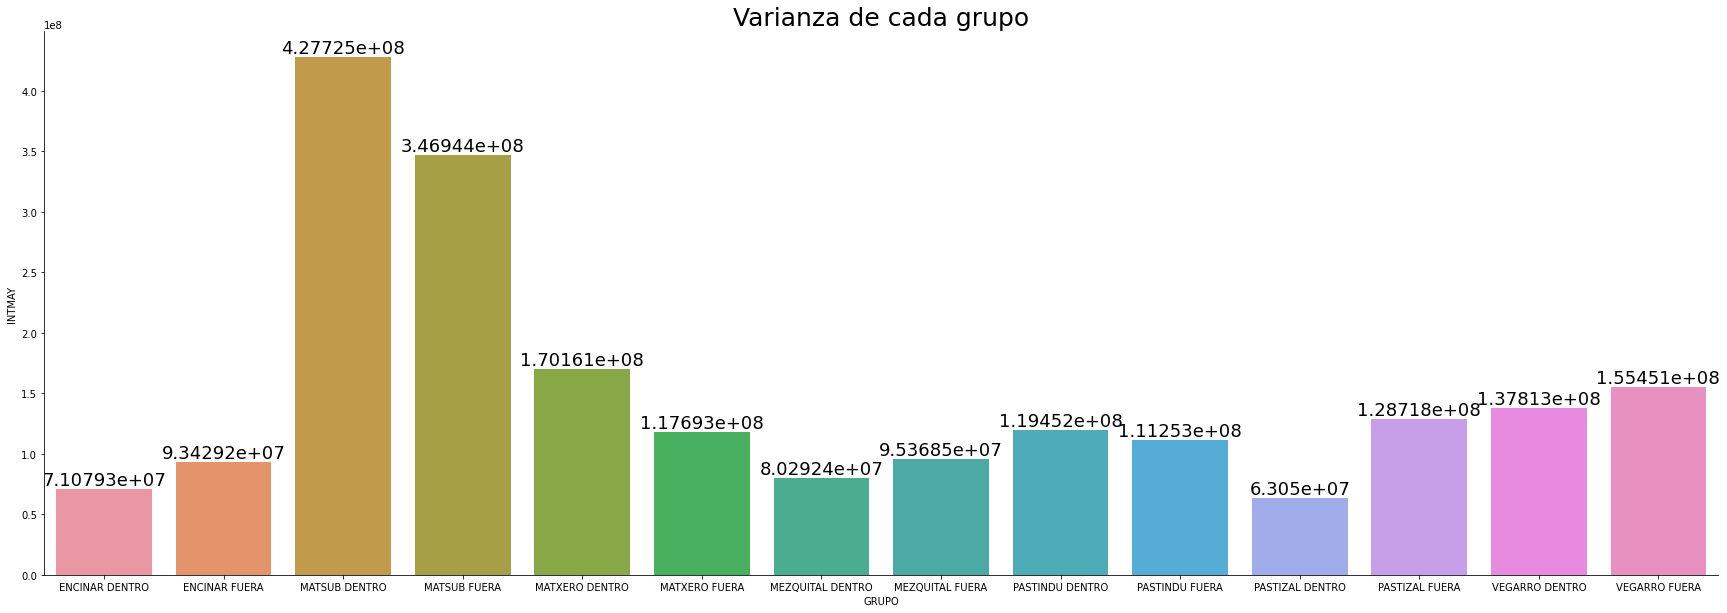

In [332]:
graficar_varianzas_intergrupos(ts_ndvi, 'GRUPO', 'INTMAY')

In [333]:
print(prueba_levene(ts_ndvi, 'GRUPO', 'INTMAY'))

LeveneResult(statistic=2.9611709089520897, pvalue=0.00047402059117495227)


In [334]:
df = ts_ndvi
col_grupos = 'GRUPO'
col_variable = 'INTMAY'
levene = stats.levene(
        df[df[col_grupos] == 'ENCINAR DENTRO'][col_variable],
        df[df[col_grupos] == 'ENCINAR FUERA'][col_variable],
        #df[df[col_grupos] == 'MATSUB DENTRO'][col_variable],
        #df[df[col_grupos] == 'MATSUB FUERA'][col_variable],
        df[df[col_grupos] == 'MATXERO DENTRO'][col_variable],
        df[df[col_grupos] == 'MATXERO FUERA'][col_variable],
        df[df[col_grupos] == 'MEZQUITAL DENTRO'][col_variable],
        df[df[col_grupos] == 'MEZQUITAL FUERA'][col_variable],
        df[df[col_grupos] == 'PASTINDU DENTRO'][col_variable],
        df[df[col_grupos] == 'PASTINDU FUERA'][col_variable],
        df[df[col_grupos] == 'PASTIZAL DENTRO'][col_variable],
        df[df[col_grupos] == 'PASTIZAL FUERA'][col_variable],
        df[df[col_grupos] == 'VEGARRO DENTRO'][col_variable],
        df[df[col_grupos] == 'VEGARRO FUERA'][col_variable]
)

levene

LeveneResult(statistic=0.669002278631425, pvalue=0.7670457190792987)

##### Análisis de varianza  

In [335]:
# Ordinary Least Squares (OLS) model
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('INTMAY ~ C(GRUPO)', data=ts_ndvi[~ts_ndvi.GRUPO.str.contains('MATSUB')]).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

             df        sum_sq       mean_sq          F        PR(>F)
C(GRUPO)   11.0  4.637820e+10  4.216200e+09  37.449344  2.305972e-44
Residual  219.0  2.465591e+10  1.125841e+08        NaN           NaN


Text(0.5, 1.0, 'QQPLOTR DE LOS RESIDUALES ESTANDARIZADOS')

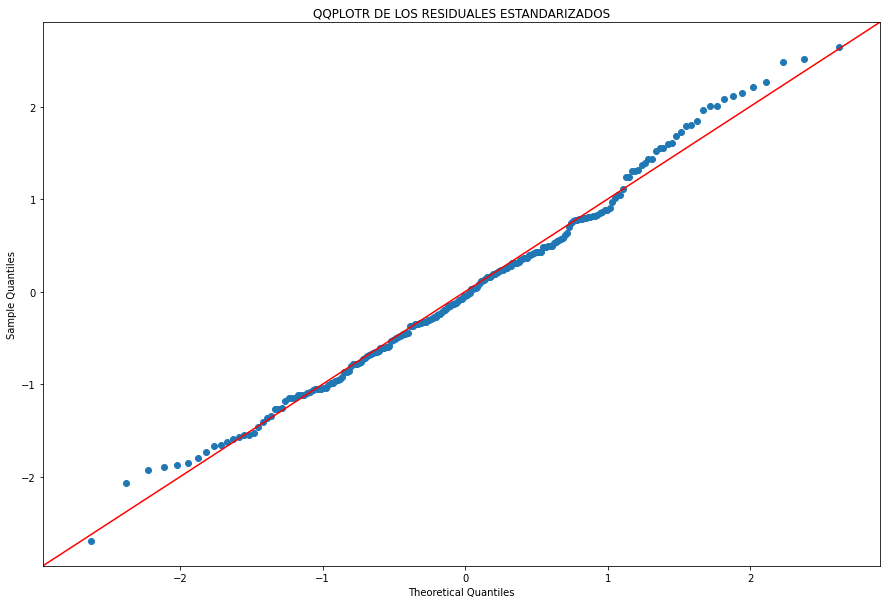

In [336]:
resid_standard = model.get_influence().resid_studentized_internal

fig , ax = plt.subplots(1,1,figsize=(15,10))
_ = sm.qqplot(resid_standard, line='45', ax=ax)
ax.set_title('QQPLOTR DE LOS RESIDUALES ESTANDARIZADOS')

In [337]:
stats.shapiro(resid_standard)

ShapiroResult(statistic=0.9910129904747009, pvalue=0.16569843888282776)

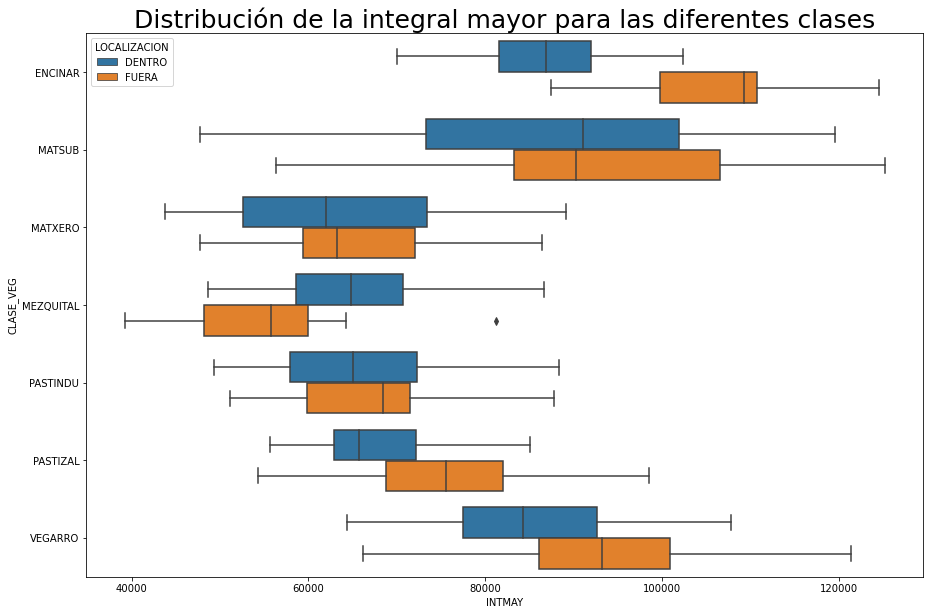

In [338]:
boxplots_variable_intergrupos(ts_ndvi, 'Distribución de la integral mayor para las diferentes clases', 'INTMAY', 'CLASE_VEG', 'LOCALIZACION')

##### Pruebas Post Hoc: Tukey HSD

In [339]:
obj_tukey, _, comparaciones_dentro_fuera = prueba_tukey(ts_ndvi, 'GRUPO', 'INTMAY', 'CLASE_VEG')
comparaciones_dentro_fuera

0             group1           group2    meandiff   p-adj       lower  \
1     ENCINAR DENTRO    ENCINAR FUERA  19709.2982   0.001   5922.7342   
26     MATSUB DENTRO     MATSUB FUERA      6182.5     0.9   -7072.149   
47    MATXERO DENTRO    MATXERO FUERA      2189.0     0.9  -11065.649   
64  MEZQUITAL DENTRO  MEZQUITAL FUERA  -9854.6667  0.4511  -23472.524   
77   PASTINDU DENTRO   PASTINDU FUERA   1008.9474     0.9 -12590.0356   
86   PASTIZAL DENTRO   PASTIZAL FUERA   8421.8421  0.6594  -5006.0777   
91    VEGARRO DENTRO    VEGARRO FUERA   9668.1842  0.4596  -3759.7356   

0        upper reject  
1   33495.8623   True  
26   19437.149  False  
47   15443.649  False  
64   3763.1907  False  
77  14607.9303  False  
86  21849.7619  False  
91   23096.104  False

Text(0.5, 1.0, 'Intervalos de confianza para la media de cada grupo')

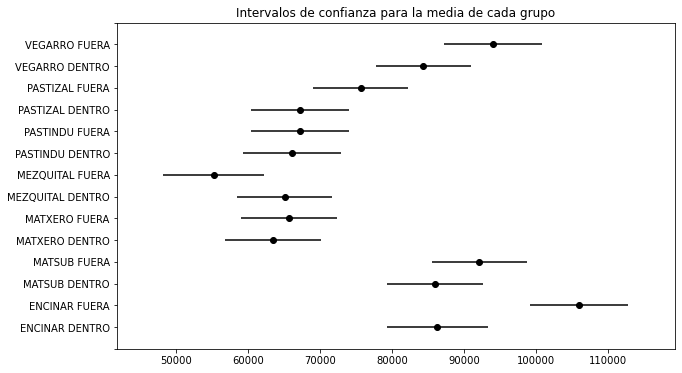

In [340]:
fig , ax = plt.subplots(1,1,figsize=(15,10))

_ = obj_tukey.plot_simultaneous(ax=ax)
ax.set_title('Intervalos de confianza para la media de cada grupo')

### INTEGRAL MENOR

#### EVI

In [341]:
ts_evi = pd.read_excel(datasets[0], usecols=columnas_importantes)
ts_evi = preparar_dataframe(ts_evi)
ts_evi['GRUPO'] = ts_evi.CLASE_VEG + ' ' + ts_evi.LOCALIZACION
ts_evi.head()

CLASE_VEG  INICIO  AMPLITUD  DURACION  INTMAY  INTMEN LOCALIZACION  \
0   ENCINAR  172.96      1987   167.360   32030   13410       DENTRO   
1   ENCINAR  172.96      1972   148.272   30020   12640       DENTRO   
2   ENCINAR  192.16      1782   133.152   24720   10770       DENTRO   
3   ENCINAR  207.36      2162   258.880   41990   16480       DENTRO   
4   ENCINAR  203.20      1629   268.640   40850   14580       DENTRO   

            GRUPO  
0  ENCINAR DENTRO  
1  ENCINAR DENTRO  
2  ENCINAR DENTRO  
3  ENCINAR DENTRO  
4  ENCINAR DENTRO

##### Localización de datos atípicos

Revisamos si existen datos atípicos

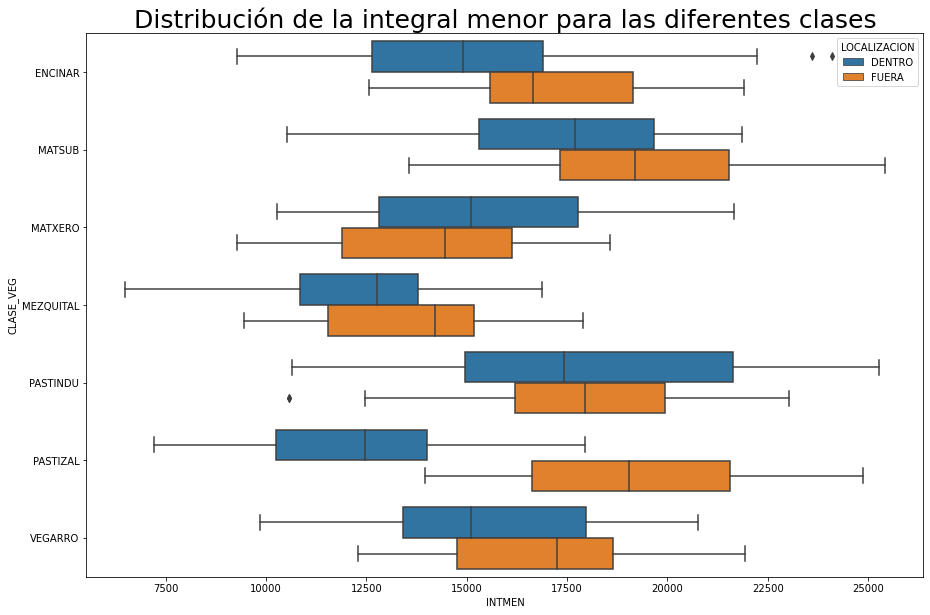

In [342]:
boxplots_variable_intergrupos(
    ts_evi, 
    'Distribución de la integral menor para las diferentes clases', 
    'INTMEN', 
    'CLASE_VEG', 
    'LOCALIZACION'
)

# de outliers identificados: 4


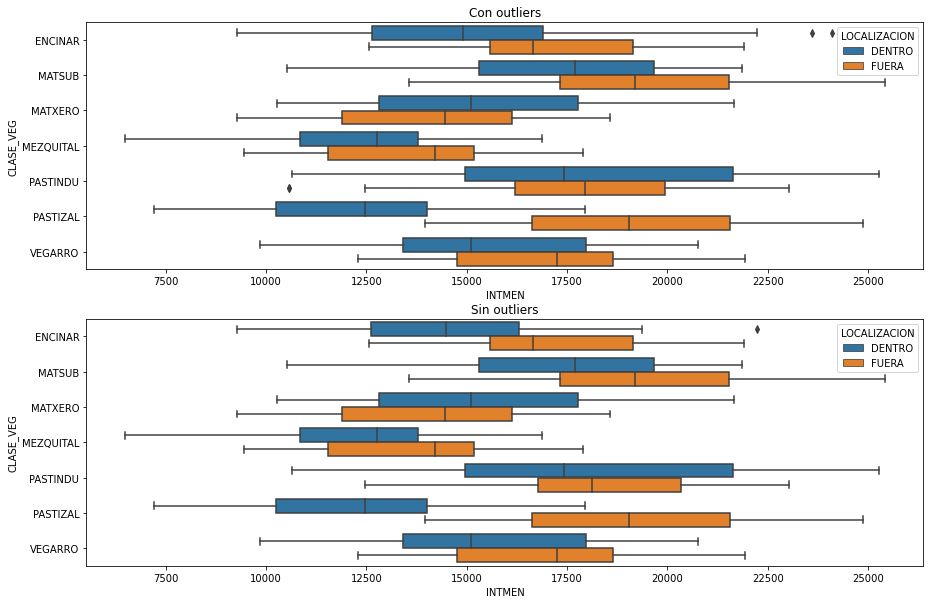

In [343]:
ts_evi['outlier'] = 0
idx_col_outliers = ts_evi.columns.to_list().index('outlier')

identificacion_outliers(
    ts_evi,
    'GRUPO',
    'INTMEN',
    idx_col_outliers,
    'CLASE_VEG',
    'LOCALIZACION'
)

##### Conteo del número de observaciones por grupo

Revisamos el número de muestras en cada grupo

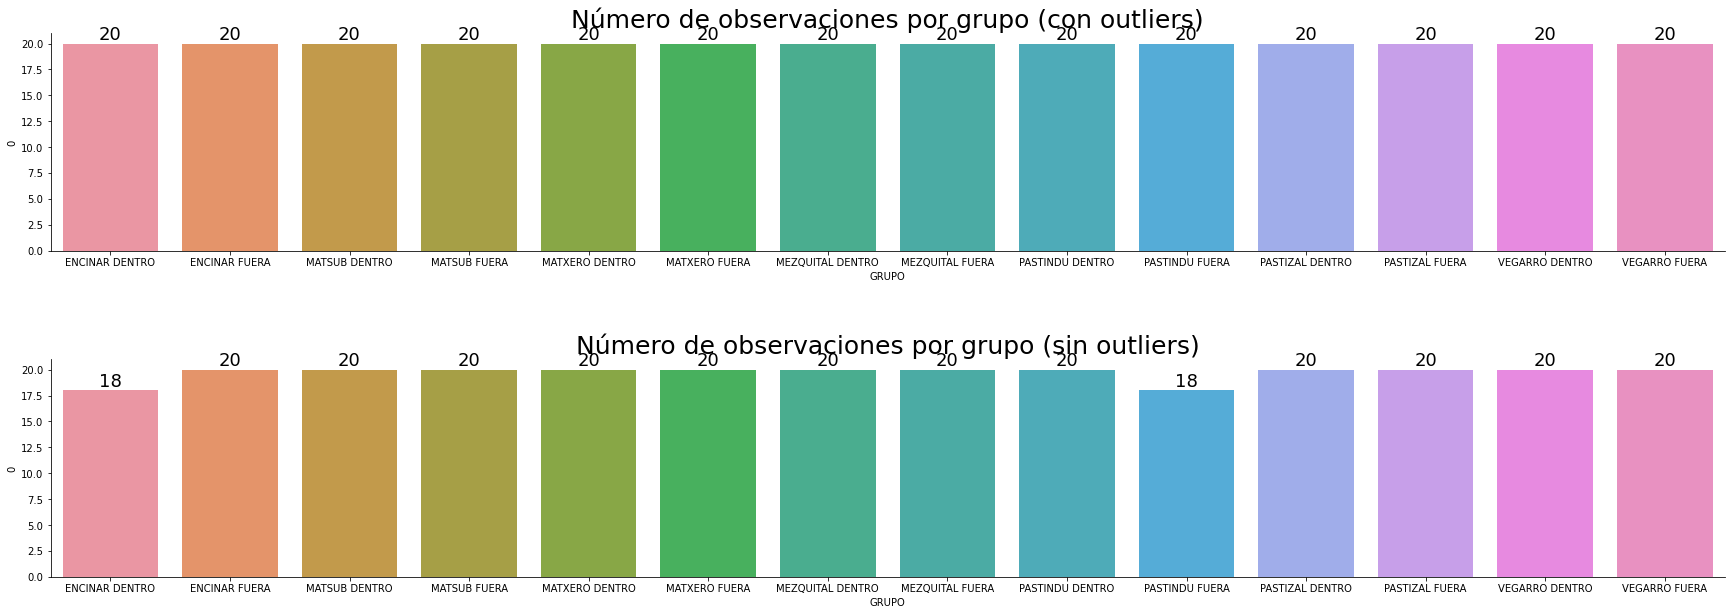

In [344]:
revisar_num_muestras_por_grupo(ts_evi, 'GRUPO', idx_col_outliers)

##### Revisión del supuesto de normalidad

Ahora se revisará el supuesto de normalidad

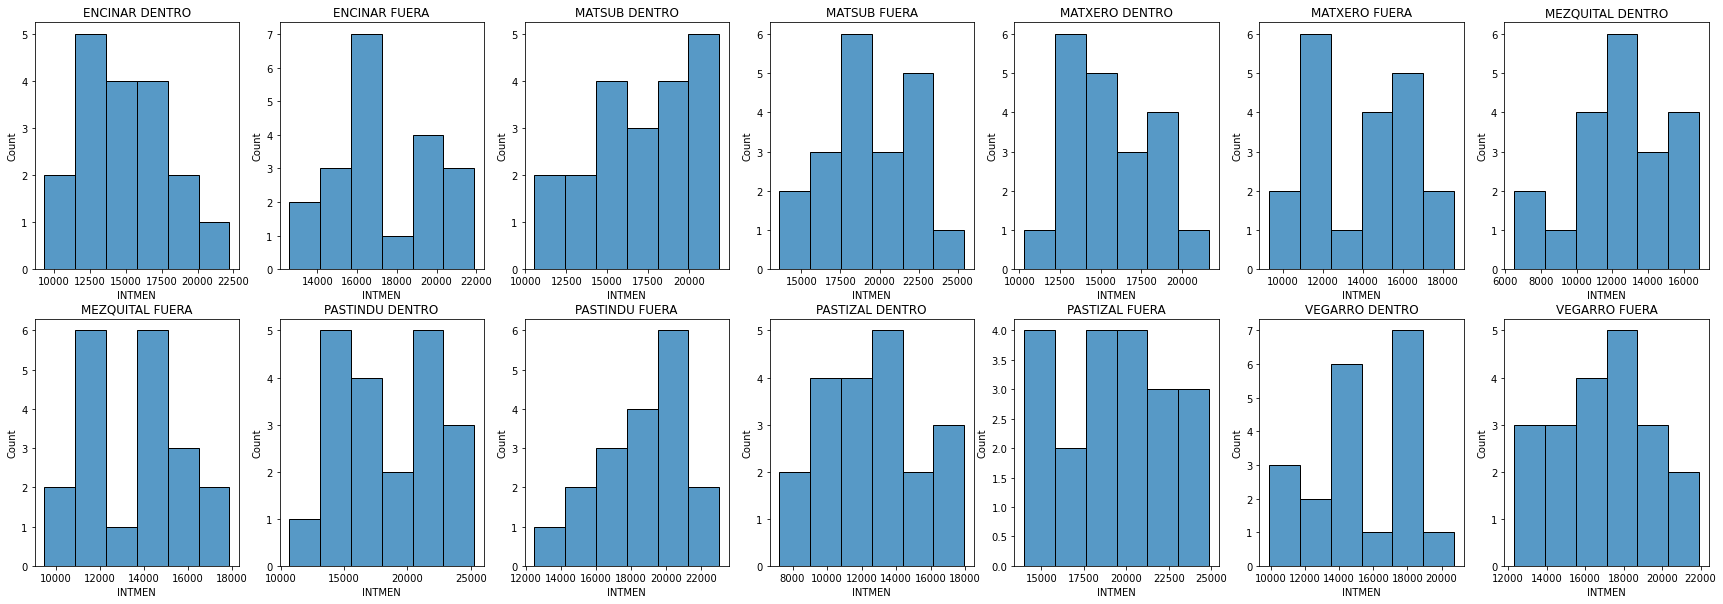

In [345]:
ts_evi = ts_evi[ts_evi.outlier == 0].copy()
histogramas_por_clase(ts_evi, 'GRUPO', 'INTMEN')

In [346]:
resultados_test_norm = pruebas_normalidad_shapiro(ts_evi, 'GRUPO', 'INTMEN')
resultados_test_norm[resultados_test_norm.pvalor > .05]

grupo         W    pvalor
0     ENCINAR DENTRO  0.974399  0.875096
1      ENCINAR FUERA  0.968451  0.721882
2      MATSUB DENTRO  0.965593  0.660457
3       MATSUB FUERA  0.991190  0.999210
4     MATXERO DENTRO  0.969918  0.753137
5      MATXERO FUERA  0.961692  0.578176
6   MEZQUITAL DENTRO  0.968203  0.716569
7    MEZQUITAL FUERA  0.958616  0.516590
8    PASTINDU DENTRO  0.951327  0.387676
9     PASTINDU FUERA  0.978914  0.938119
10   PASTIZAL DENTRO  0.966523  0.680430
11    PASTIZAL FUERA  0.967877  0.709554
12    VEGARRO DENTRO  0.963203  0.609633
13     VEGARRO FUERA  0.966652  0.683207

##### Revisión del supuesto de homogeneidad de varianzas

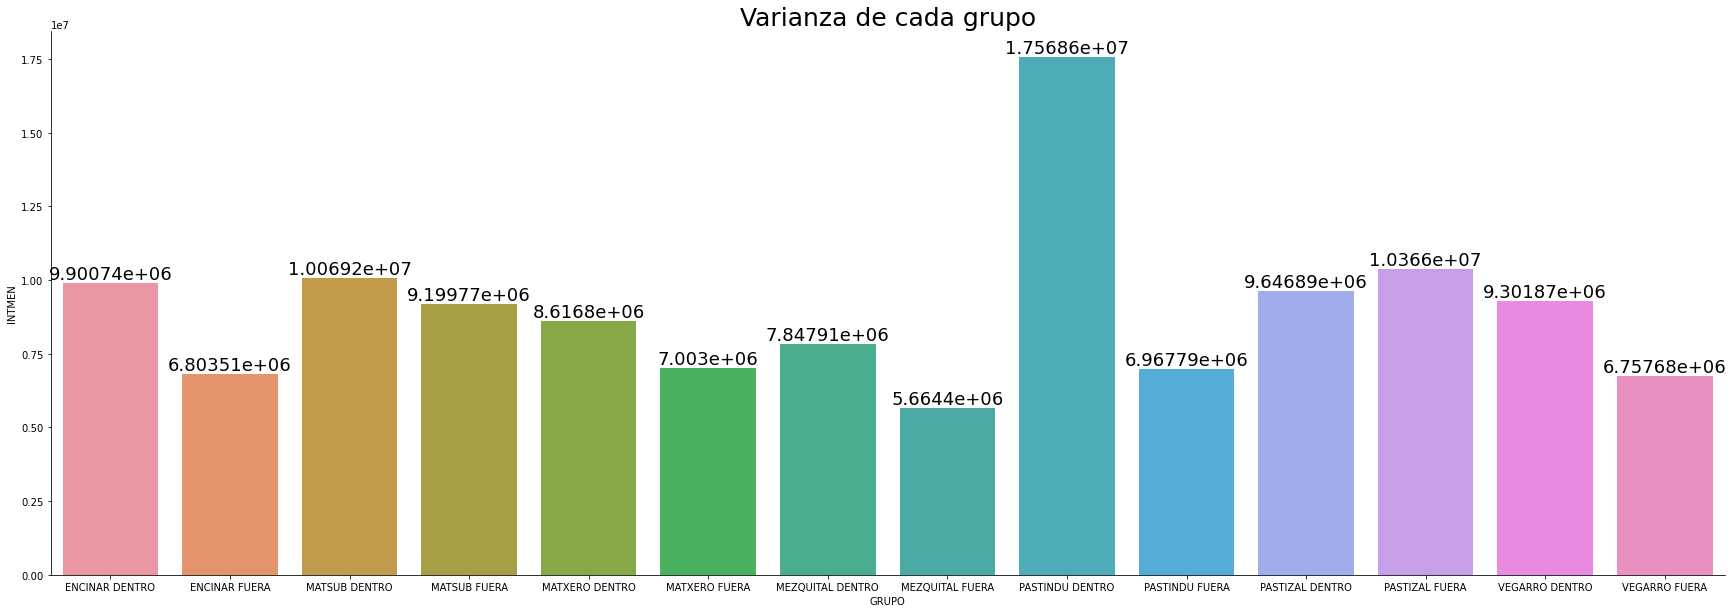

In [347]:
graficar_varianzas_intergrupos(ts_evi, 'GRUPO', 'INTMEN')

In [348]:
print(prueba_levene(ts_evi, 'GRUPO', 'INTMEN'))

LeveneResult(statistic=1.1586191067911153, pvalue=0.3105113990637126)


##### Análisis de varianza

In [349]:
# Ordinary Least Squares (OLS) model
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('INTMEN ~ C(GRUPO)', data=ts_evi).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

             df        sum_sq       mean_sq         F        PR(>F)
C(GRUPO)   13.0  1.429624e+09  1.099711e+08  12.23545  9.069641e-21
Residual  262.0  2.354831e+09  8.987906e+06       NaN           NaN


Text(0.5, 1.0, 'QQPLOT DE LOS RESIDUALES ESTANDARIZADOS')

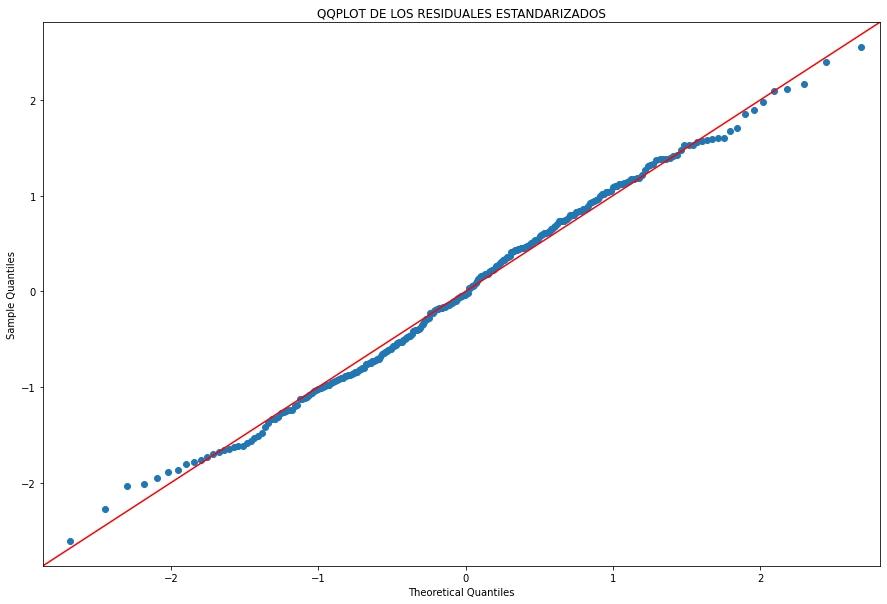

In [350]:
resid_standard = model.get_influence().resid_studentized_internal

fig , ax = plt.subplots(1,1,figsize=(15,10))
_ = sm.qqplot(resid_standard, line='45', ax=ax)
ax.set_title('QQPLOT DE LOS RESIDUALES ESTANDARIZADOS')

In [351]:
stats.shapiro(resid_standard)

ShapiroResult(statistic=0.993130087852478, pvalue=0.2363690584897995)

##### Kruskal-Wallis

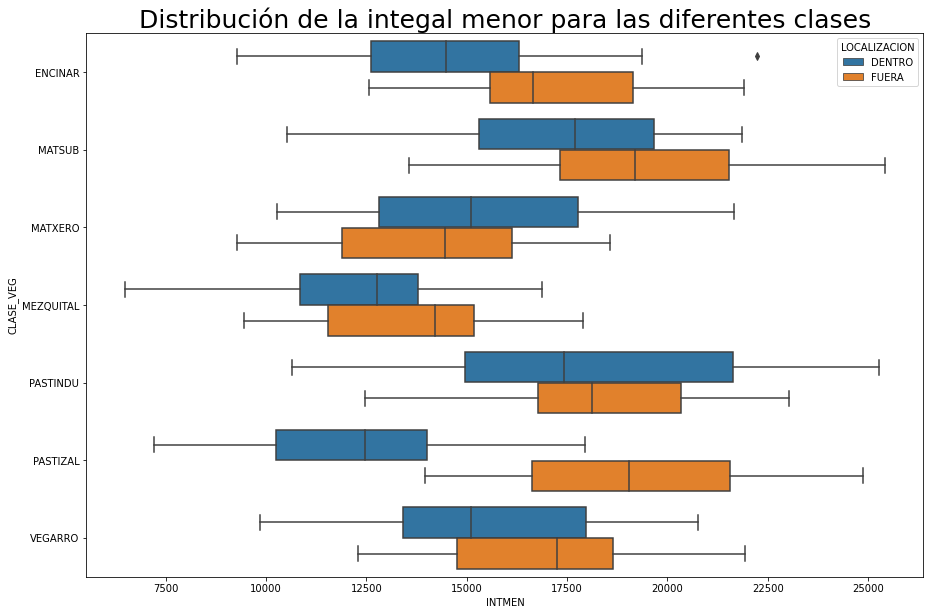

In [352]:
boxplots_variable_intergrupos(ts_evi, 'Distribución de la integal menor para las diferentes clases', 'INTMEN', 'CLASE_VEG', 'LOCALIZACION')

In [353]:
print(prueba_kruskal_wallis(ts_evi, 'GRUPO', 'INTMEN'))

KruskalResult(statistic=102.36982774617601, pvalue=5.754584535075992e-16)


##### Pruebas Post Hoc: Tukey HSD

In [354]:
obj_tukey, _, comparaciones_dentro_fuera = prueba_tukey(ts_evi, 'GRUPO', 'INTMEN', 'CLASE_VEG')
comparaciones_dentro_fuera

0             group1           group2   meandiff   p-adj      lower  \
1     ENCINAR DENTRO    ENCINAR FUERA  2529.1667  0.3489  -768.5737   
26     MATSUB DENTRO     MATSUB FUERA     2094.5  0.6056 -1115.2848   
47    MATXERO DENTRO    MATXERO FUERA    -1463.6     0.9 -4673.3848   
64  MEZQUITAL DENTRO  MEZQUITAL FUERA    1171.15     0.9 -2038.6348   
77   PASTINDU DENTRO   PASTINDU FUERA    77.7222     0.9 -3220.0181   
86   PASTIZAL DENTRO   PASTIZAL FUERA     6677.6   0.001  3467.8152   
91    VEGARRO DENTRO    VEGARRO FUERA     1608.0     0.9 -1601.7848   

0       upper reject  
1    5826.907  False  
26  5304.2848  False  
47  1746.1848  False  
64  4380.9348  False  
77  3375.4626  False  
86  9887.3848   True  
91  4817.7848  False

Text(0.5, 1.0, 'Intervalos de confianza para la media de cada grupo')

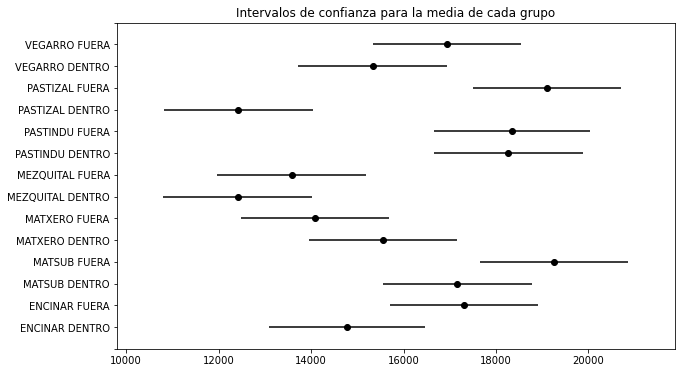

In [355]:
fig , ax = plt.subplots(1,1,figsize=(15,10))

_ = obj_tukey.plot_simultaneous(ax=ax)
ax.set_title('Intervalos de confianza para la media de cada grupo')

#### NDVI

In [356]:
ts_ndvi = pd.read_excel(datasets[1], usecols=columnas_importantes)
ts_ndvi = preparar_dataframe(ts_ndvi)
ts_ndvi['GRUPO'] = ts_ndvi.CLASE_VEG + ' ' + ts_ndvi.LOCALIZACION
ts_ndvi.head()

CLASE_VEG  INICIO  AMPLITUD  DURACION  INTMAY  INTMEN LOCALIZACION  \
0   ENCINAR  177.44      3145    230.56   70050   33880       DENTRO   
1   ENCINAR  177.44      3019    302.40   89970   42230       DENTRO   
2   ENCINAR  187.04      2814    286.08   79660   33570       DENTRO   
3   ENCINAR  206.40      3614    277.76   83110   39800       DENTRO   
4   ENCINAR  201.60      2878    292.16   81110   36720       DENTRO   

            GRUPO  
0  ENCINAR DENTRO  
1  ENCINAR DENTRO  
2  ENCINAR DENTRO  
3  ENCINAR DENTRO  
4  ENCINAR DENTRO

##### Localización de datos atípicos

Revisamos si existen datos atípicos

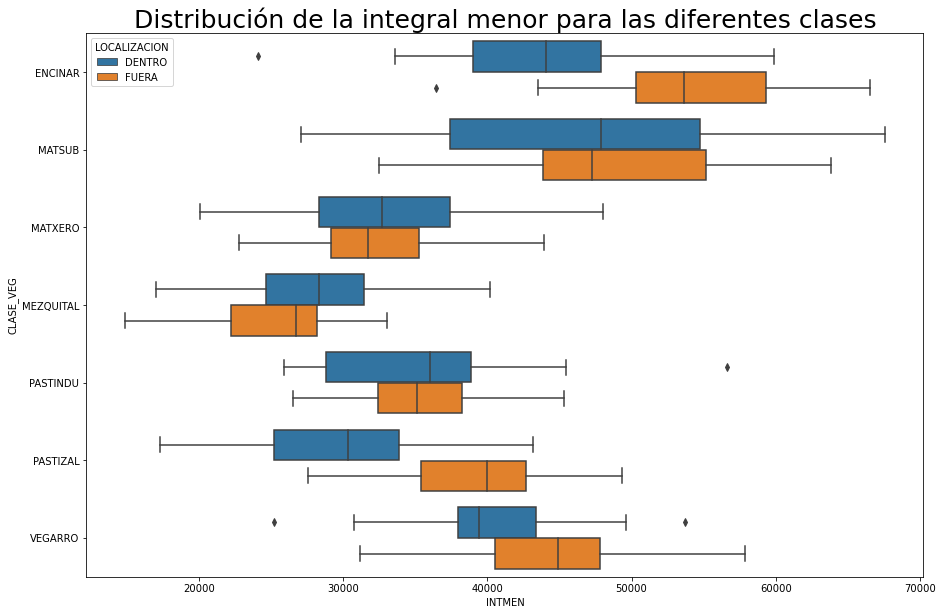

In [357]:
boxplots_variable_intergrupos(
    ts_ndvi, 
    'Distribución de la integral menor para las diferentes clases', 
    'INTMEN', 
    'CLASE_VEG', 
    'LOCALIZACION'
)

# de outliers identificados: 5


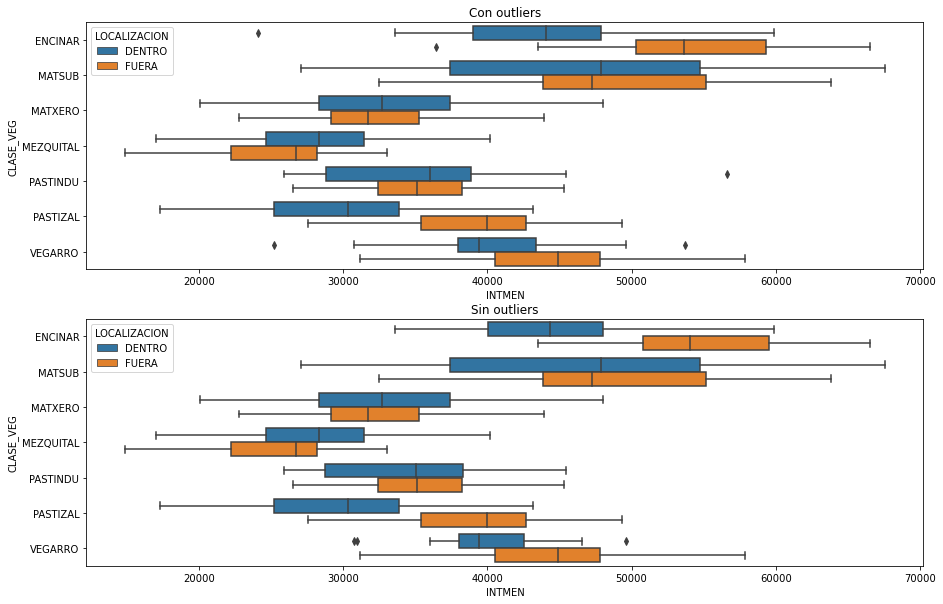

In [358]:
ts_ndvi['outlier'] = 0
idx_col_outliers = ts_ndvi.columns.to_list().index('outlier')

identificacion_outliers(
    ts_ndvi,
    'GRUPO',
    'INTMEN',
    idx_col_outliers,
    'CLASE_VEG',
    'LOCALIZACION'
)

##### Conteo del número de observaciones por grupo

Revisamos el número de muestras en cada grupo

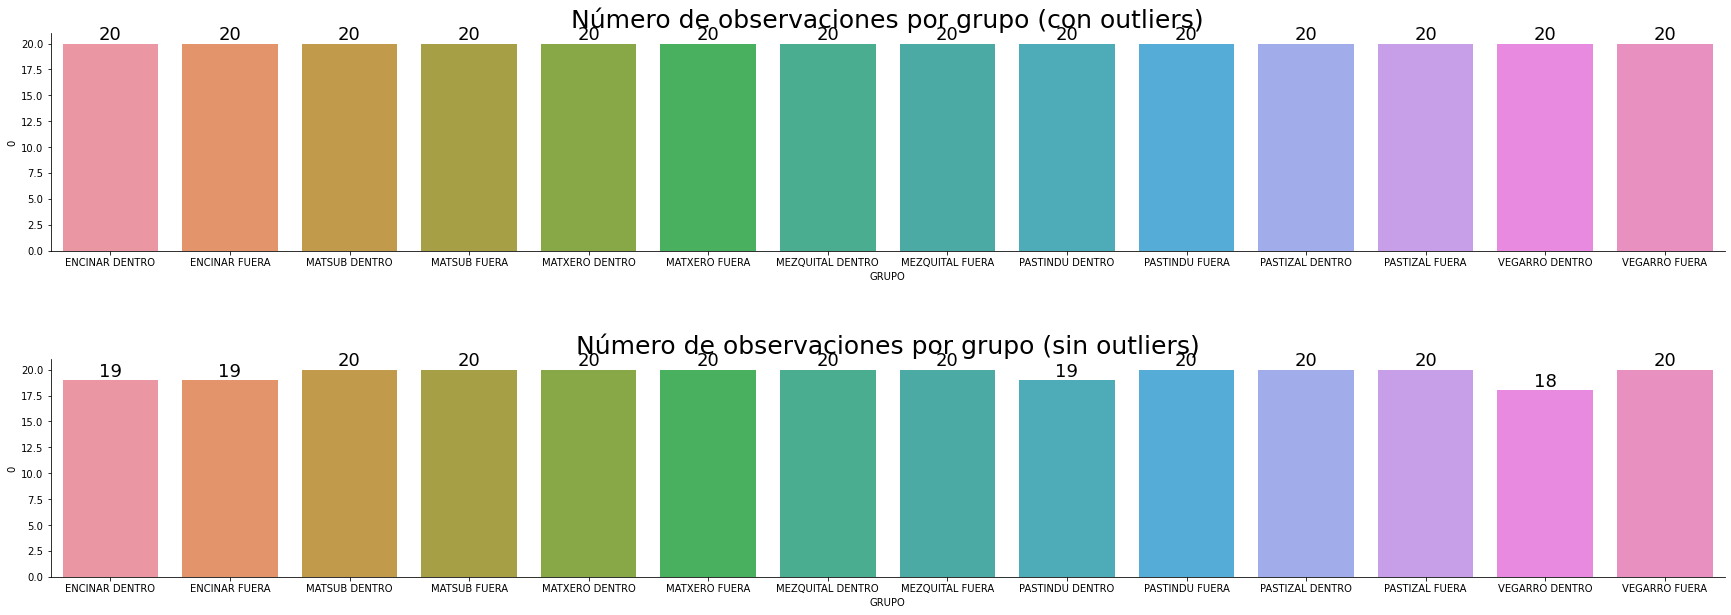

In [359]:
revisar_num_muestras_por_grupo(ts_ndvi, 'GRUPO', idx_col_outliers)

##### Revisión del supuesto de normalidad

Ahora se revisará el supuesto de normalidad

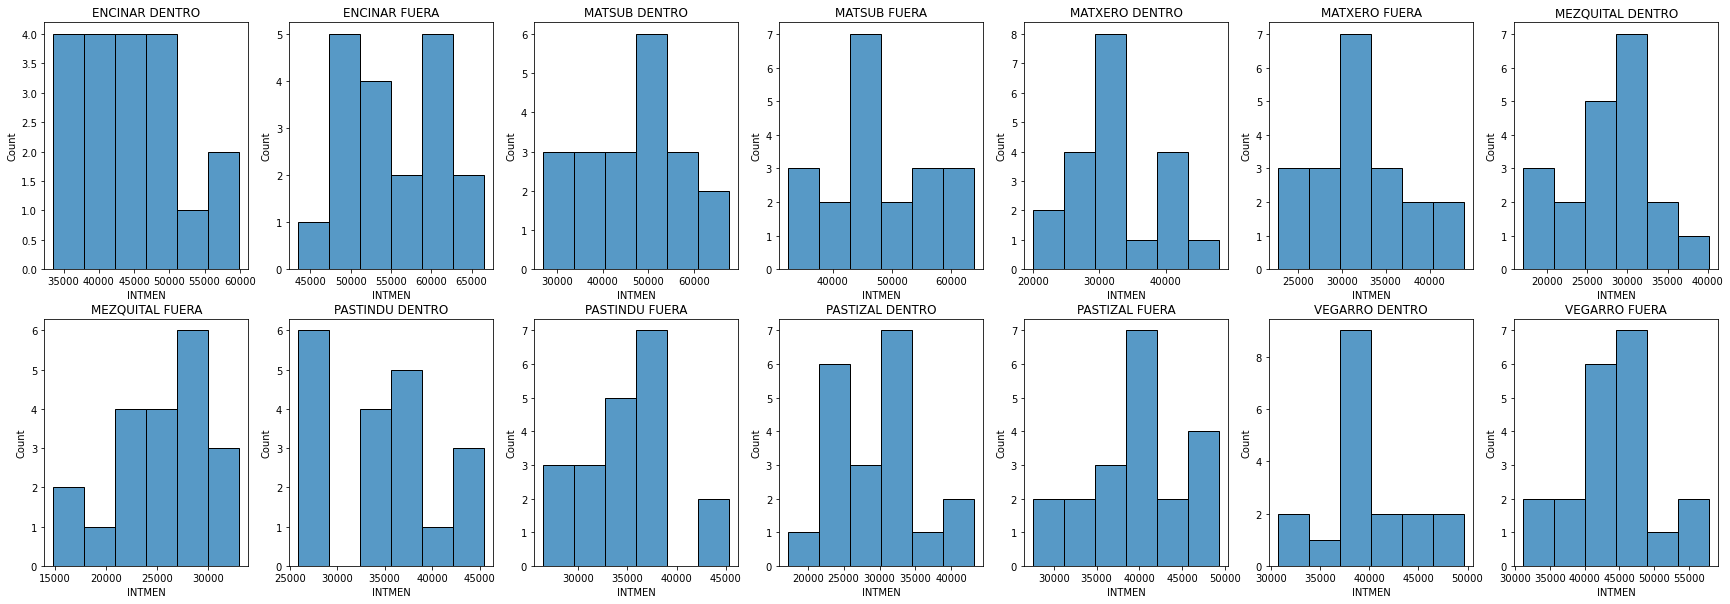

In [360]:
ts_ndvi = ts_ndvi[ts_ndvi.outlier == 0].copy()
histogramas_por_clase(ts_ndvi, 'GRUPO', 'INTMEN')

In [361]:
resultados_test_norm = pruebas_normalidad_shapiro(ts_ndvi, 'GRUPO', 'INTMEN')
resultados_test_norm[resultados_test_norm.pvalor > .05]

grupo         W    pvalor
0     ENCINAR DENTRO  0.956369  0.503159
1      ENCINAR FUERA  0.977246  0.905850
2      MATSUB DENTRO  0.971099  0.777906
3       MATSUB FUERA  0.958830  0.520742
4     MATXERO DENTRO  0.978959  0.919959
5      MATXERO FUERA  0.976315  0.878244
6   MEZQUITAL DENTRO  0.967359  0.698423
7    MEZQUITAL FUERA  0.961334  0.570838
8    PASTINDU DENTRO  0.938482  0.247564
9     PASTINDU FUERA  0.975698  0.867443
10   PASTIZAL DENTRO  0.970988  0.775597
11    PASTIZAL FUERA  0.967104  0.692928
12    VEGARRO DENTRO  0.941923  0.312483
13     VEGARRO FUERA  0.975384  0.861820

##### Revisión del supuesto de homogeneidad de varianzas

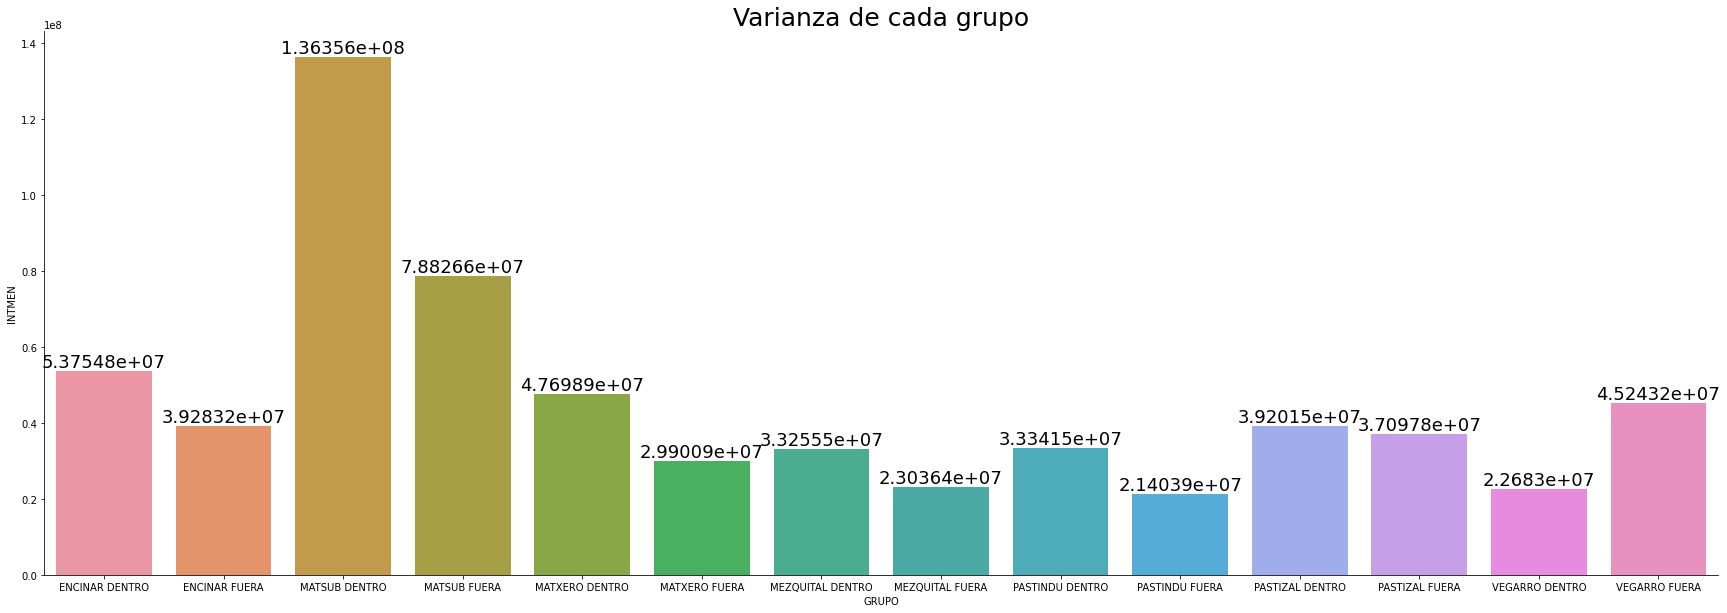

In [362]:
graficar_varianzas_intergrupos(ts_ndvi, 'GRUPO', 'INTMEN')

In [363]:
print(prueba_levene(ts_ndvi, 'GRUPO', 'INTMEN'))

LeveneResult(statistic=2.703979140337483, pvalue=0.0013542225206963888)


In [364]:
df = ts_ndvi
col_grupos = 'GRUPO'
col_variable = 'INTMEN'
levene = stats.levene(
        df[df[col_grupos] == 'ENCINAR DENTRO'][col_variable],
        df[df[col_grupos] == 'ENCINAR FUERA'][col_variable],
        #df[df[col_grupos] == 'MATSUB DENTRO'][col_variable],
        #df[df[col_grupos] == 'MATSUB FUERA'][col_variable],
        df[df[col_grupos] == 'MATXERO DENTRO'][col_variable],
        df[df[col_grupos] == 'MATXERO FUERA'][col_variable],
        df[df[col_grupos] == 'MEZQUITAL DENTRO'][col_variable],
        df[df[col_grupos] == 'MEZQUITAL FUERA'][col_variable],
        df[df[col_grupos] == 'PASTINDU DENTRO'][col_variable],
        df[df[col_grupos] == 'PASTINDU FUERA'][col_variable],
        df[df[col_grupos] == 'PASTIZAL DENTRO'][col_variable],
        df[df[col_grupos] == 'PASTIZAL FUERA'][col_variable],
        df[df[col_grupos] == 'VEGARRO DENTRO'][col_variable],
        df[df[col_grupos] == 'VEGARRO FUERA'][col_variable]
)

levene

LeveneResult(statistic=0.7691054993485599, pvalue=0.6706971575646573)

##### Análisis de varianza  

In [365]:
# Ordinary Least Squares (OLS) model
import statsmodels.api as sm
from statsmodels.formula.api import ols

model = ols('INTMEN ~ C(GRUPO)', data=ts_ndvi[~ts_ndvi.GRUPO.str.contains('MATSUB')]).fit()
anova_table = sm.stats.anova_lm(model)
print(anova_table)

             df        sum_sq       mean_sq          F        PR(>F)
C(GRUPO)   11.0  1.479365e+10  1.344877e+09  37.865378  4.966693e-45
Residual  223.0  7.920366e+09  3.551734e+07        NaN           NaN


Text(0.5, 1.0, 'QQPLOTR DE LOS RESIDUALES ESTANDARIZADOS')

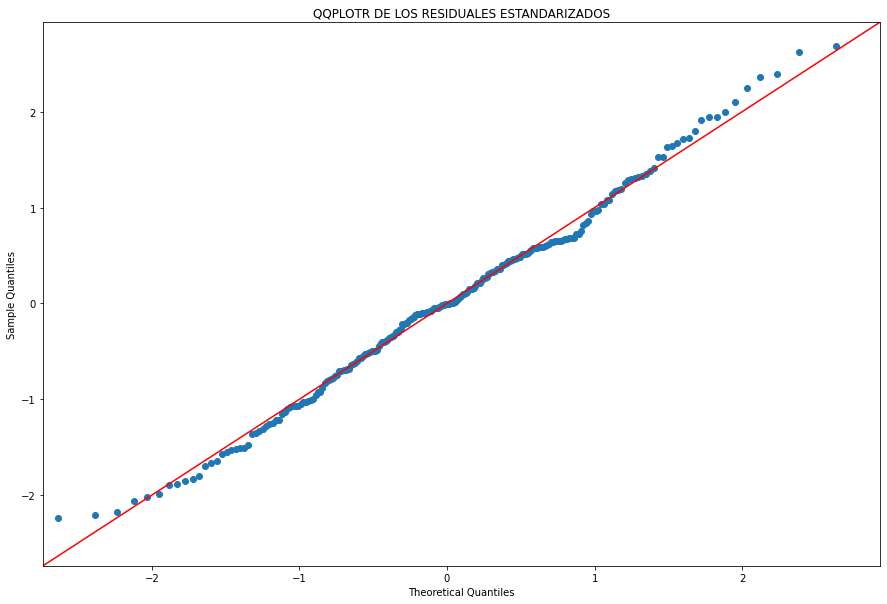

In [366]:
resid_standard = model.get_influence().resid_studentized_internal

fig , ax = plt.subplots(1,1,figsize=(15,10))
_ = sm.qqplot(resid_standard, line='45', ax=ax)
ax.set_title('QQPLOTR DE LOS RESIDUALES ESTANDARIZADOS')

In [367]:
stats.shapiro(resid_standard)

ShapiroResult(statistic=0.9926928281784058, pvalue=0.29906487464904785)

##### Kruskal-Wallis

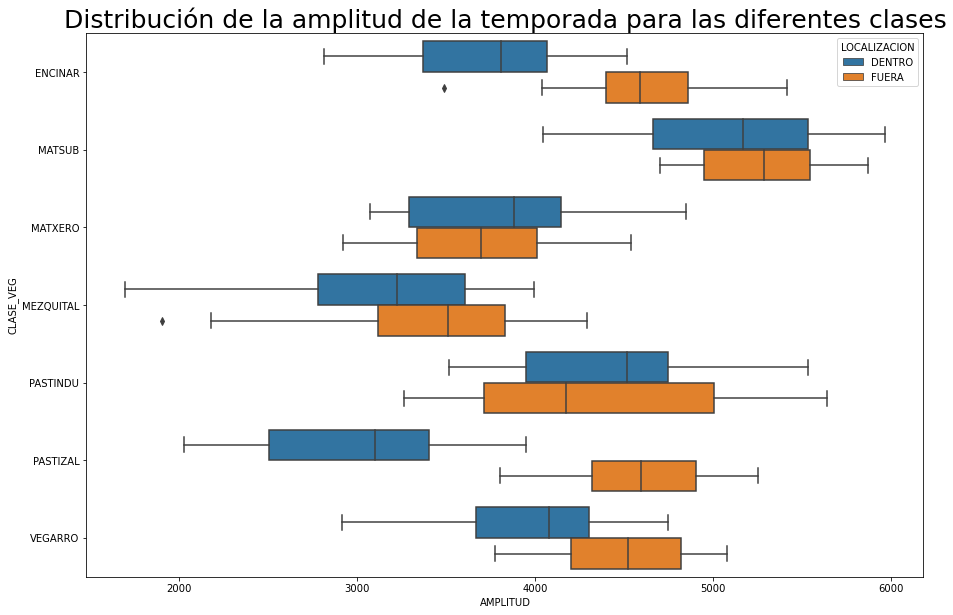

In [368]:
boxplots_variable_intergrupos(ts_ndvi, 'Distribución de la amplitud de la temporada para las diferentes clases', 'AMPLITUD', 'CLASE_VEG', 'LOCALIZACION')

In [369]:
print(prueba_kruskal_wallis(ts_ndvi, 'GRUPO', 'INTMEN'))

KruskalResult(statistic=167.30167520657162, pvalue=6.522678797799525e-29)


##### Pruebas Post Hoc: Tukey HSD

In [370]:
obj_tukey, _, comparaciones_dentro_fuera = prueba_tukey(ts_ndvi, 'GRUPO', 'INTMEN', 'CLASE_VEG')
comparaciones_dentro_fuera

0             group1           group2    meandiff   p-adj      lower  \
1     ENCINAR DENTRO    ENCINAR FUERA  10946.3158   0.001  3495.0376   
26     MATSUB DENTRO     MATSUB FUERA      1114.0     0.9 -6148.6076   
47    MATXERO DENTRO    MATXERO FUERA      -409.5     0.9 -7672.1076   
64  MEZQUITAL DENTRO  MEZQUITAL FUERA     -2456.0     0.9 -9718.6076   
77   PASTINDU DENTRO   PASTINDU FUERA    254.1842     0.9 -7103.3635   
86   PASTIZAL DENTRO   PASTIZAL FUERA      9440.0  0.0013  2177.3924   
91    VEGARRO DENTRO    VEGARRO FUERA   4462.8889  0.7216 -2998.7311   

0        upper reject  
1    18397.594   True  
26   8376.6076  False  
47   6853.1076  False  
64   4806.6076  False  
77   7611.7319  False  
86  16702.6076   True  
91  11924.5089  False

Text(0.5, 1.0, 'Intervalos de confianza para la media de cada grupo')

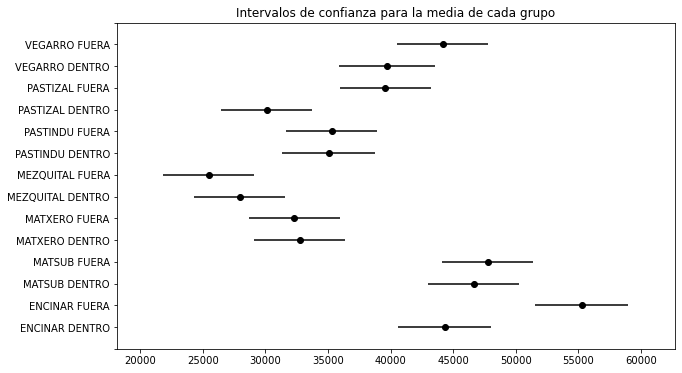

In [371]:
fig , ax = plt.subplots(1,1,figsize=(15,10))

_ = obj_tukey.plot_simultaneous(ax=ax)
ax.set_title('Intervalos de confianza para la media de cada grupo')